In [5]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)
library(survminer)
library(tidyr)
library(cmprsk)
options(warn=-1)
source("../../../../src/tools.R")
source("../../../script_figures/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

In [85]:
df <- read.table('../../../clustering/clustering_Final_1/df_final_full_component.tsv')
master <- read.table('../../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
tmp <- merge(df[,c("full_component_no_events","final_component")],master,by=0)
rownames(tmp) <- tmp$Row.names

In [89]:
nrow(tmp[is.na(tmp$OS_CR),])
max(tmp[is.na(tmp$OS_CR) & tmp$os_status==1,]$os)

[1] 657

[1] 5.653662

In [73]:
tmp[tmp$RFS > tmp$os & tmp$RelapseCIStatus==1,c("os","OS_CR","RFSyears","CR","RFS")]

os        OS_CR     RFSyears  CR         RFS      
PD15434a 1.6837782 1.5550992 1.5561644 0.12867899 1.6848434
PD20193a 0.7200548 0.6078029 0.6082192 0.11225186 0.7204711
PD22903c 0.7145791 0.6269678 0.6273973 0.08761126 0.7150086

In [82]:
tmp <- tmp[!is.na(tmp$OS_CR),]
tmp$CR <- tmp$os - tmp$OS_CR
tmp$RFS <- tmp$CR + tmp$RFSyears
# tmp[tmp$OS_CR < tmp$RFSyears,c("os","OS_CR","RFSyears")]
summary(tmp$try)
# tmp[,c("os","OS_CR","RFSyears")]
# tmp[tmp$RelapseCIStatus==1 & tmp$os_status,c("os","OS_CR","RFSyears","CR","RFS")]
mean(tmp$CR)

Length  Class   Mode 
     0   NULL   NULL 

[1] 0.1347981

In [8]:
tmp <-read.table('../handovercompiled.Yanis.080919.csv',sep=",",header=T)
rownames(tmp) <- tmp$data_pd
cols_to_keep <- colnames(tmp)
master <- read.table('../../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
df <- read.table('../../../clustering/clustering_Final_1/df_final_full_component.tsv')
df_merge <- merge(df,master[,c(cols_to_keep,"intense")],by=0)
rownames(df_merge) <- df_merge$Row.names
df_merge <- df_merge[-1]
df_merge$AMLID <- as.character(df_merge$AMLID)
df_merge$MRD1 <- as.character(df_merge$MRD1)
df_merge <- df_merge[grep("17-", df_merge$AMLID),]   ### keep only AML 17
df_merge$CR_MRD_neg <- ifelse(df_merge$MRD1=="CR,MRD-",1,0)
df_merge$CR_MRD_pos <- ifelse(df_merge$MRD1=="CR,MRD+",1,0)
df_merge$all_others <- ifelse(df_merge$MRD1!="CR,MRD+" & df_merge$MRD1!="CR,MRD-",1,0)
df_merge <- df_merge[!is.na(df_merge$OS_CR),]
df_merge <- df_merge[!is.na(df_merge$MRD1),]
df_merge <- df_merge[df_merge$os >0 & df_merge$OS_CR >0 & df_merge$RFSyears>0,]


genes <- colnames(df_merge[,c(5:88)])

cytos <- colnames(df_merge[,c(89:158)])

eln <- colnames(df_merge[,c(2,3,4)])
comp <- colnames(df_merge[,c(170:193)])

all_gen <- c(5:88)
vect <- apply(X=df_merge[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_merge)[1])
gen <- colnames(df_merge[,match(names(vect[vect>=2]),names(df_merge))])

all_cyto <- c(89:158)
vect <- apply(X=df_merge[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_merge)[1])
cyto <- colnames(df_merge[,match(names(vect[vect>=2]),names(df_merge))])

clin <- colnames(df_merge[,c(159:165)])
demo <- colnames(df_merge[,c(166:167)])

val <- c("#EE9937","#5C5C5C","#870C14","#BFBFBF","#59A08B","#2b8cbe","#a6bddb","#fdbb84","#e79f00","#000000","darkseagreen","lightskyblue","#0072B2","pink","blue","green")

# Cumulative Incidence Function

In [5]:
dd <- df_merge
dd$comp_sample_years = dd$RFSyears
dd$comp_status = "censor"
dd$comp_status[dd$RelapseCIStatus==1] = "relapse"
dd$comp_status[dd$RelapseCIStatus==2] = "death"
dd$comp_status = factor(dd$comp_status, levels=c("censor","relapse","death"))
table(dd$comp_status)


gg_competingrisks.cuminc <- function(fit, gnames = NULL, gsep=" ",
                                    coef = 1.96, conf.int = FALSE, line.size=4, group.levels=NULL,title="Relapse risk") {
    
  # -- fit is from cuminc --  #
  if (!is.null(fit$Tests))
    fit <- fit[names(fit) != "Tests"]
  fit2 <- lapply(fit, `[`, 1:3)
  if (is.null(gnames)) gnames <- names(fit2)
  fit2_list <- lapply(seq_along(gnames), function(ind) {
    df <- as.data.frame(fit2[[ind]])
    df$name <- gnames[ind]
    df
  })
  time <- est <- event <- group <- NULL
  df <- do.call(rbind, fit2_list)
  df$event <- sapply(strsplit(df$name, split=gsep), `[`, 2)
  df$group <- sapply(strsplit(df$name, split=gsep), `[`, 1)
  df$std <- std <- sqrt(df$var)
  if (!is.na(group.levels)) {
      df$group = factor(df$group, levels=group.levels)
  }

  df <- df[df$event=="relapse",]

  pl <-  ggplot(df, aes(time, est, color=group)) + geom_line(size=line.size,linetype=1) + ylab("Cumulative incidence") + xlab("Time (years)") + theme_survminer() + ggtitle(title)

  if (conf.int) {
    pl <- pl + geom_ribbon(aes(ymin = est - coef*std, ymax=est + coef*std, fill = event), alpha = 0.2, linetype=0)
  }

  return(pl)
}



 censor relapse   death 
    321     338      84 

# A few correlates

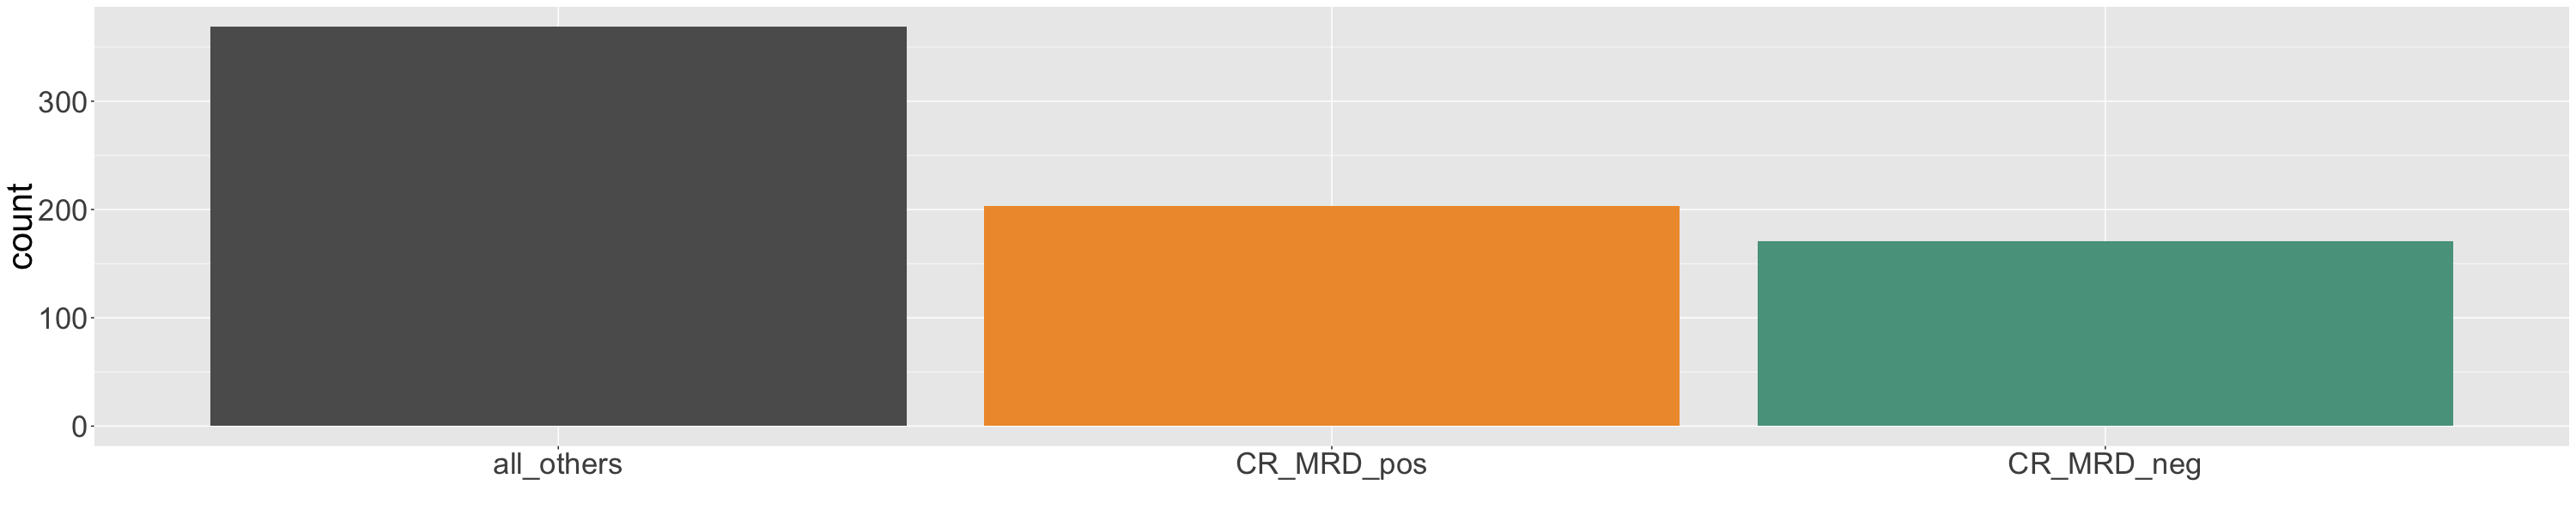

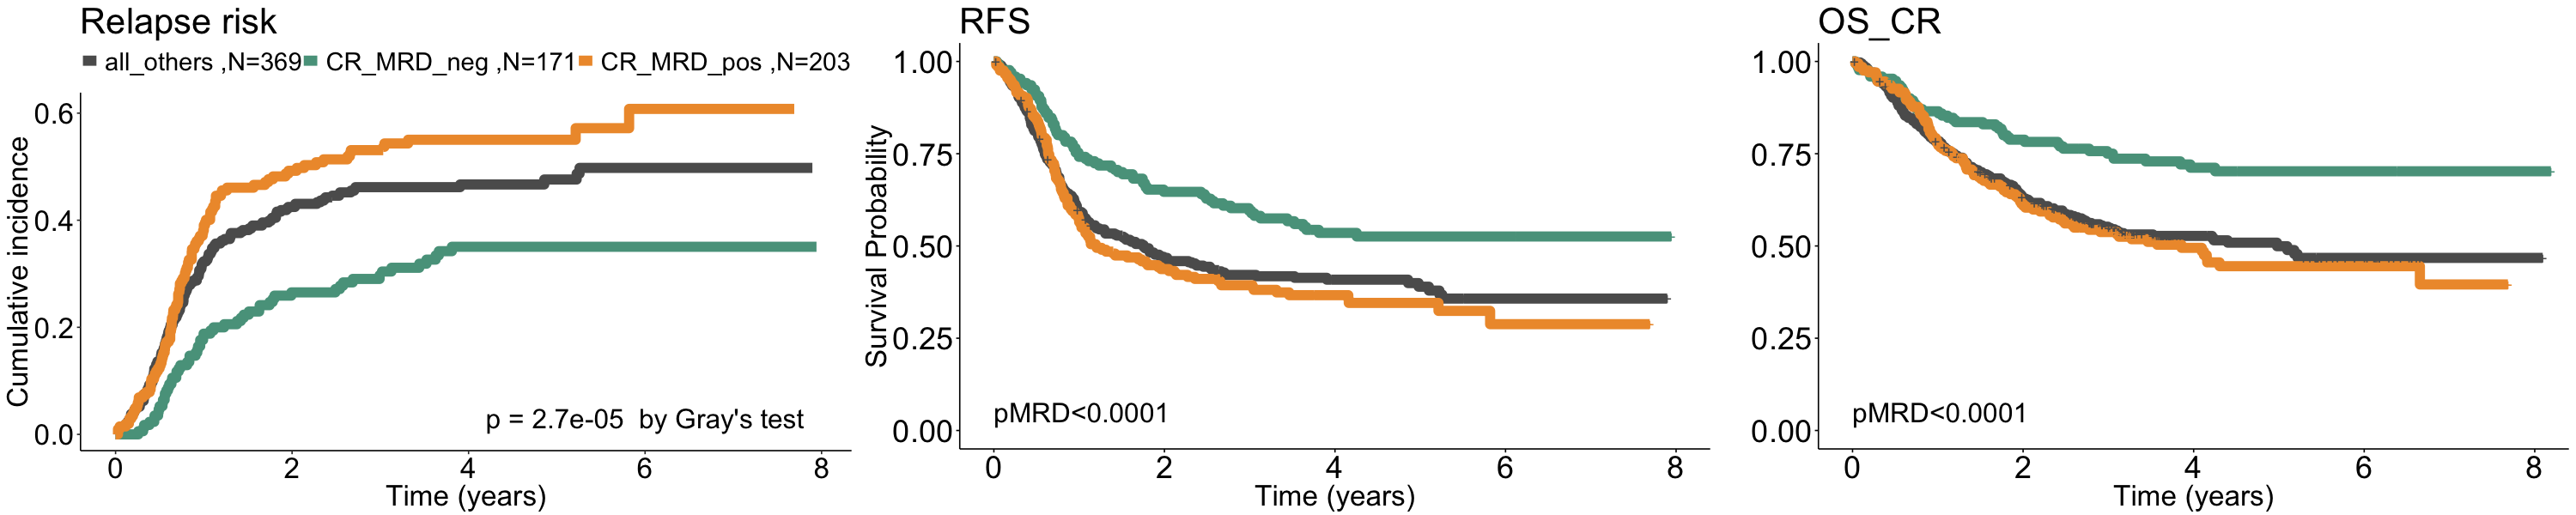

In [12]:
set_notebook_plot_size(30,6)
tmp<- df_merge
tmp$comparison <- ifelse(tmp$CR_MRD_neg==1,"CR_MRD_neg",
                        ifelse(tmp$CR_MRD_pos==1,"CR_MRD_pos","all_others"))

# RFS and OS
p <- list()
for (i in 1:2){
    if (i==1){
        res <- pairwise_survdiff(Surv(RFSyears,RFSStatus)~comparison,data = tmp[tmp$comparison %in% c("CR_MRD_neg","CR_MRD_pos"),])
        surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    }  else  {
        res <- pairwise_survdiff(Surv(OS_CR,DEADStatus)~comparison,data = tmp[tmp$comparison %in% c("CR_MRD_neg","CR_MRD_pos"),])
        surv_object <- Surv(time = tmp$OS_CR, event = tmp$DEADStatus)
        }
                    
                          
    fit <- survfit(surv_object ~ comparison, data = tmp)
    p[[i]] <- plot_surv_curves(fit,pval=ifelse(round(res$p.value[1],4)==0,"pMRD<0.0001",paste("pMRD = ",round(res$p.value[1],4),sep="")),
                               y=ifelse(i==1,"Survival Probability",""),submain=ifelse(i==1,"RFS","OS_CR"),font.legend=16,vals = c("#5C5C5C","#59A08B","#EE9937"),legend="none") 
}
tmp$comparison <- factor(tmp$comparison,levels=c("all_others","CR_MRD_pos","CR_MRD_neg"))
ggplot(tmp,aes(x=comparison,fill=comparison))+geom_bar()+scale_fill_manual(values = c("#5C5C5C","#EE9937","#59A08B"))+guides(fill=F)+theme(axis.text=element_text(size=25),axis.title=element_text(size=30))+xlab("")

tmp = dd
tmp$comparison <- ifelse(tmp$CR_MRD_neg==1,"CR_MRD_neg",
                         ifelse(tmp$CR_MRD_pos==1,"CR_MRD_pos","all_others"))

cmfit = with(tmp,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
tlg = table(tmp$comparison[!is.na(tmp$comp_sample_years)])
myleg = paste0(" ", names(tlg)," ,N=",tlg,"")

cmfit.test = with(tmp,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
pval = cmfit.test$Tests["relapse","pv"]

cr <- gg_competingrisks.cuminc(cmfit,line.size=4,group.levels=c("all_others","CR_MRD_neg","CR_MRD_pos"))+scale_color_manual(values=c("#5C5C5C","#59A08B","#EE9937"),labels=myleg)+
theme(legend.key.width = unit(0.5,"cm"),axis.text.y=element_text(size=24),axis.text.x=element_text(size=24),axis.title.x = element_text(size=24),axis.title.y = element_text(size=24),
      plot.title = element_text(size=30),legend.title = element_text(size=20),legend.text = element_text(size=21))+
      theme(legend.title = element_blank())+annotate("text",label=paste("p","=",round(pval,6)," by Gray's test"),x=6,y=0.03,size=8)
grid.arrange(cr,p[[1]]$plot,p[[2]]$plot,nrow=1)



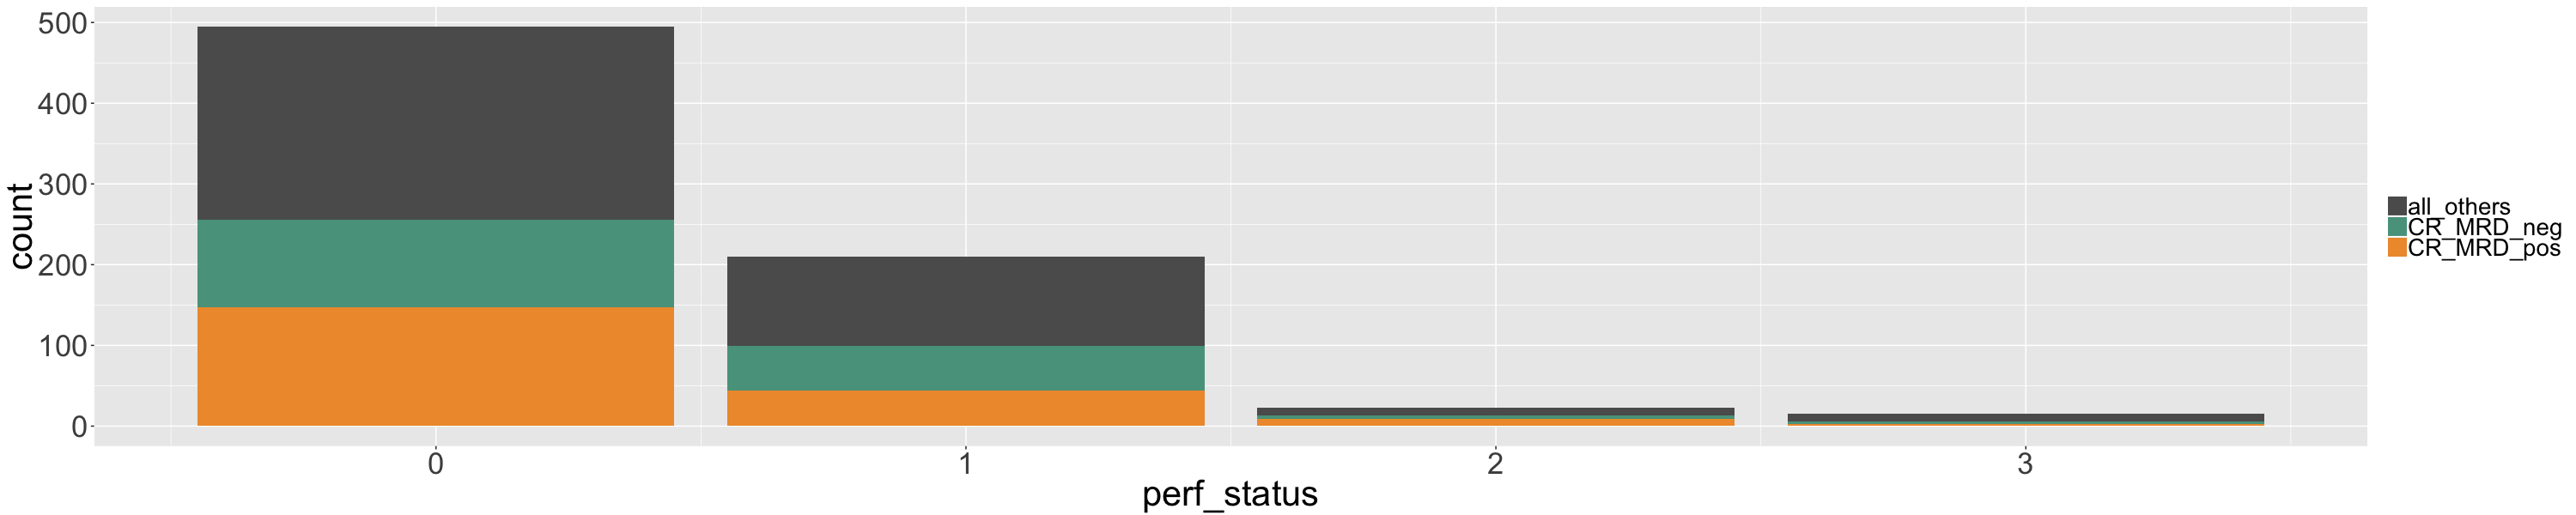

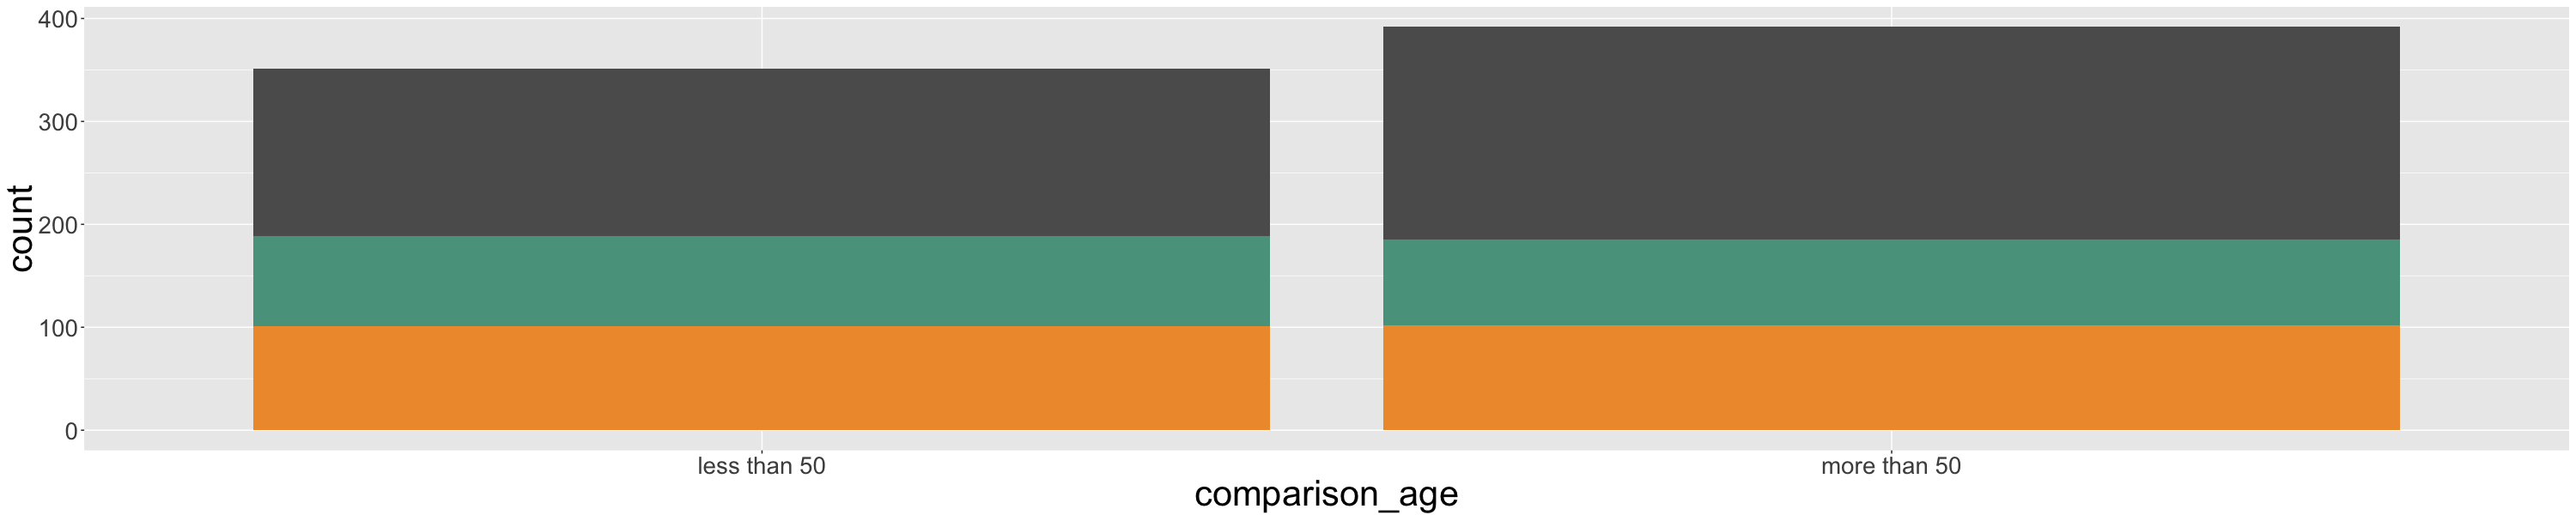

In [14]:
tmp<- df_merge
tmp$comparison <- ifelse(tmp$CR_MRD_neg==1,"CR_MRD_neg",
                        ifelse(tmp$CR_MRD_pos==1,"CR_MRD_pos","all_others"))

ggplot(tmp,aes(x=perf_status,fill=comparison))+geom_bar(stat="count")+scale_fill_manual(values = c("#5C5C5C","#59A08B","#EE9937"))+
theme(legend.text = element_text(size=20),axis.text=element_text(size=25),axis.title=element_text(size=30),legend.title=element_blank())

tmp$comparison <- ifelse(tmp$CR_MRD_neg==1,"CR_MRD_neg",
                        ifelse(tmp$CR_MRD_pos==1,"CR_MRD_pos","all_others"))
tmp$comparison_age <- ifelse(tmp$age<50,"less than 50","more than 50")


ggplot(tmp,aes(x=comparison_age,fill=comparison))+geom_bar(stat="count")+scale_fill_manual(values = c("#5C5C5C","#59A08B","#EE9937"))+guides(fill=F)+theme(axis.text=element_text(size=20),axis.title=element_text(size=30))

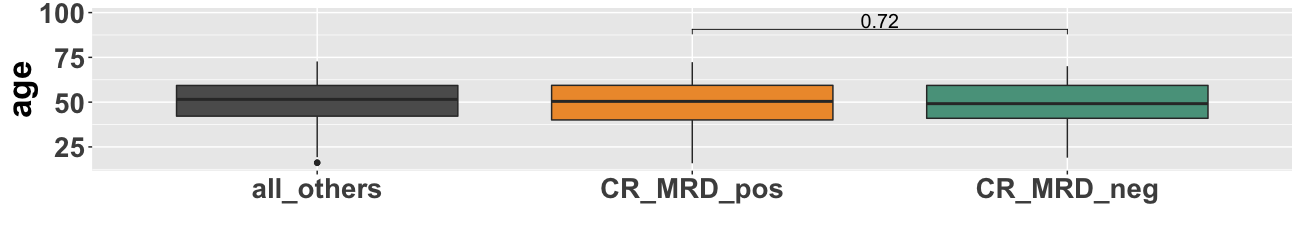

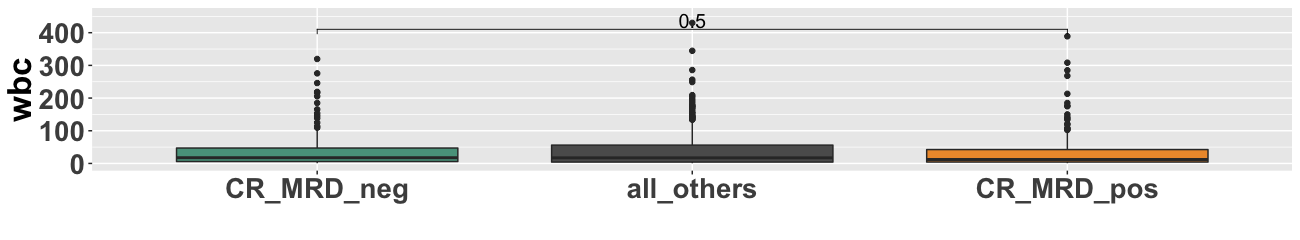

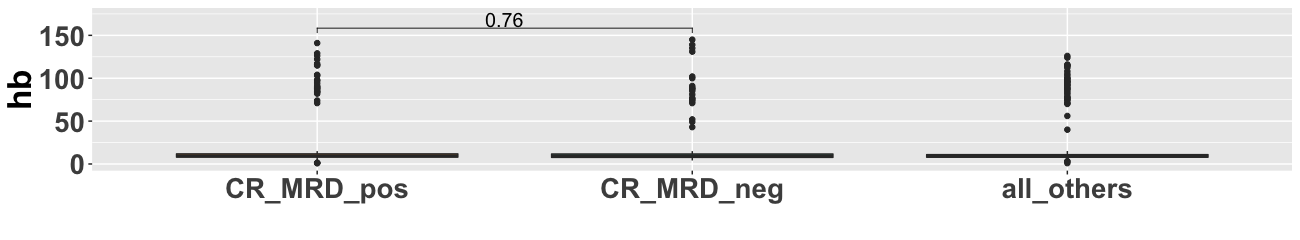

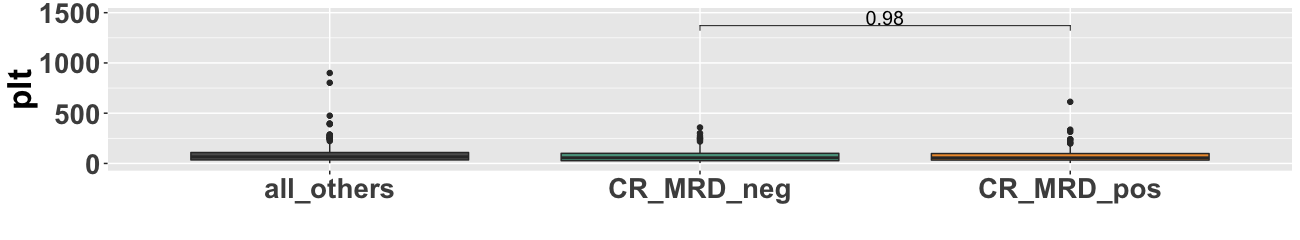

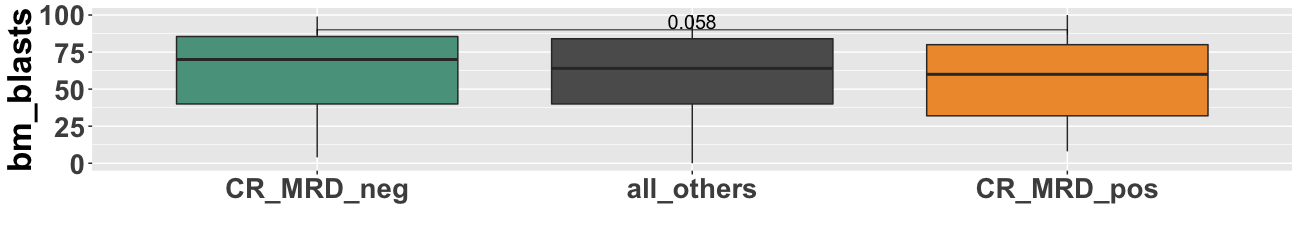

In [633]:
# c("gender","ahd","perf_status","secondary")
set_notebook_plot_size(13,2.4)
continuous_correlates=c("age","wbc","hb","plt","bm_blasts")
tmp<- df_merge
tmp$comparison <- ifelse(tmp$CR_MRD_neg==1,"CR_MRD_neg",
                        ifelse(tmp$CR_MRD_pos==1,"CR_MRD_pos","all_others"))


for (col in continuous_correlates){
#     png(paste(col,"_clinical.png",sep=""),width=4500,height=2500,res=200)
    p[[col]] <- ggplot(tmp,aes(x=reorder(comparison,-tmp[,col],FUN=median),y=tmp[,col],fill=comparison)) +
    geom_boxplot() +
    ylab(col)+xlab("")+theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=20,face="bold"),axis.title=element_text(size=24,face="bold"))+
    scale_y_continuous(limits = quantile(tmp[,col], c(0, 0.9999),na.rm = T))+
    scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+theme(legend.position = "none")+stat_compare_means(comparisons=list(c("CR_MRD_neg","CR_MRD_pos")),method="t.test",size=5,label.y=0.9*max(tmp[,col]))
    plot(p[[col]])
    
#     suppressWarnings(plot(p))
    }
       

# KM FOR ELN

In [22]:
set_notebook_plot_size(30,13)
p <- list()
cr <- list()
k <- 1
for (i in c(1:3)){
    if(i==1){
        tmp <- df_merge[df_merge$eln_2017_favorable==1,]
        tmp_cr <- dd[dd$eln_2017_favorable==1,]
        strat= "ELN Favorable"
        
    }else if(i==2){
        tmp <- df_merge[df_merge$eln_2017_intermediate==1,]
        tmp_cr <- dd[dd$eln_2017_intermediate==1,]
        strat= "ELN Intermediate"
    }else{
        tmp <- df_merge[df_merge$eln_2017_adverse==1,]
        tmp_cr <- dd[dd$eln_2017_adverse==1,]
        strat= "ELN Adverse"
    }
    tmp$comparison <- ifelse(tmp$CR_MRD_neg==1,"CR_MRD_neg",
                        ifelse(tmp$CR_MRD_pos==1,"CR_MRD_pos","all_others"))
    for (j in 1:2){
        if (j==1){
            res <- pairwise_survdiff(Surv(RFSyears,RFSStatus)~comparison,data = tmp[tmp$comparison %in% c("CR_MRD_neg","CR_MRD_pos"),])
            surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
        }  else  {
            res <- pairwise_survdiff(Surv(OS_CR,DEADStatus)~comparison,data = tmp[tmp$comparison %in% c("CR_MRD_neg","CR_MRD_pos"),])
            surv_object <- Surv(time = tmp$OS_CR, event = tmp$DEADStatus)            

        }
        fit <- survfit(surv_object ~ comparison, data = tmp)
        p[[k]] <- plot_surv_curves(fit,pval=ifelse(round(res$p.value[1],4)==0,"pMRD<0.0001",paste("pMRD = ",round(res$p.value[1],4),sep="")),
                                     y=ifelse(k %in% c(1,3,5),"Survival Probability",""),submain=paste(ifelse(j==1,"RFS ","OS_CR "),strat,sep=""),font.legend=20,vals = c("#5C5C5C","#59A08B","#EE9937"),legend="none")
        
        
    tmp_cr$comparison <- ifelse(tmp_cr$CR_MRD_neg==1,"CR_MRD_neg",
                     ifelse(tmp_cr$CR_MRD_pos==1,"CR_MRD_pos","all_others"))

    cmfit = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
    tlg = table(tmp_cr$comparison[!is.na(tmp_cr$comp_sample_years)])
    myleg = paste0(" ", names(tlg)," ,N=",tlg,"")

    cmfit.test = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
    pval = cmfit.test$Tests["relapse","pv"]

    cr[[i]] <- gg_competingrisks.cuminc(cmfit,line.size=4,group.levels=c("all_others","CR_MRD_neg","CR_MRD_pos"),title=paste("Relative risk for ",strat,sep=""))+scale_color_manual(values=c("#5C5C5C","#59A08B","#EE9937"),labels=myleg)+
    theme(legend.key.width = unit(0.5,"cm"),axis.text.y=element_text(size=24),axis.text.x=element_text(size=24),axis.title.x = element_text(size=24),axis.title.y = element_text(size=24),
          plot.title = element_text(size=30),legend.title = element_text(size=20),legend.text = element_text(size=20))+
          theme(legend.title = element_blank())+annotate("text",label=paste("p","=",round(pval,6)," by Gray's test"),x=6,y=0.03,size=8)
    k <- k+1
    }
}

png("eln_curves.png",width=7500,height=3050,res=250)
grid.arrange(cr[[1]],p[[1]]$plot,p[[2]]$plot,cr[[2]],p[[3]]$plot,p[[4]]$plot,cr[[3]],p[[5]]$plot,p[[6]]$plot,ncol=3)
dev.off()

pdf 
  2

# I) GENDER EFFECT ON MRD STATUS

In [25]:
set_notebook_plot_size(38,9)
tmp<- df_merge
tmp$comparison <- ifelse(tmp$CR_MRD_neg==1 & tmp$gender==0,"CR_MRD_neg_female",
                        ifelse(tmp$CR_MRD_neg==1 & tmp$gender==1,"CR_MRD_neg_male",
                            ifelse(tmp$CR_MRD_pos==1 & tmp$gender==0,"CR_MRD_pos_female",
                                   ifelse(tmp$CR_MRD_pos==1 & tmp$gender==1,"CR_MRD_pos_male",
                                          ifelse(tmp$all_others==1 & tmp$gender==0,"all_others_female","all_others_male")))))

# RFS and OS
p <- list()
for (i in 1:2){
    if (i==1){
        res_neg <- pairwise_survdiff(Surv(RFSyears,RFSStatus)~comparison,data = tmp[tmp$comparison %in% c("CR_MRD_neg_female","CR_MRD_neg_male"),])
        res_pos <- pairwise_survdiff(Surv(RFSyears,RFSStatus)~comparison,data = tmp[tmp$comparison %in% c("CR_MRD_pos_female","CR_MRD_pos_male"),])
        res_others <- pairwise_survdiff(Surv(RFSyears,RFSStatus)~comparison,data = tmp[tmp$comparison %in% c("all_others_female","all_others_male"),])
        surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    }  else  {
        res_neg <- pairwise_survdiff(Surv(OS_CR,DEADStatus)~comparison,data = tmp[tmp$comparison %in% c("CR_MRD_neg_female","CR_MRD_neg_male"),])
        res_pos <- pairwise_survdiff(Surv(OS_CR,DEADStatus)~comparison,data = tmp[tmp$comparison %in% c("CR_MRD_pos_female","CR_MRD_pos_male"),])
        res_others <- pairwise_survdiff(Surv(OS_CR,DEADStatus)~comparison,data = tmp[tmp$comparison %in% c("all_others_female","all_others_male"),])
        surv_object <- Surv(time = tmp$OS_CR, event = tmp$DEADStatus)
        }
                    
                          
    fit <- survfit(surv_object ~ comparison, data = tmp)
    p[[i]] <- plot_surv_curves(fit,pval=F,y=ifelse(i==1,"Survival Probability",""),submain=ifelse(i==1,"RFS","OS_CR"),font.legend=22,legend="none")
    p[[i]] <- p[[i]]$plot + annotate("text",label=paste("p_neg =",round(res_neg$p.value[1],3),sep=""),x=1,y=0,size=10) +
                    annotate("text",label=paste("p_pos =",round(res_pos$p.value[1],3),sep=""),x=1,y=0.15,size=10) +
                    annotate("text",label=paste("p_others =",round(res_others$p.value[1],3),sep=""),x=1,y=0.3,size=10)
}
tmp_cr <- dd
tmp_cr$comparison <- ifelse(tmp_cr$CR_MRD_neg==1 & tmp_cr$gender==0,"CR_MRD_neg_female",
                        ifelse(tmp_cr$CR_MRD_neg==1 & tmp_cr$gender==1,"CR_MRD_neg_male",
                            ifelse(tmp_cr$CR_MRD_pos==1 & tmp_cr$gender==0,"CR_MRD_pos_female",
                                   ifelse(tmp_cr$CR_MRD_pos==1 & tmp_cr$gender==1,"CR_MRD_pos_male",
                                          ifelse(tmp_cr$all_others==1 & tmp_cr$gender==0,"all_others_female","all_others_male")))))

cmfit = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
tlg = table(tmp_cr$comparison[!is.na(tmp_cr$comp_sample_years)])
myleg = paste0(" ", names(tlg)," ,N=",tlg,"")

cmfit.test = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
pval = cmfit.test$Tests["relapse","pv"]

cr <- gg_competingrisks.cuminc(cmfit,line.size=4,group.levels=c("all_others_female","all_others_male","CR_MRD_neg_female","CR_MRD_neg_male","CR_MRD_pos_female","CR_MRD_pos_male"))+
scale_color_manual(values=val,labels=myleg)+
theme(legend.key.width = unit(0.5,"cm"),axis.text.y=element_text(size=24),axis.text.x=element_text(size=24),axis.title.x = element_text(size=24),axis.title.y = element_text(size=24),
      plot.title = element_text(size=30),legend.title = element_text(size=20),legend.text = element_text(size=20))+
      theme(legend.title = element_blank())+annotate("text",label=paste("p","=",round(pval,6)," by Gray's test"),x=6,y=0.03,size=8)

png("tmp.png",width=10000,height=2500,res=274)
grid.arrange(cr,p[[1]],p[[2]],nrow=1)
dev.off()

pdf 
  2

# Gender Proportion gene by gene

to see if we can explain those differences in outcomes

In [83]:
tmp <- NULL
for (co in c(genes,cytos)){
    if(nrow(df_merge[df_merge[,co]==1,])>0){
        tmp1 <- df_merge[df_merge[,co]==1,]
        tmp1$components <- co
        tmp <- rbind(tmp,tmp1)
    }
}

s <- ggplot(tmp,aes(x=reorder(components,components,function(x) -length(x)),fill=factor(gender)))+ geom_bar(aes( y=..count../tapply(..count.., ..x.. ,sum)[..x..],fill=factor(gender))) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),axis.text.y = element_text(size=35,face="bold"),
      axis.title.y=element_text(size=50,face="bold"),legend.text=element_text(size=40),legend.title=element_text(size=45))+xlab("")+ylab("Proportion")+guides(fill=guide_legend(title="Gender"))
set_notebook_plot_size(100,10)
t <- ggplot(tmp,aes(x=reorder(components,components,function(x) -length(x)),fill=factor(gender)))+ geom_bar(aes(fill=factor(gender))) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=30,face="bold",angle=90,hjust=1),axis.text.y = element_text(size=30,face="bold"),
      axis.title.y=element_text(size=50,face="bold"),legend.text=element_text(size=40),legend.title=element_text(size=45))+xlab("")+ylab("Count")+guides(fill=guide_legend(title="Gender"))

In [84]:
png("gender_proportion.png",width=8000,height=3125,res=150)
grid.arrange(s,t,nrow=2)
dev.off()

pdf 
  2

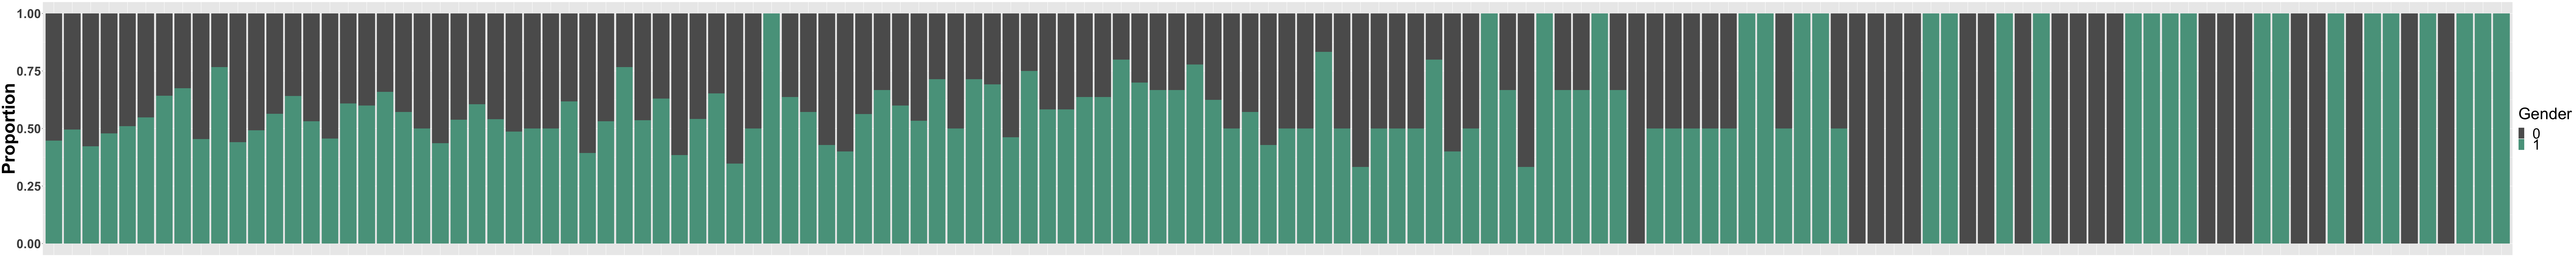

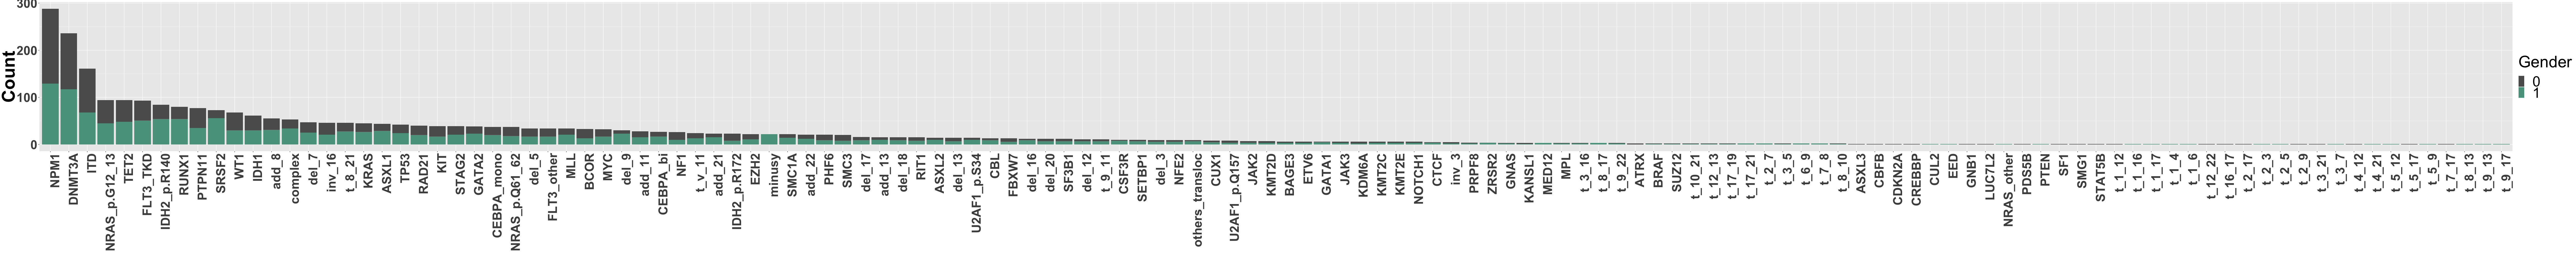

In [71]:
s
t

# Gender effect for MRD gene by gene

### Conclusion : Striking MRD Negative effect on gender : better female outcome and it seems like the inverse for MRD Positive
### Striking inverse effect from MRD Negative to MRD Positive for DNMT3A and NPM1

# Effect of MRD Negative

In [85]:
table(df_merge$RelapseCIStatus)


  0   1   2 
321 338  84 

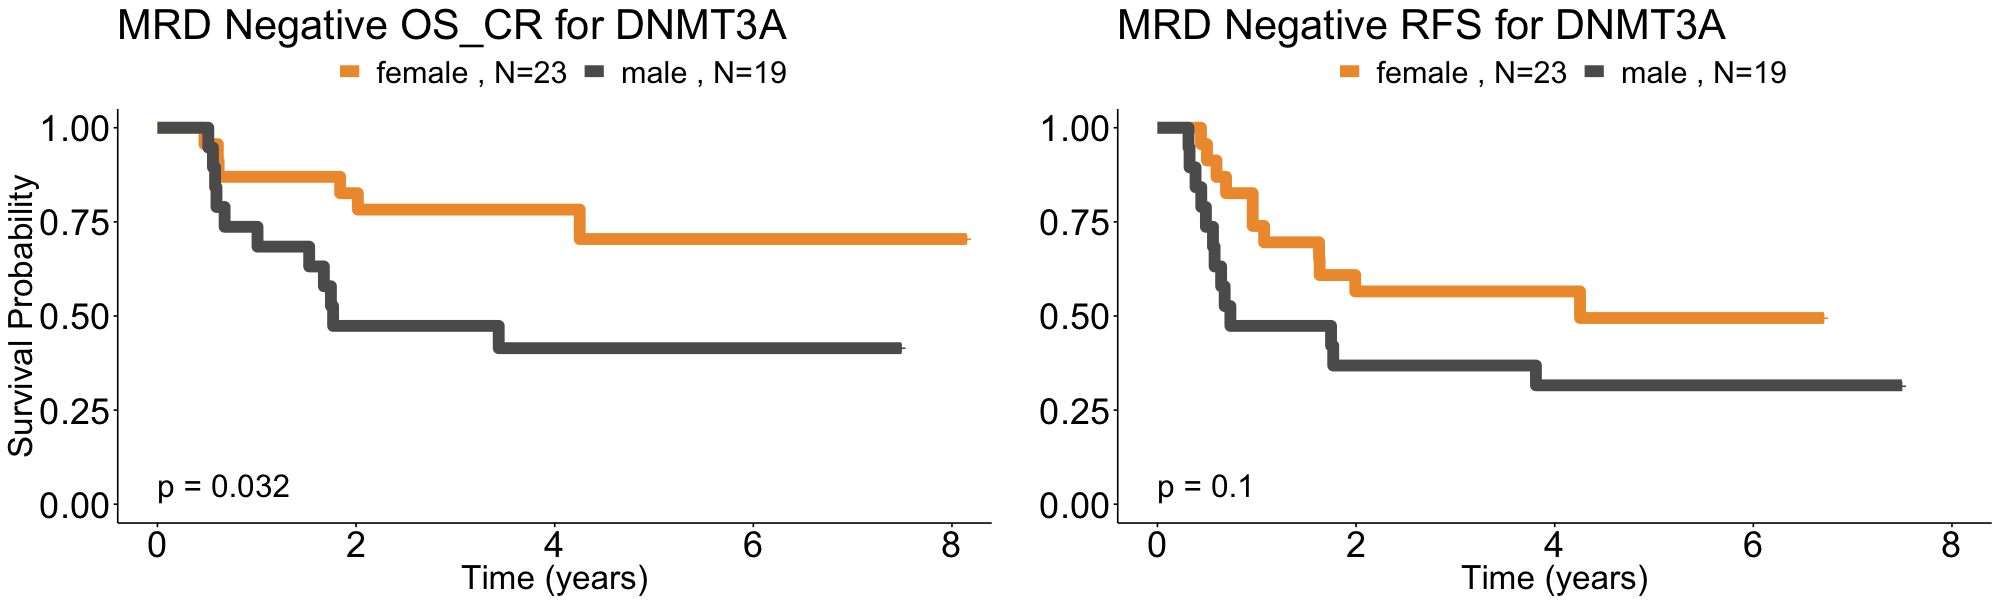

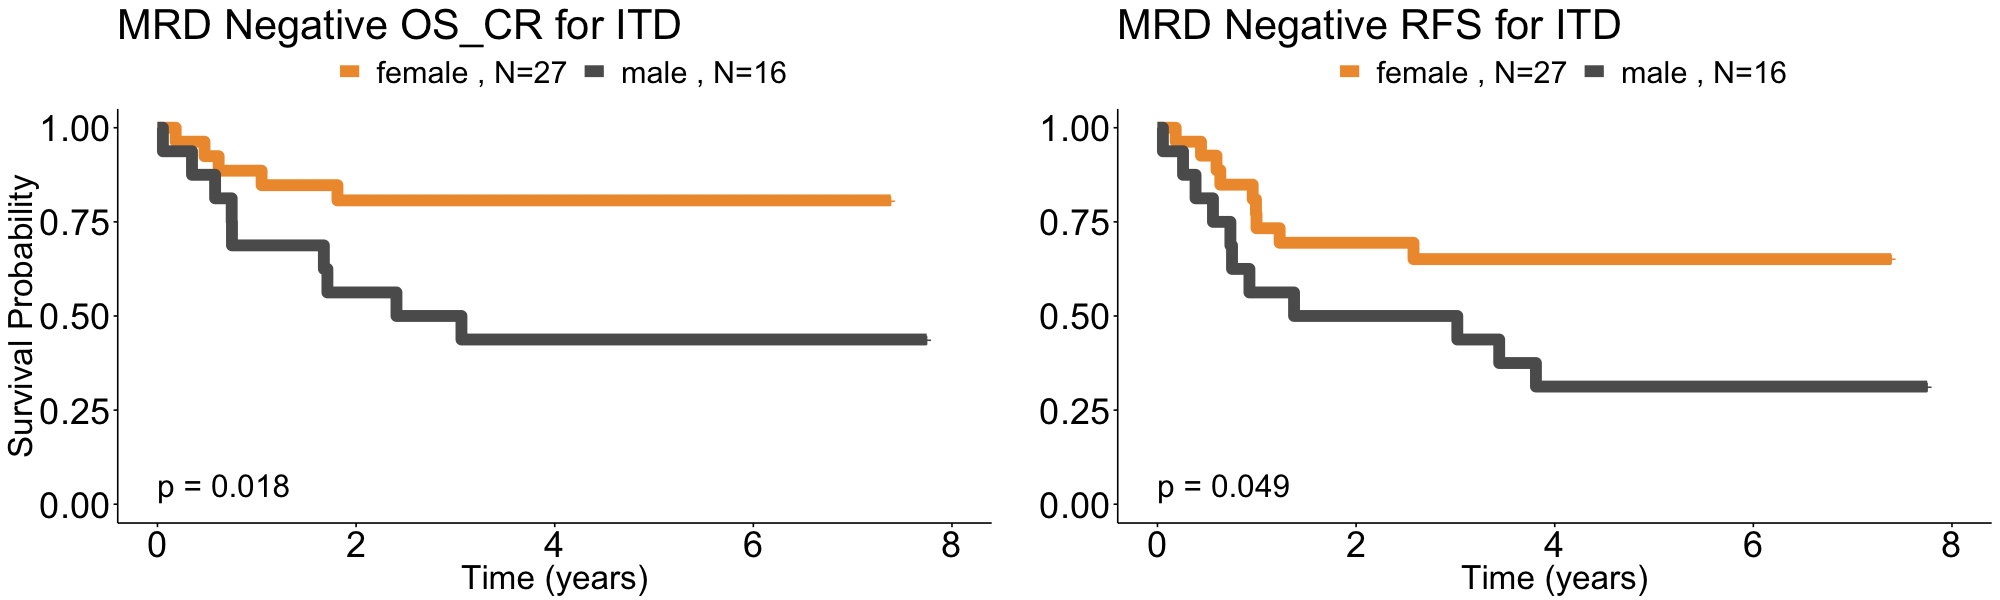

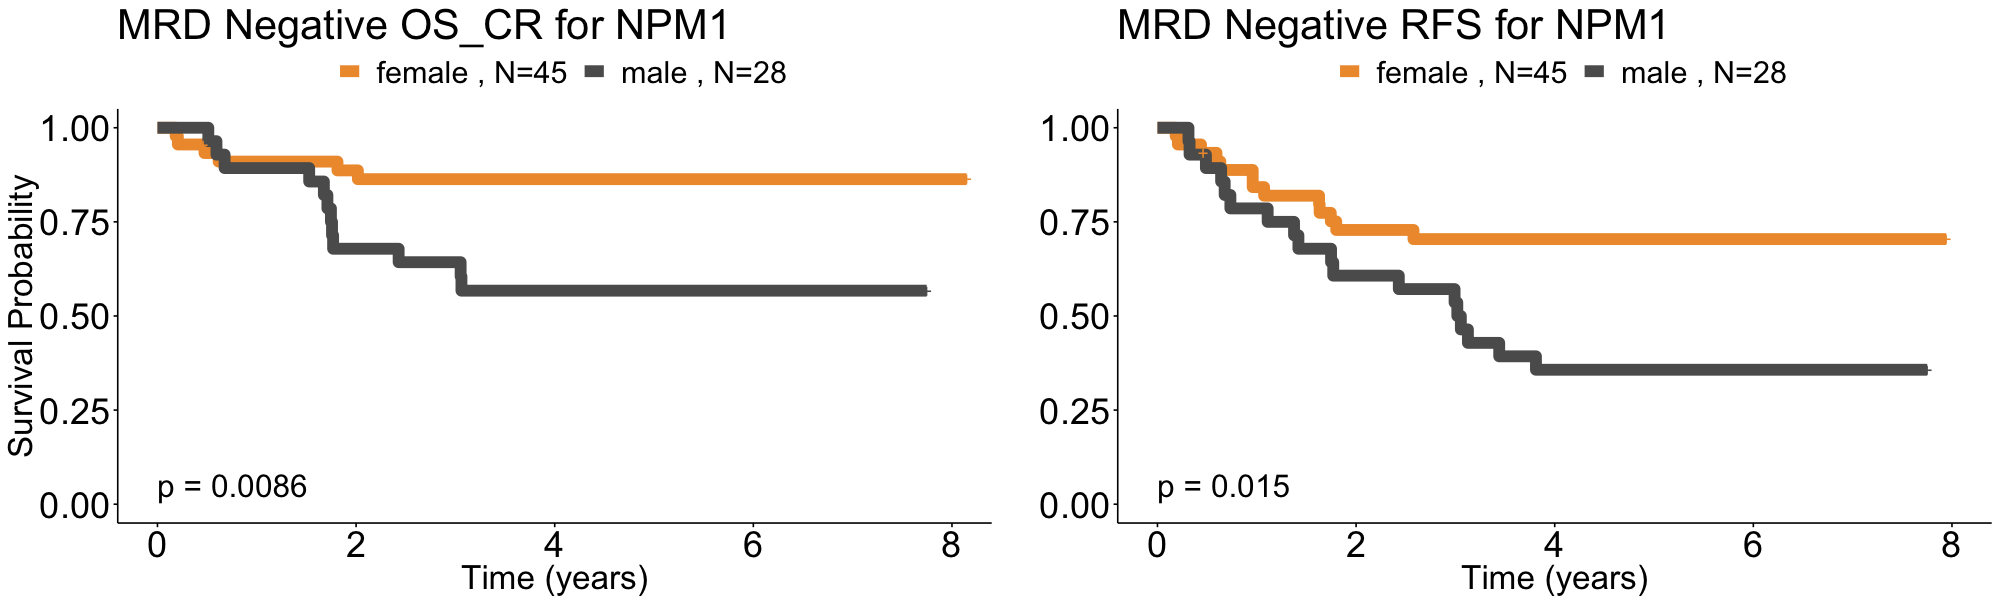

In [445]:
set_notebook_plot_size(20,6)
for (event in c("DNMT3A","ITD","NPM1")){
# for (event in c(genes,cytos)){
    tmp<- df_merge[df_merge$CR_MRD_neg==1 & df_merge[,event]==1,]
    tmp$comparison <- ifelse(tmp$gender==0,"female","male")
    if(nrow(tmp)>=10){
        # RFS and OS
        p <- list()
        for (i in 1:2){
            if (i==1){
                surv_object <- Surv(time = tmp$OS_CR, event = tmp$DEADStatus)
            }  else  {
                surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
                }


            fit <- survfit(surv_object ~ comparison, data = tmp)
            p[[i]] <- plot_surv_curves(fit,y=ifelse(i==1,"Survival Probability",""),submain=paste(ifelse(i==1,"MRD Negative OS_CR for ","MRD Negative RFS for "),event,sep=""),font.legend=22)
        }

        grid.arrange(p[[1]]$plot,p[[2]]$plot,nrow=1)
    }
}

# Effect of MRD Positive

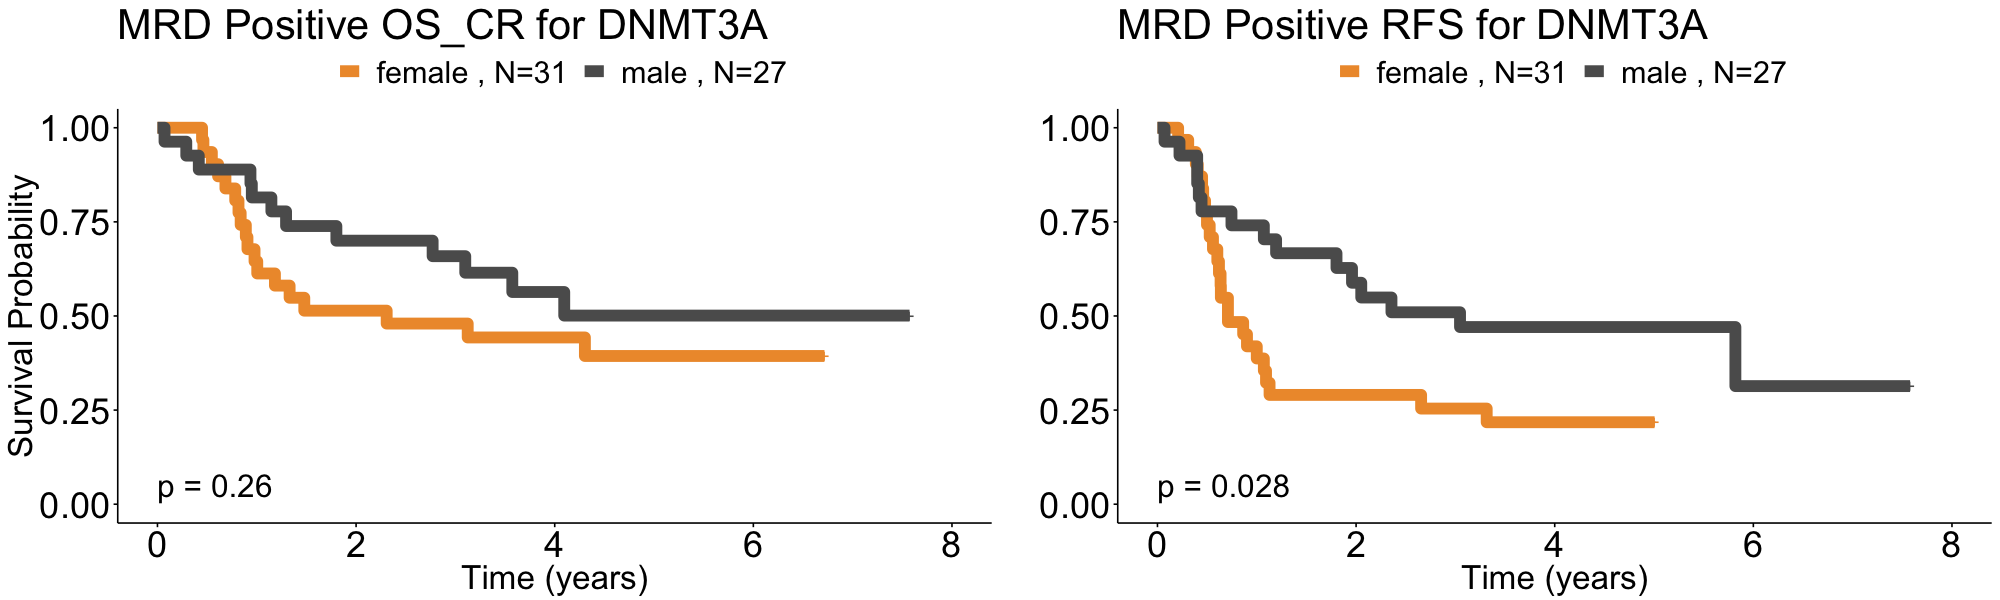

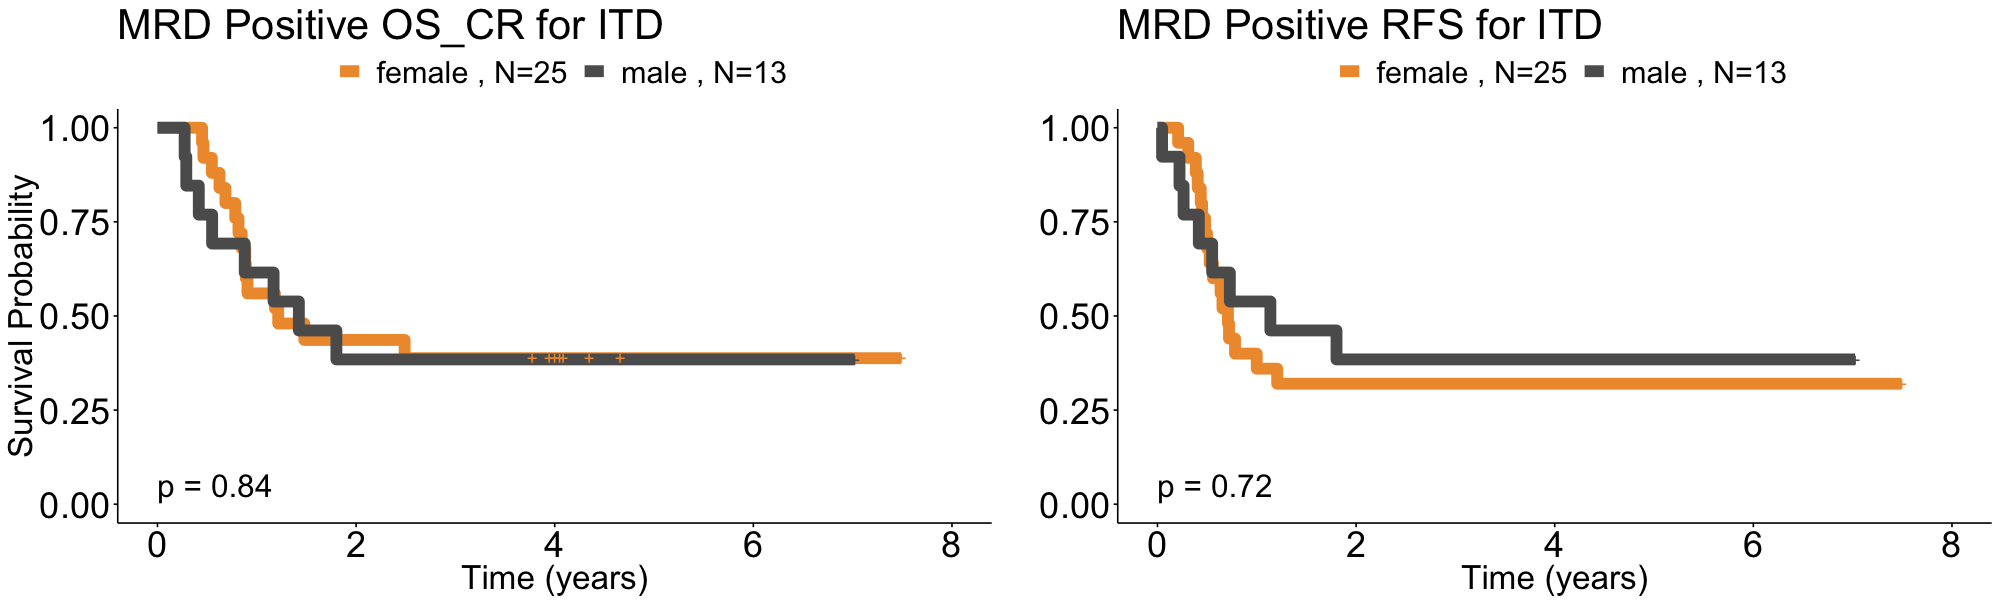

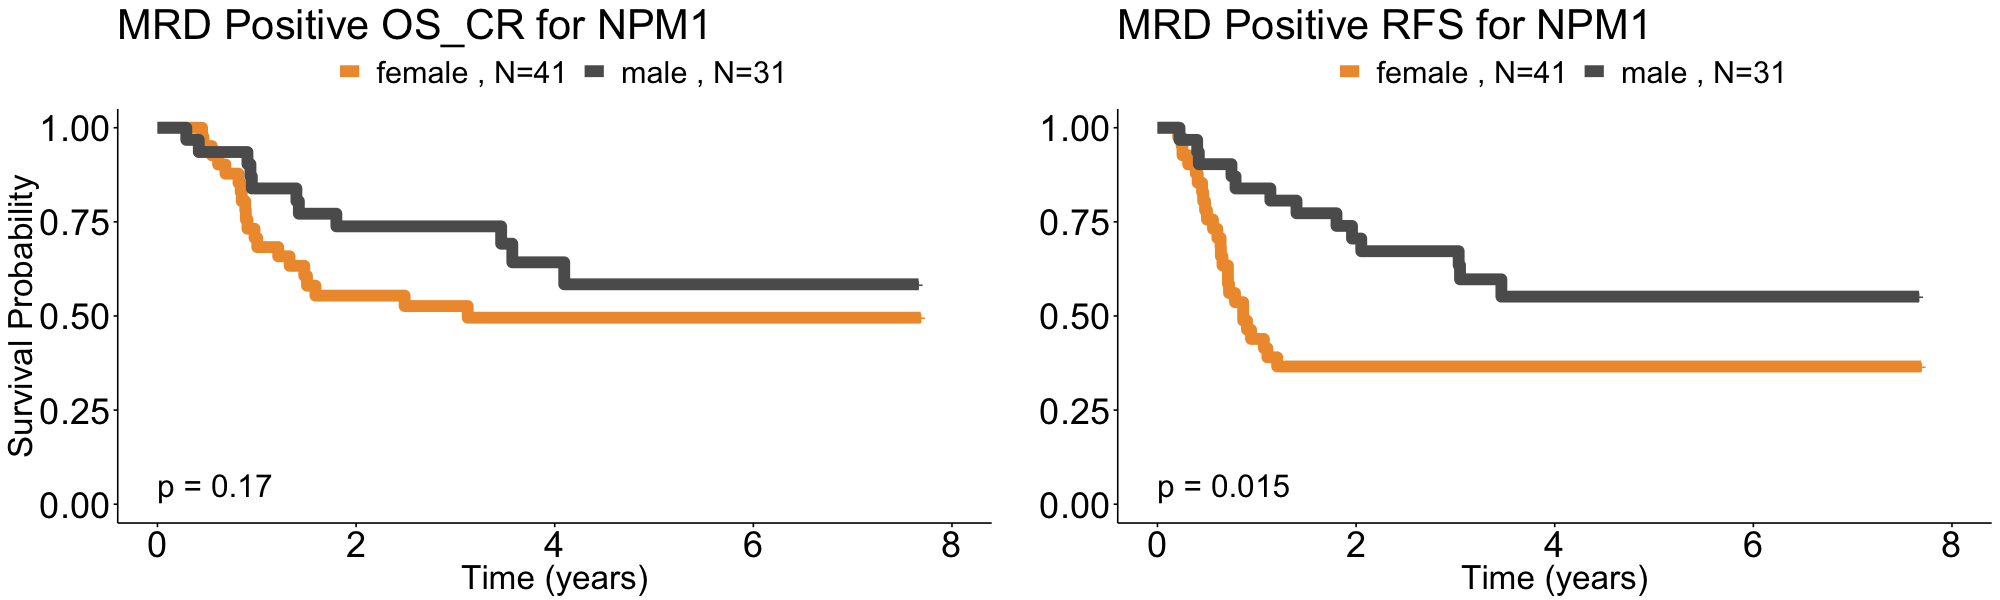

In [446]:
set_notebook_plot_size(20,6)
for (event in c("DNMT3A","ITD","NPM1")){
    tmp<- df_merge[df_merge$CR_MRD_pos==1 & df_merge[,event]==1,]
    tmp$comparison <- ifelse(tmp$gender==0,"female","male")
    if(nrow(tmp)>=20){
        # RFS and OS
        p <- list()
        for (i in 1:2){
            if (i==1){
                surv_object <- Surv(time = tmp$OS_CR, event = tmp$DEADStatus)
            }  else  {
                surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
                }


            fit <- survfit(surv_object ~ comparison, data = tmp)
            p[[i]] <- plot_surv_curves(fit,y=ifelse(i==1,"Survival Probability",""),submain=paste(ifelse(i==1,"MRD Positive OS_CR for ","MRD Positive RFS for "),event,sep=""),font.legend=22)
        }

        grid.arrange(p[[1]]$plot,p[[2]]$plot,nrow=1)
    }
}

# WRAP UP Effects on genes

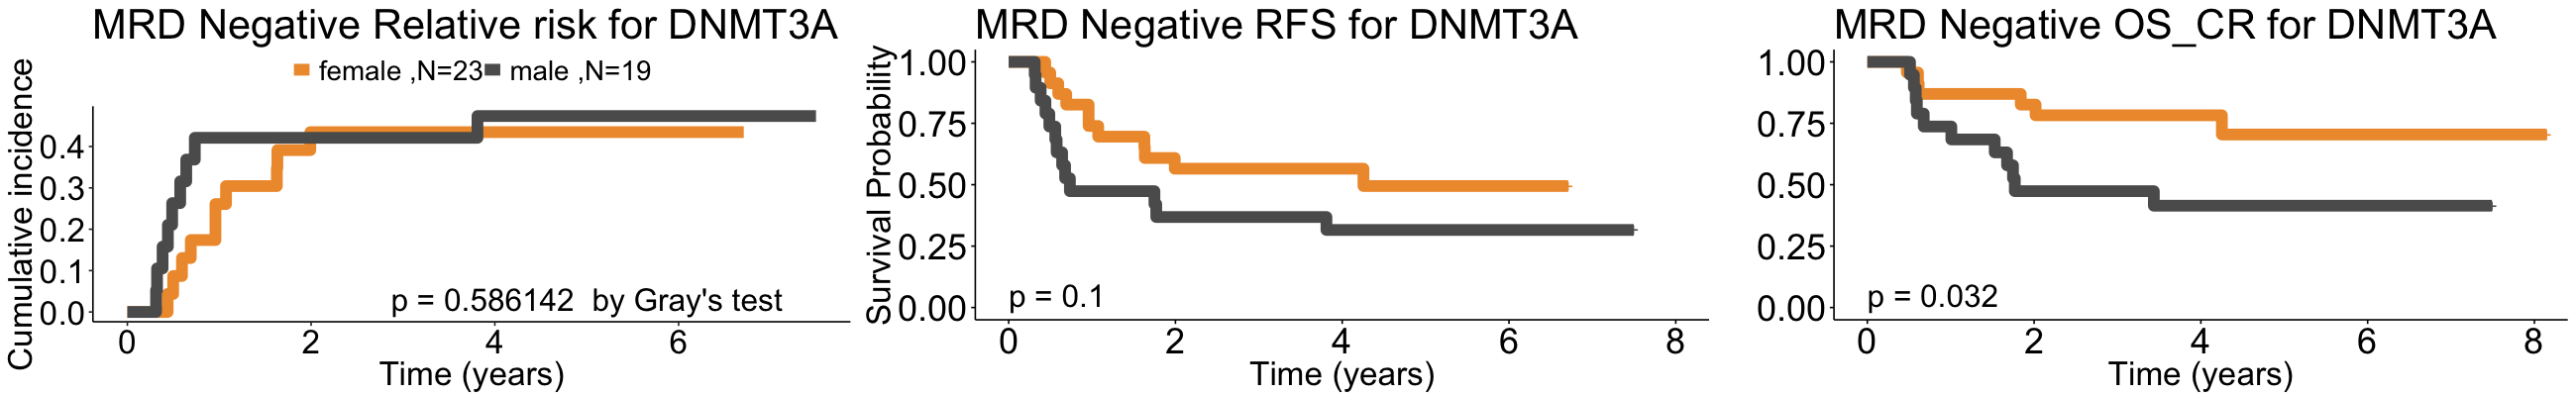

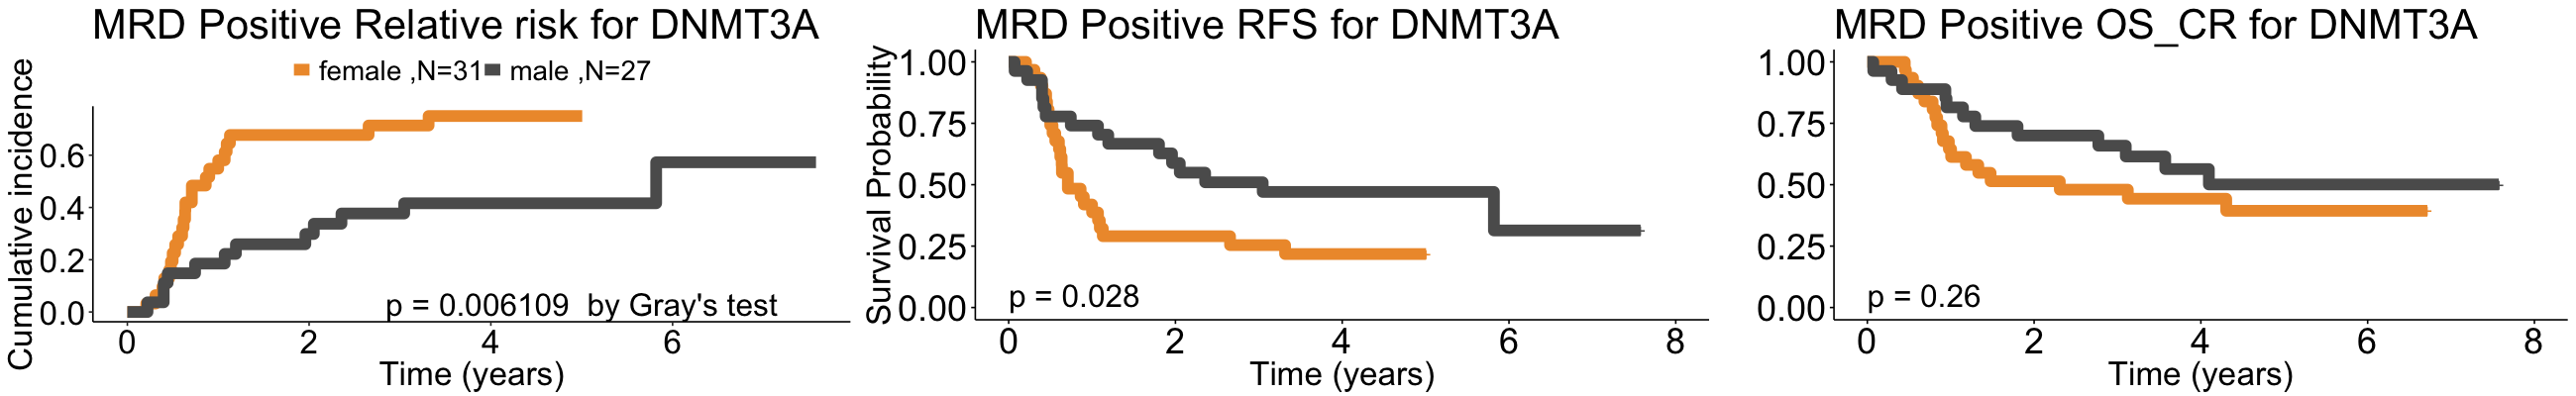

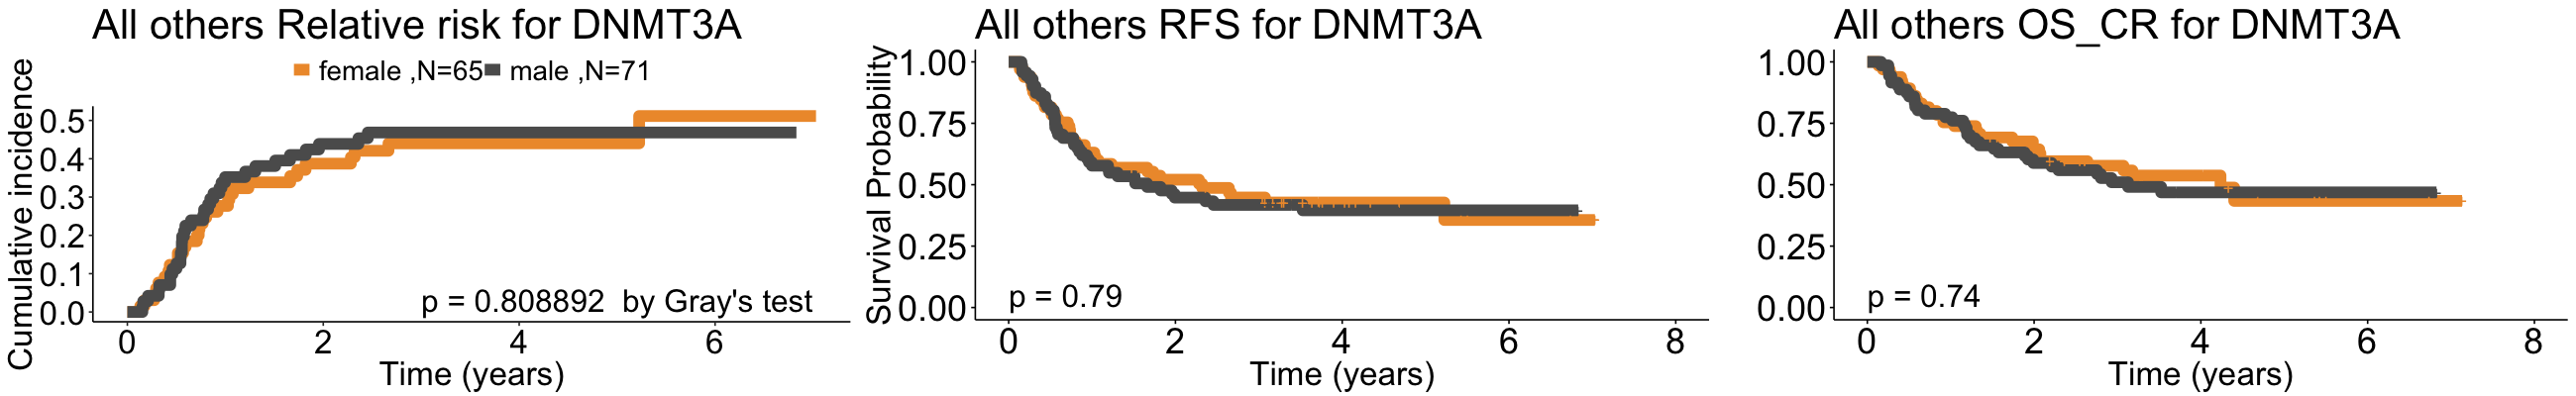

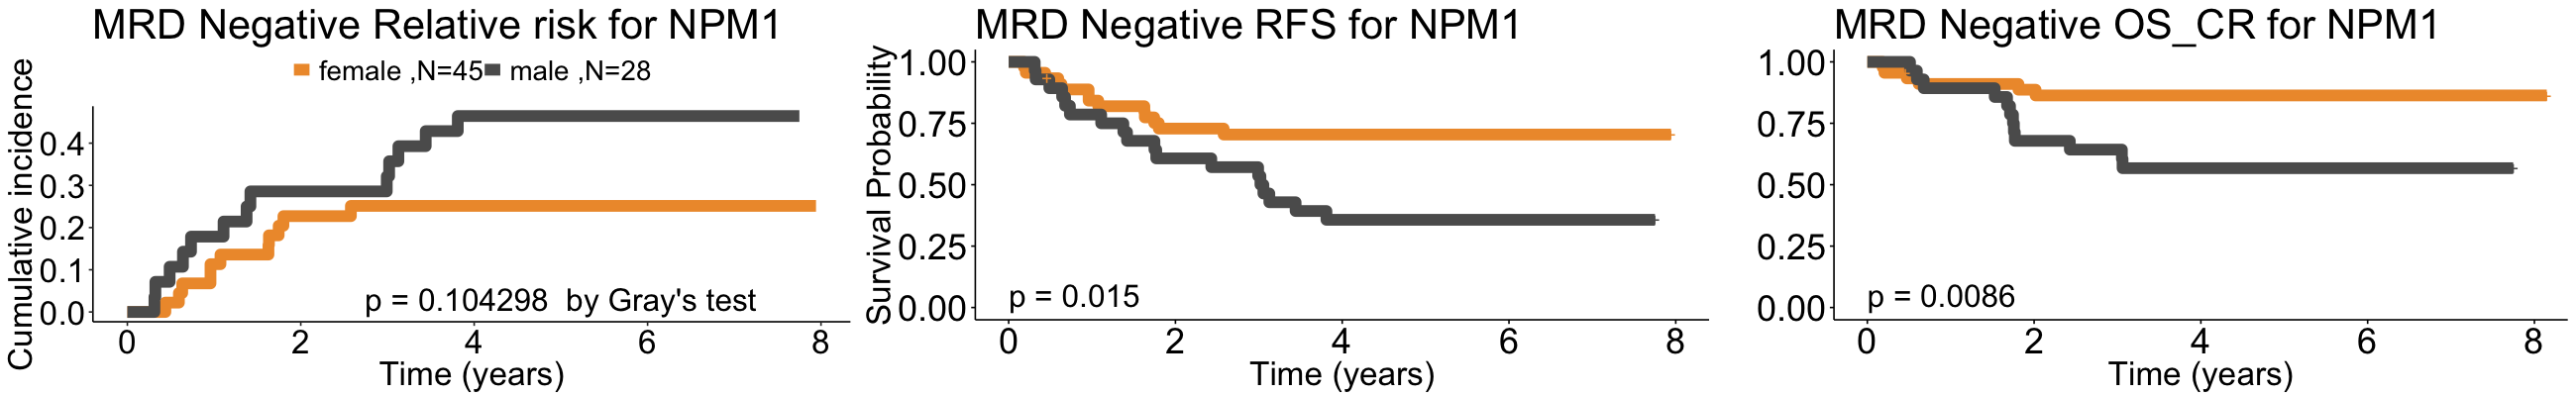

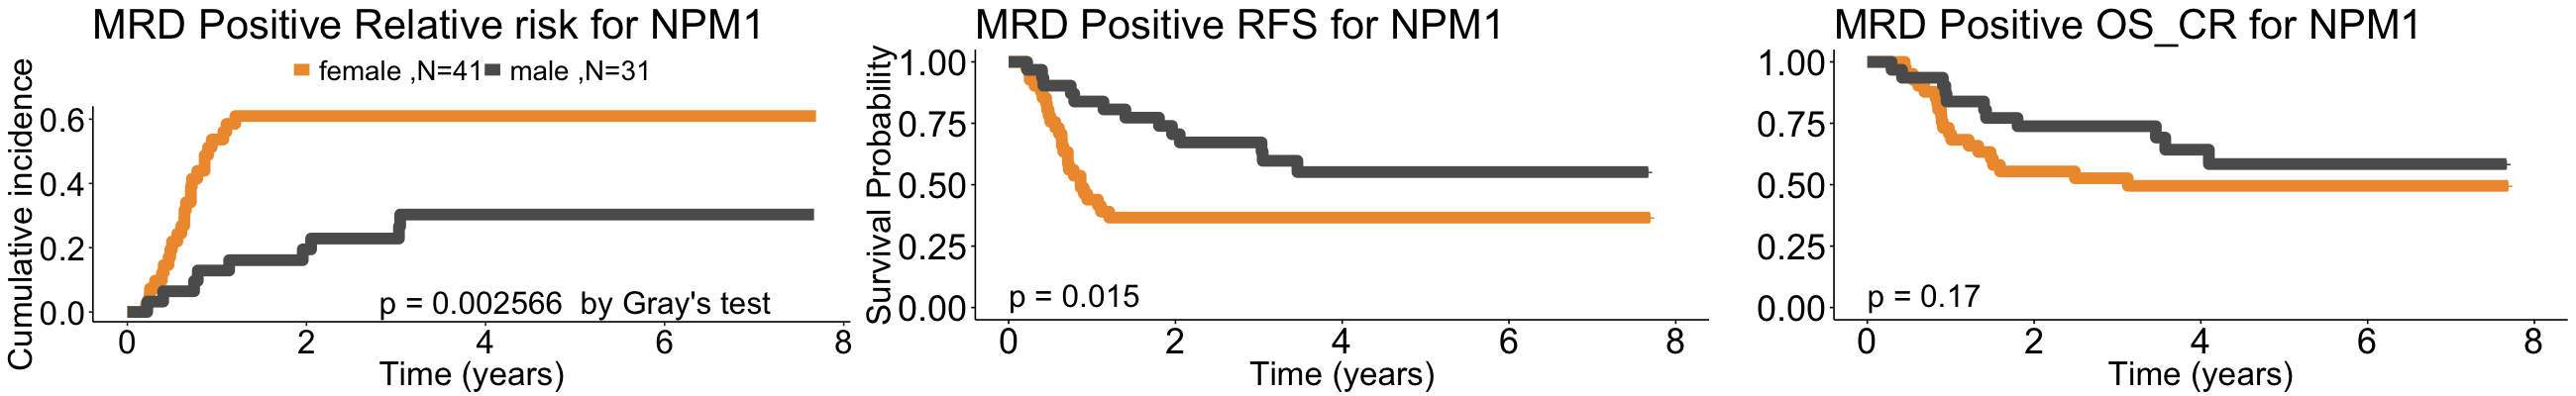

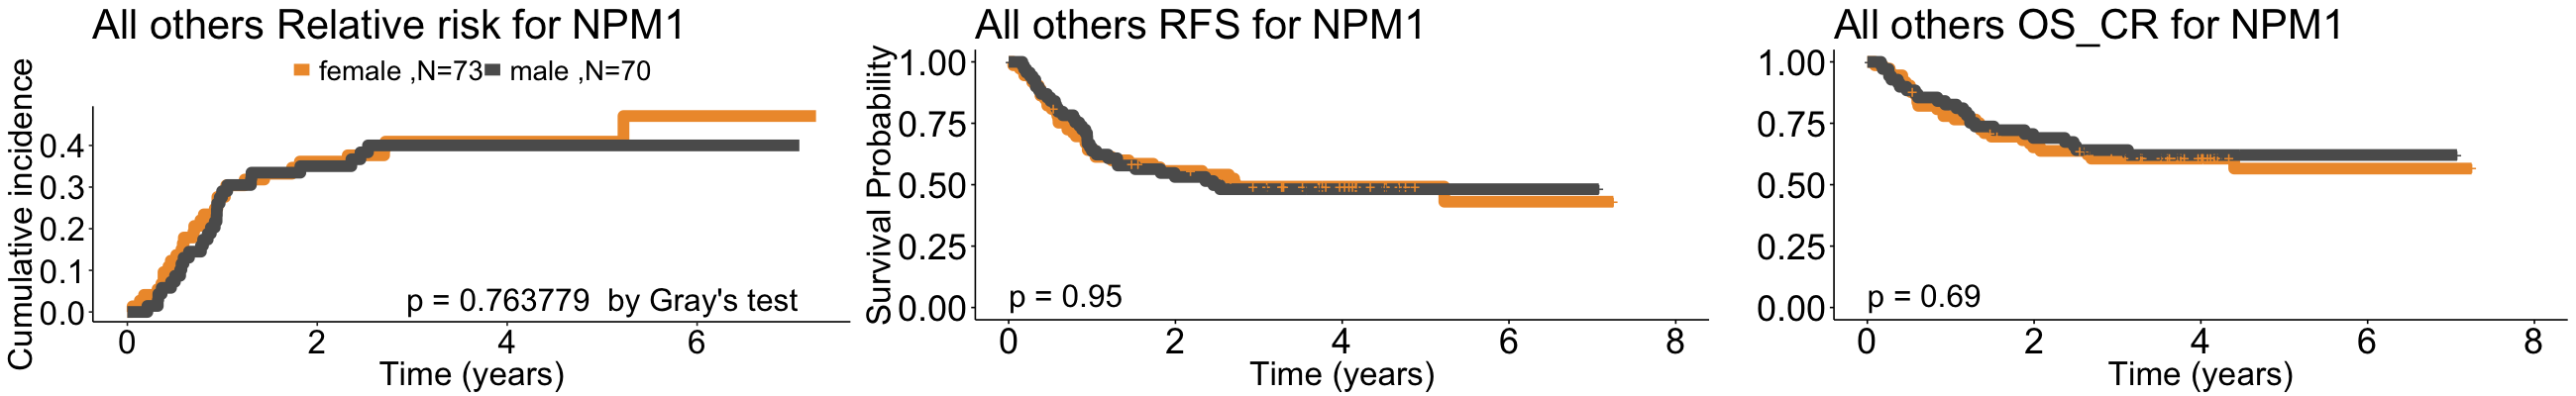

In [29]:
set_notebook_plot_size(26,4)
for (event in c("DNMT3A","NPM1")){
    tmp<- df_merge[df_merge$CR_MRD_neg==1 & df_merge[,event]==1,]
    tmp$comparison <- ifelse(tmp$gender==0,"female","male")
    for (i in 1:2){
        if (i==1){
            surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
        }  else  {
            surv_object <- Surv(time = tmp$OS_CR, event = tmp$DEADStatus)
            }
        fit <- survfit(surv_object ~ comparison, data = tmp)
        p[[i]] <- plot_surv_curves(fit,y=ifelse(i==1,"Survival Probability",""),submain=paste(ifelse(i==1,"MRD Negative RFS for ","MRD Negative OS_CR for "),event,sep=""),font.legend=22,legend="none")
    }
    
    tmp_cr <- dd[dd$CR_MRD_neg==1 & dd[,event]==1,]
    tmp_cr$comparison <- ifelse(tmp_cr$gender==0,"female","male")
    cmfit = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
    tlg = table(tmp_cr$comparison[!is.na(tmp_cr$comp_sample_years)])
    myleg = paste0(" ", names(tlg)," ,N=",tlg,"")

    cmfit.test = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
    pval = cmfit.test$Tests["relapse","pv"]

    cr <- gg_competingrisks.cuminc(cmfit,line.size=4,group.levels=c("female","male"),title=paste("MRD Negative Relative risk for ",event,sep=""))+
    scale_color_manual(values=val,labels=myleg)+
    theme(legend.key.width = unit(0.5,"cm"),axis.text.y=element_text(size=24),axis.text.x=element_text(size=24),axis.title.x = element_text(size=24),axis.title.y = element_text(size=24),
          plot.title = element_text(size=30),legend.title = element_text(size=20),legend.text = element_text(size=20))+
          theme(legend.title = element_blank())+annotate("text",label=paste("p","=",round(pval,6)," by Gray's test"),x=5,y=0.03,size=8)
    
    grid.arrange(cr,p[[1]]$plot,p[[2]]$plot,nrow=1)

    tmp<- df_merge[df_merge$CR_MRD_pos==1 & df_merge[,event]==1,]
    tmp$comparison <- ifelse(tmp$gender==0,"female","male")
    for (i in 1:2){
        if (i==1){
            surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
        }  else  {
            surv_object <- Surv(time = tmp$OS_CR, event = tmp$DEADStatus)
            }
        fit <- survfit(surv_object ~ comparison, data = tmp)
        p[[i]] <- plot_surv_curves(fit,y=ifelse(i==1,"Survival Probability",""),submain=paste(ifelse(i==1,"MRD Positive RFS for ","MRD Positive OS_CR for "),event,sep=""),font.legend=22,legend="none")
    }
    
    tmp_cr <- dd[dd$CR_MRD_pos==1 & dd[,event]==1,]
    tmp_cr$comparison <- ifelse(tmp_cr$gender==0,"female","male")
    cmfit = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
    tlg = table(tmp_cr$comparison[!is.na(tmp_cr$comp_sample_years)])
    myleg = paste0(" ", names(tlg)," ,N=",tlg,"")

    cmfit.test = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
    pval = cmfit.test$Tests["relapse","pv"]

    cr <- gg_competingrisks.cuminc(cmfit,line.size=4,group.levels=c("female","male"),title=paste("MRD Positive Relative risk for ",event,sep=""))+
    scale_color_manual(values=val,labels=myleg)+
    theme(legend.key.width = unit(0.5,"cm"),axis.text.y=element_text(size=24),axis.text.x=element_text(size=24),axis.title.x = element_text(size=24),axis.title.y = element_text(size=24),
          plot.title = element_text(size=30),legend.title = element_text(size=20),legend.text = element_text(size=20))+
          theme(legend.title = element_blank())+annotate("text",label=paste("p","=",round(pval,6)," by Gray's test"),x=5,y=0.03,size=8)
    
    grid.arrange(cr,p[[1]]$plot,p[[2]]$plot,nrow=1)
    
    tmp<- df_merge[df_merge$all_others==1 & df_merge[,event]==1,]
    tmp$comparison <- ifelse(tmp$gender==0,"female","male")
    for (i in 1:2){
        if (i==1){
            surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
        }  else  {
            surv_object <- Surv(time = tmp$OS_CR, event = tmp$DEADStatus)
            }
        fit <- survfit(surv_object ~ comparison, data = tmp)
        p[[i]] <- plot_surv_curves(fit,y=ifelse(i==1,"Survival Probability",""),submain=paste(ifelse(i==1,"All others RFS for ","All others OS_CR for "),event,sep=""),font.legend=22,legend="none")
    }
    
    tmp_cr <- dd[dd$all_others==1 & dd[,event]==1,]
    tmp_cr$comparison <- ifelse(tmp_cr$gender==0,"female","male")
    cmfit = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
    tlg = table(tmp_cr$comparison[!is.na(tmp_cr$comp_sample_years)])
    myleg = paste0(" ", names(tlg)," ,N=",tlg,"")

    cmfit.test = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
    pval = cmfit.test$Tests["relapse","pv"]

    cr <- gg_competingrisks.cuminc(cmfit,line.size=4,group.levels=c("female","male"),title=paste("All others Relative risk for ",event,sep=""))+
    scale_color_manual(values=val,labels=myleg)+
    theme(legend.key.width = unit(0.5,"cm"),axis.text.y=element_text(size=24),axis.text.x=element_text(size=24),axis.title.x = element_text(size=24),axis.title.y = element_text(size=24),
          plot.title = element_text(size=30),legend.title = element_text(size=20),legend.text = element_text(size=20))+
          theme(legend.title = element_blank())+annotate("text",label=paste("p","=",round(pval,6)," by Gray's test"),x=5,y=0.03,size=8)
    
    grid.arrange(cr,p[[1]]$plot,p[[2]]$plot,nrow=1)
}

# II) Significant MRD Effects 


# 1) Genes and Cytos

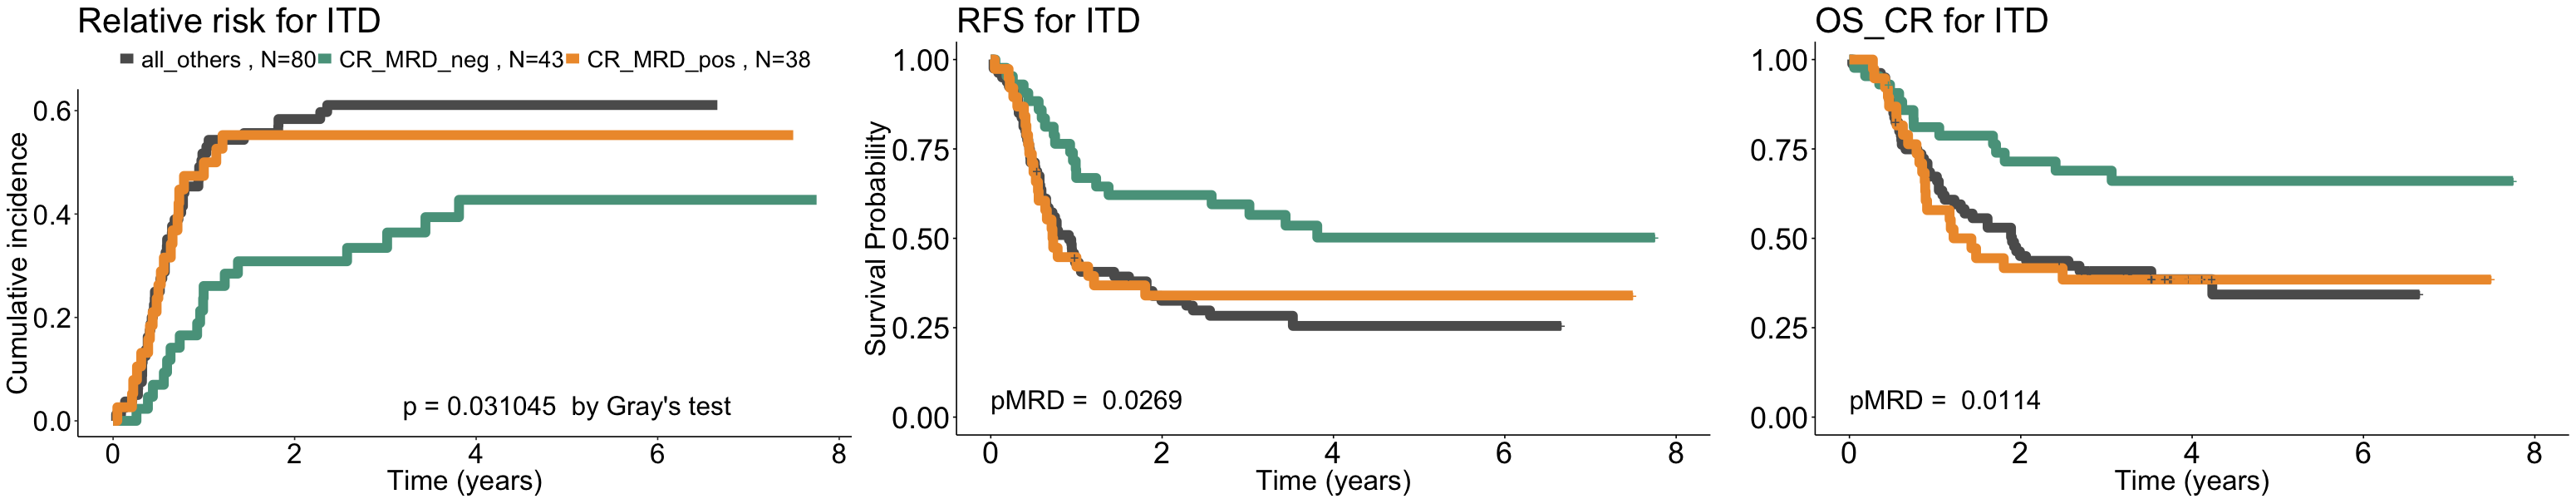

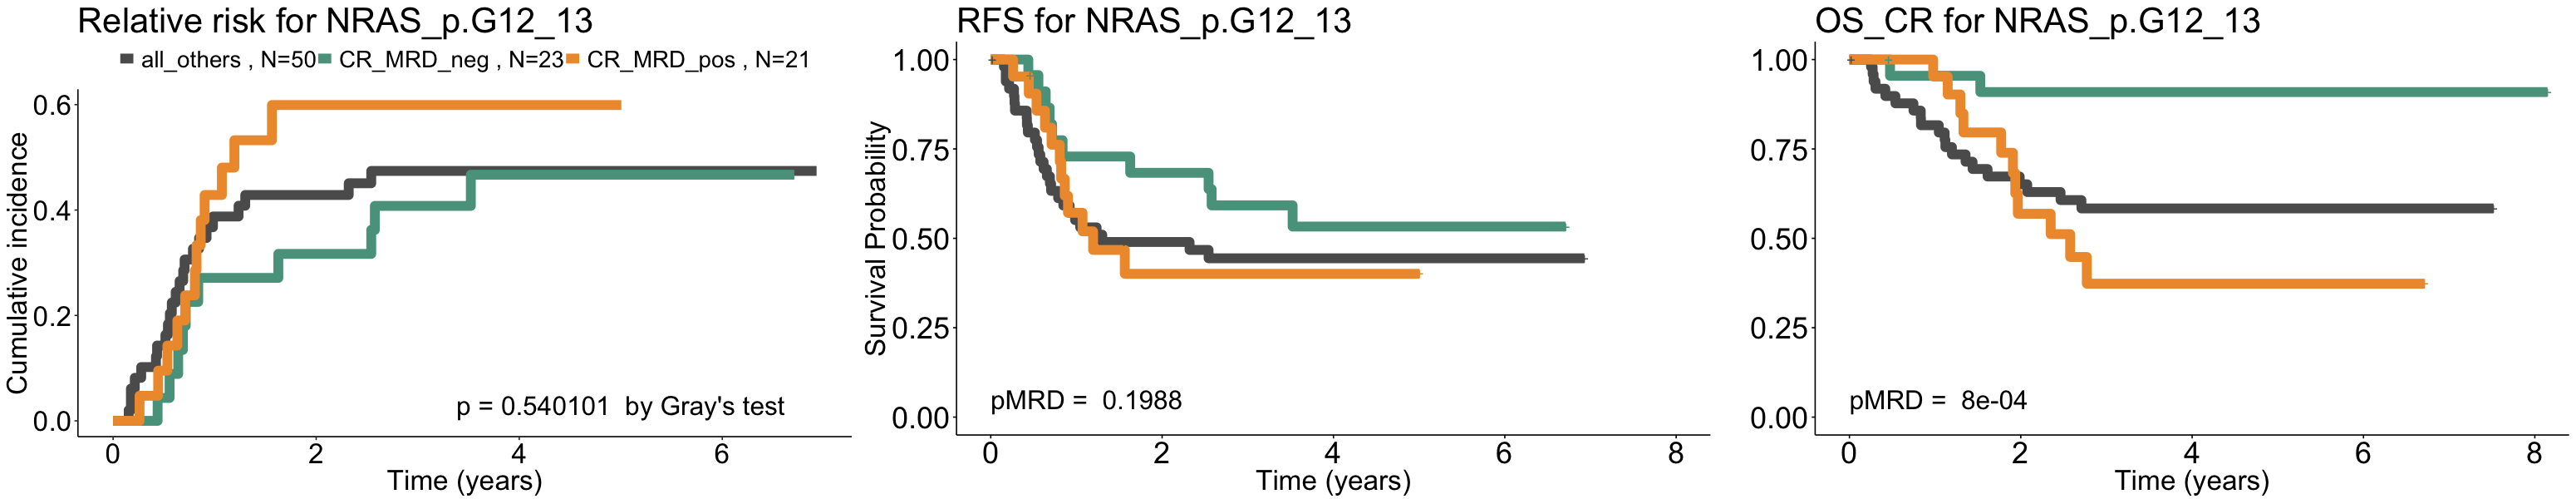

In [30]:
set_notebook_plot_size(31,6)
for (event in c("ITD","NRAS_p.G12_13")){
    tmp<- df_merge[df_merge[,event]==1,]
    if(nrow(tmp[tmp$CR_MRD_neg==1,])>=7 & nrow(tmp[tmp$CR_MRD_pos==1,])>=7){
        tmp$comparison <- ifelse(tmp$CR_MRD_neg==1,"CR_MRD_neg",
                            ifelse(tmp$CR_MRD_pos==1,"CR_MRD_pos","all others"))
        for (i in 1:2){
            if (i==1){
                res <- pairwise_survdiff(Surv(RFSyears,RFSStatus)~comparison,data = tmp[tmp$comparison %in% c("CR_MRD_neg","CR_MRD_pos"),])
                surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
            }  else  {
                res <- pairwise_survdiff(Surv(OS_CR,DEADStatus)~comparison,data = tmp[tmp$comparison %in% c("CR_MRD_neg","CR_MRD_pos"),])
                surv_object <- Surv(time = tmp$OS_CR, event = tmp$DEADStatus)

                }


            fit <- survfit(surv_object ~ comparison, data = tmp)
            p[[i]] <- plot_surv_curves(fit,y=ifelse(i==1,"Survival Probability",""),submain=paste(ifelse(i==1,"RFS for ","OS_CR for "),event,sep=""),font.legend=20,vals = c("#5C5C5C","#59A08B","#EE9937"),
                                      pval=ifelse(round(res$p.value[1],4)==0,"pMRD<0.0001",paste("pMRD = ",round(res$p.value[1],4))),legend="none")
        }
        
    tmp_cr <- dd[dd[,event]==1,]
    tmp_cr$comparison <- ifelse(tmp_cr$CR_MRD_neg==1,"CR_MRD_neg",
                            ifelse(tmp_cr$CR_MRD_pos==1 ,"CR_MRD_pos","all_others"))

    cmfit = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
    tlg = table(tmp_cr$comparison[!is.na(tmp_cr$comp_sample_years)])
    myleg = paste0(" ", names(tlg)," , N=",tlg,"")

    cmfit.test = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
    pval = cmfit.test$Tests["relapse","pv"]

    cr <- gg_competingrisks.cuminc(cmfit,line.size=4,group.levels=names(tlg),title=paste("Relative risk for",event))+
    scale_color_manual(values=c("#5C5C5C","#59A08B","#EE9937"),labels=myleg)+
    theme(legend.key.width = unit(0.5,"cm"),axis.text.y=element_text(size=24),axis.text.x=element_text(size=24),axis.title.x = element_text(size=24),axis.title.y = element_text(size=24),
          plot.title = element_text(size=30),legend.title = element_text(size=20),legend.text = element_text(size=20))+
          theme(legend.title = element_blank())+annotate("text",label=paste("p","=",round(pval,6)," by Gray's test"),x=5,y=0.03,size=8)
        
    grid.arrange(cr,p[[1]]$plot,p[[2]]$plot,nrow=1)
    }
}



# 2) Components

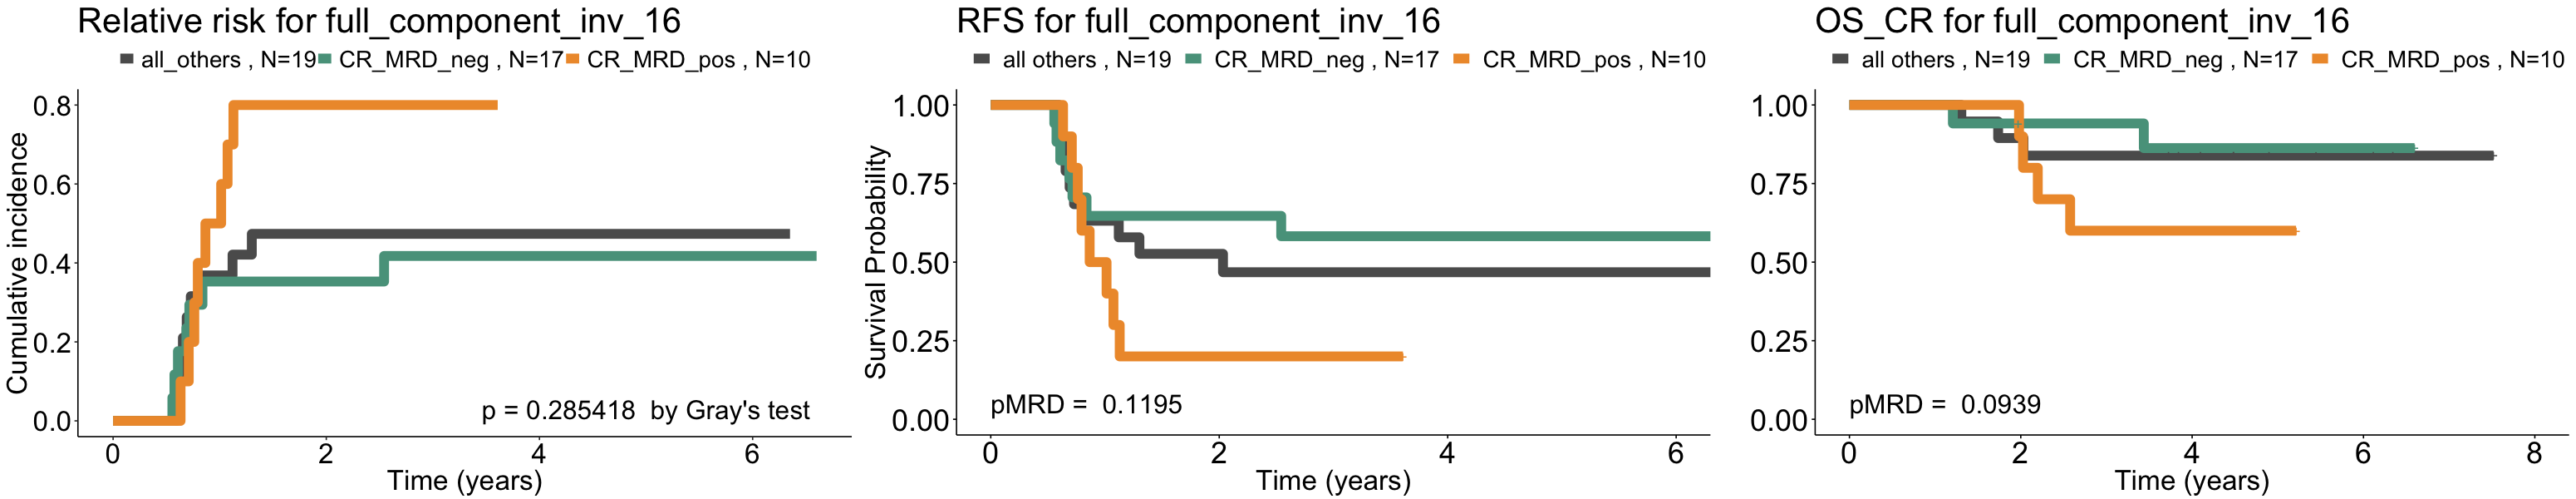

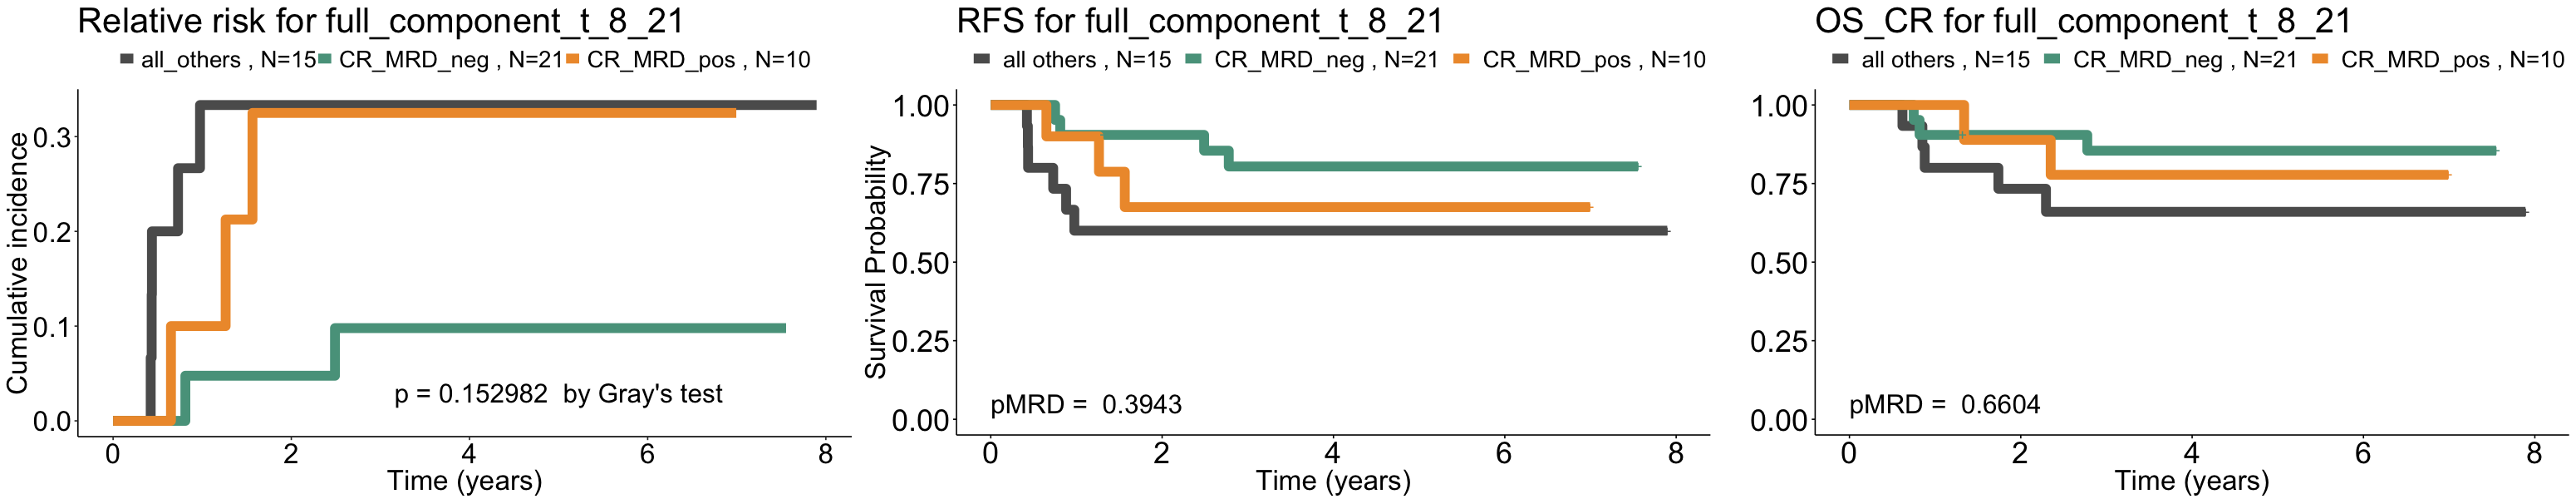

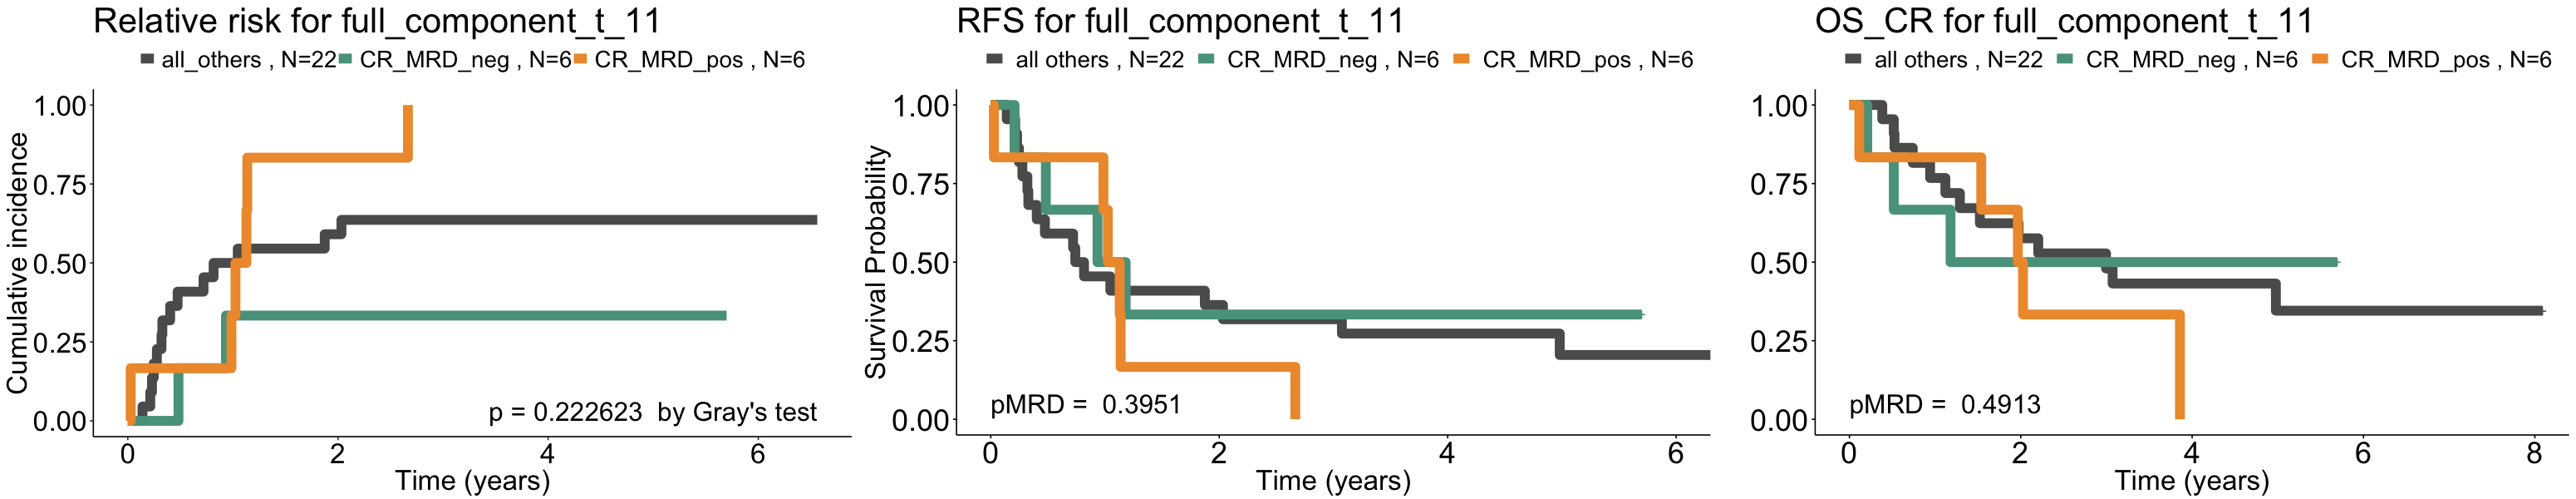

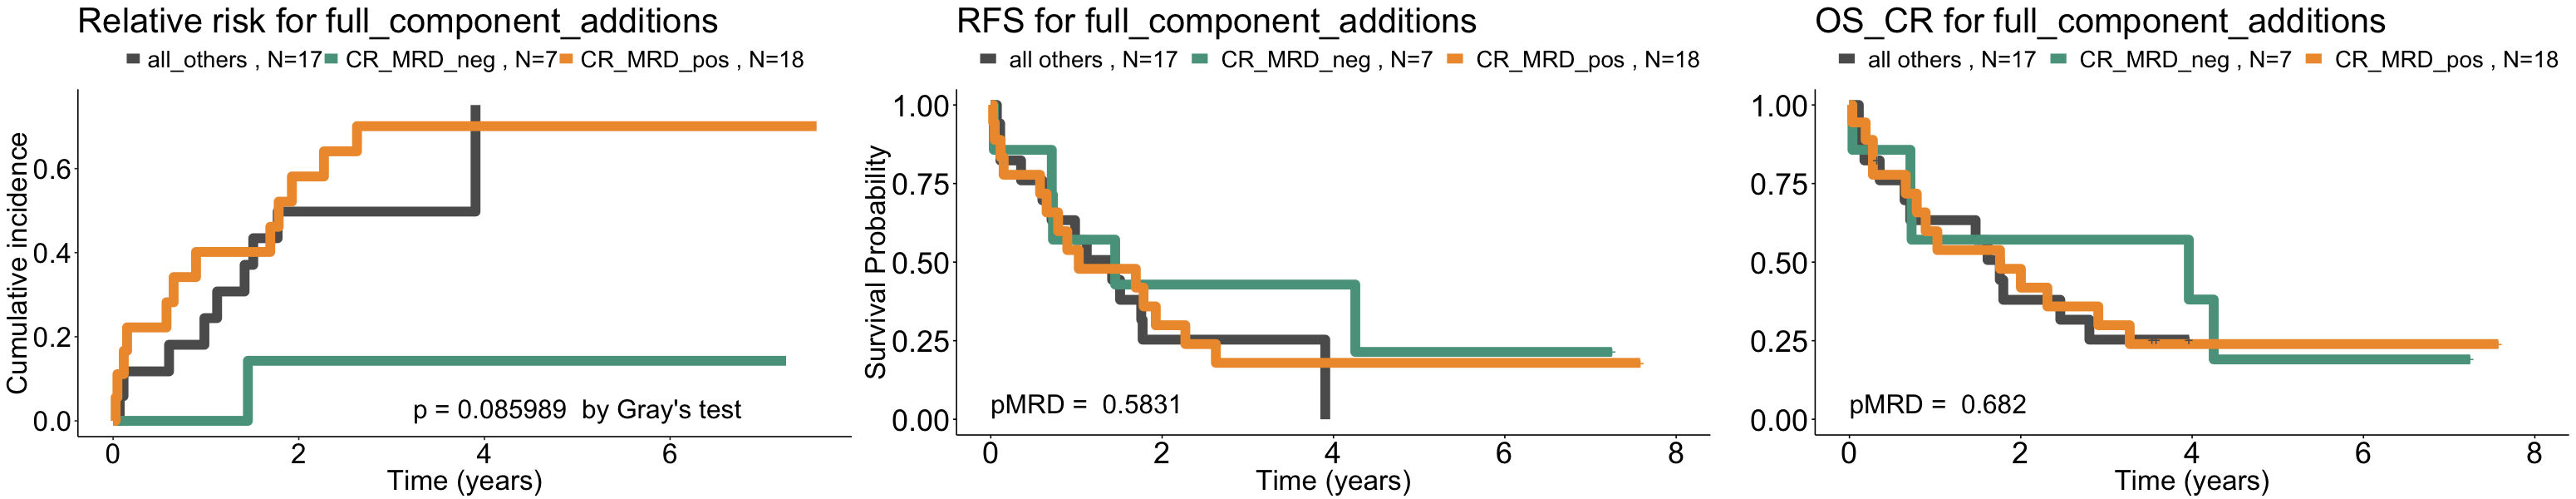

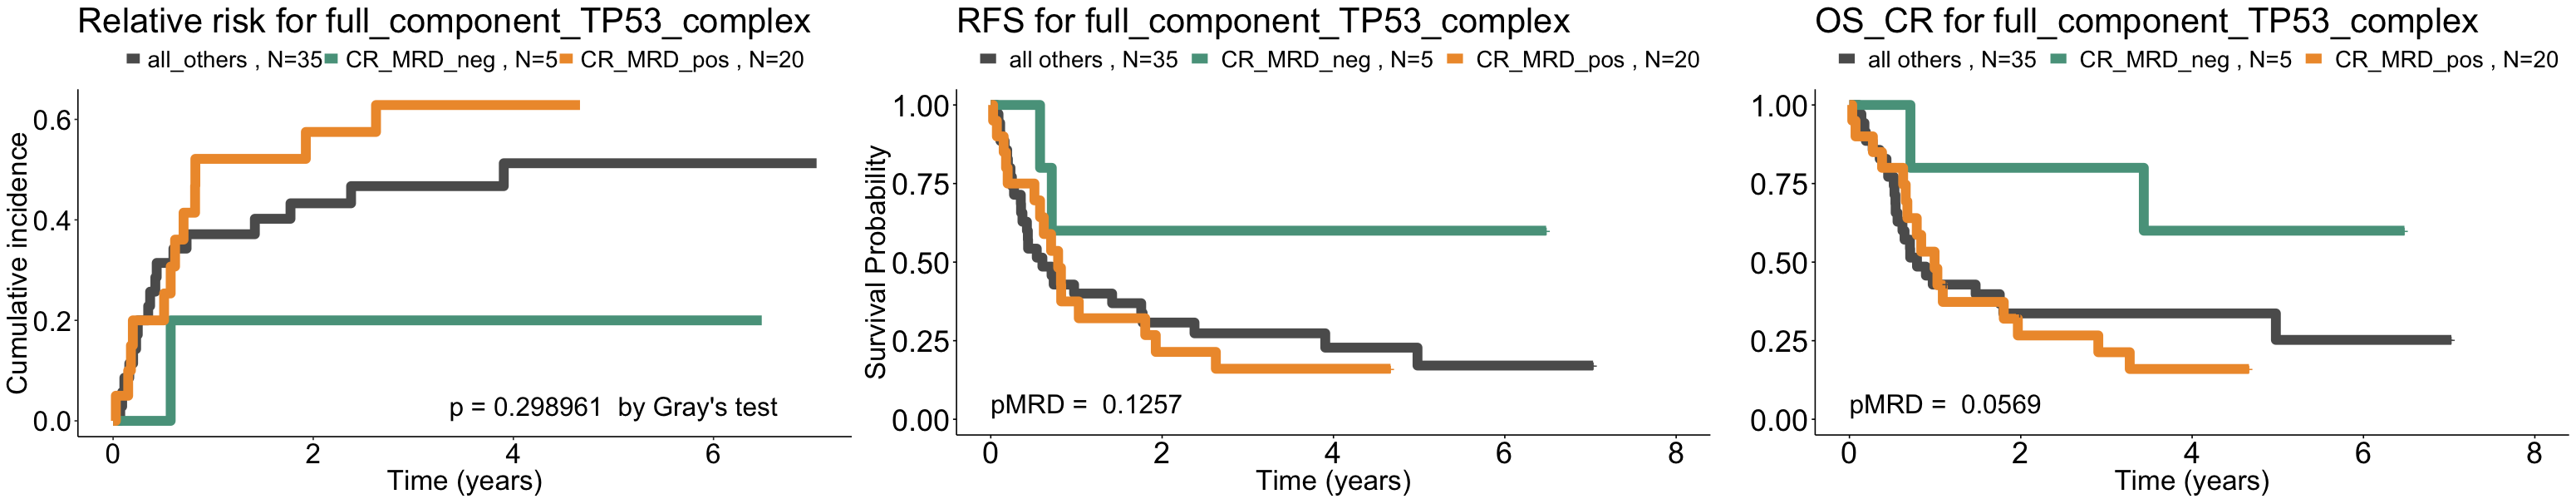

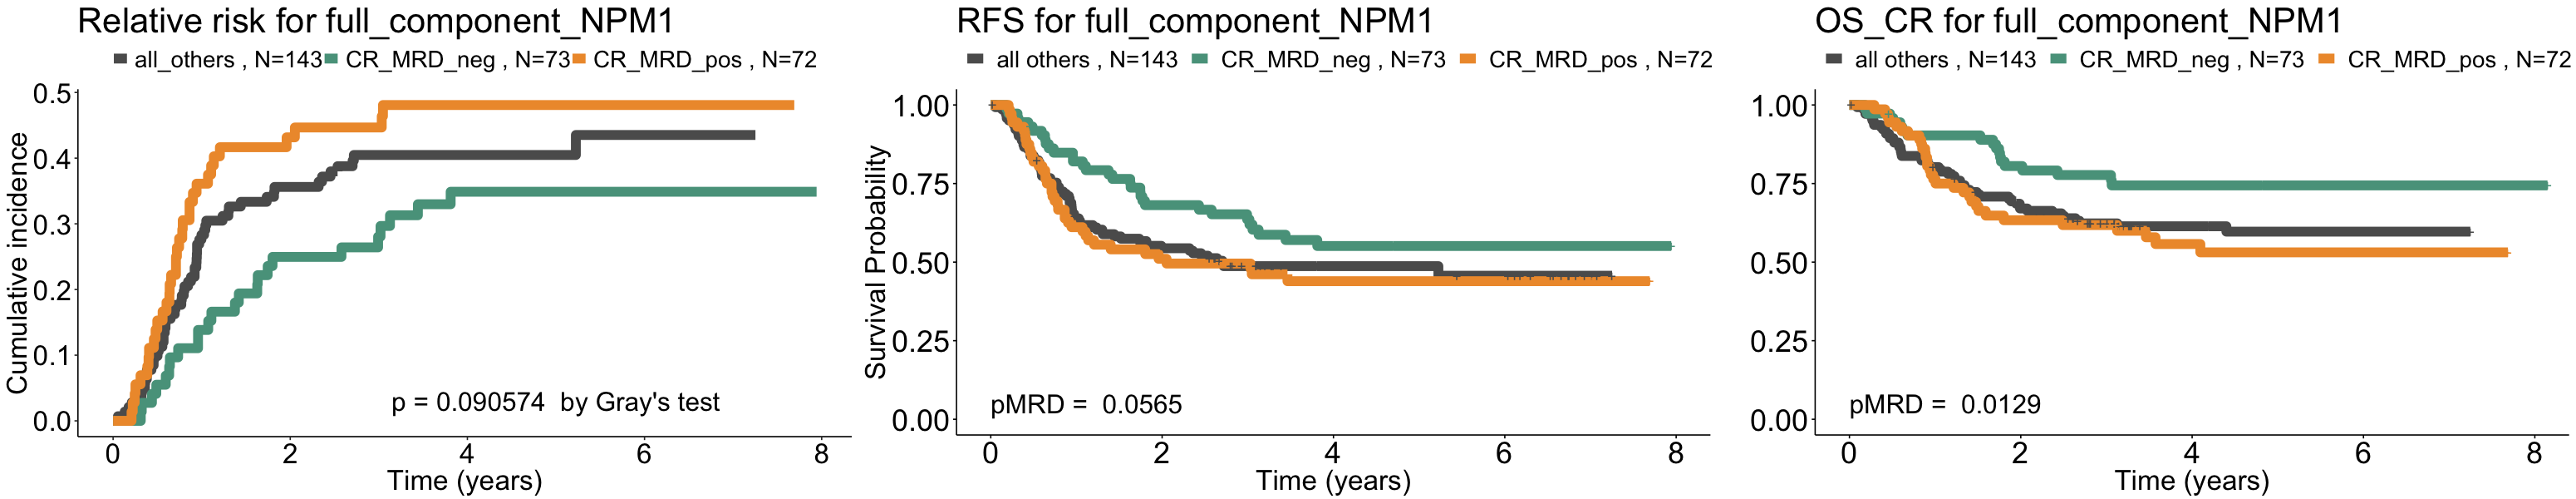

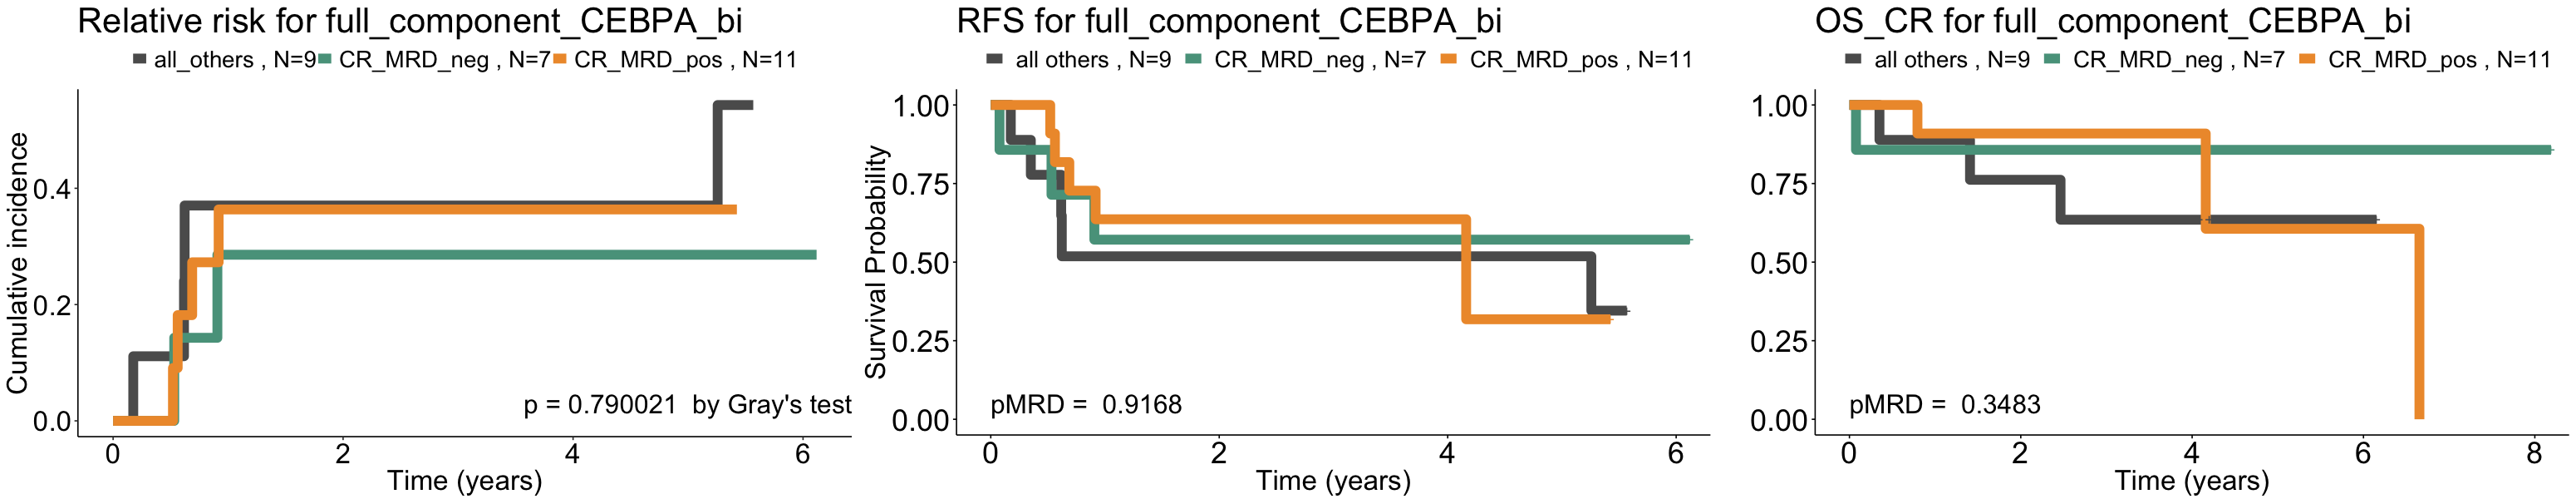

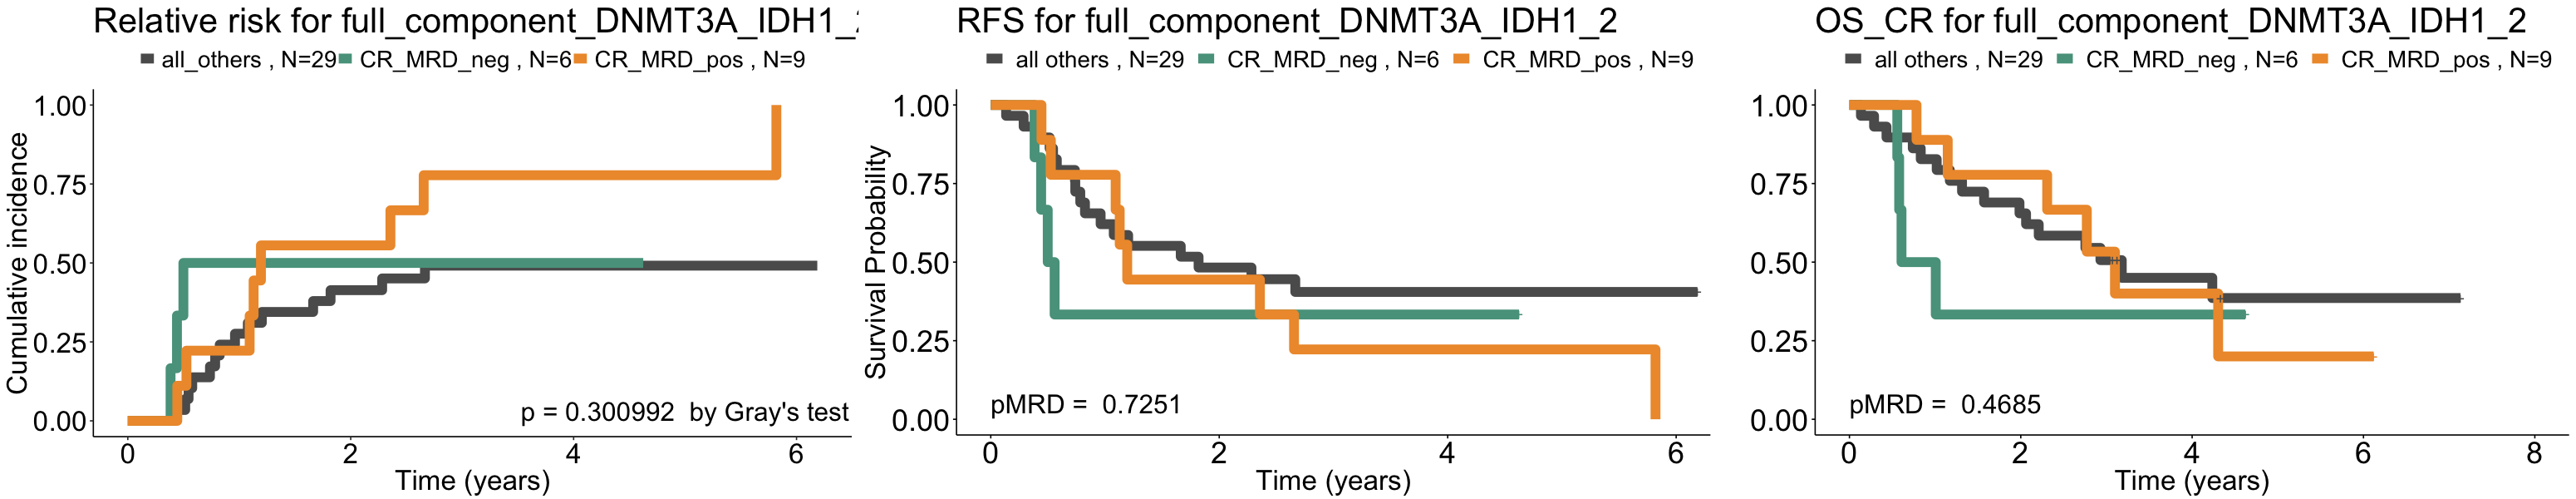

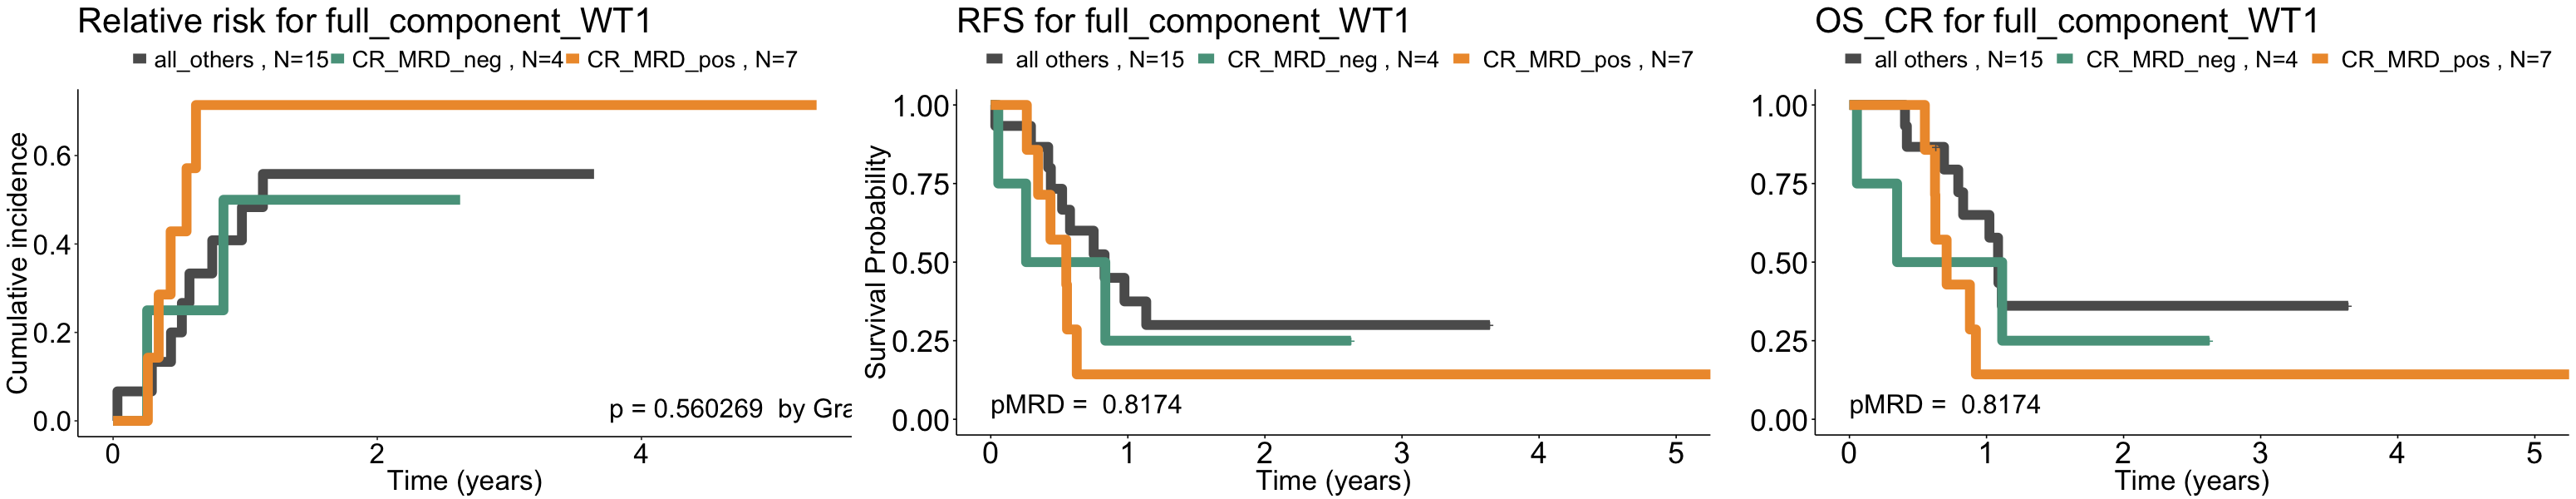

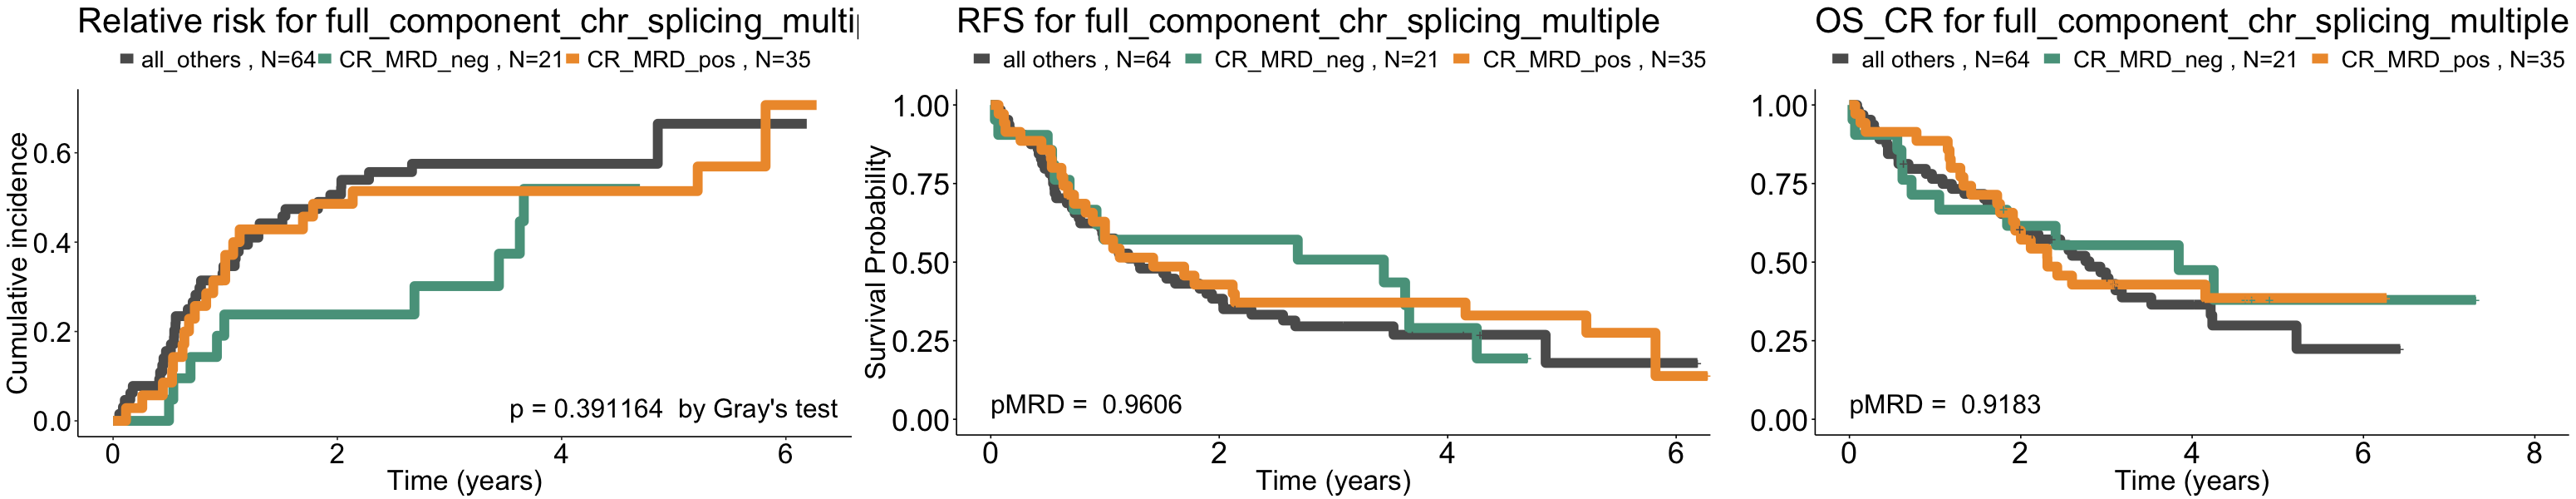

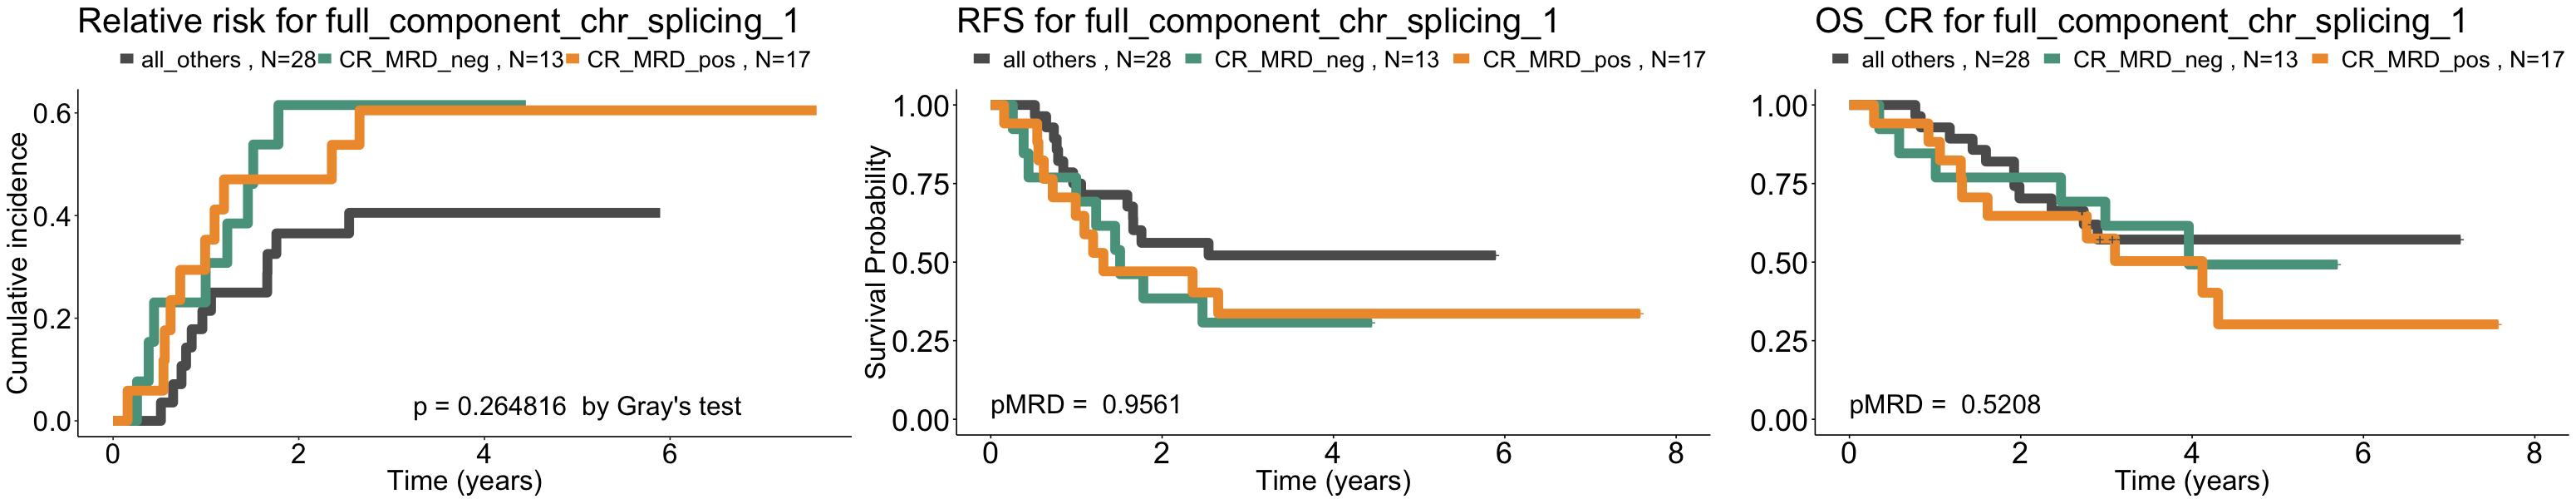

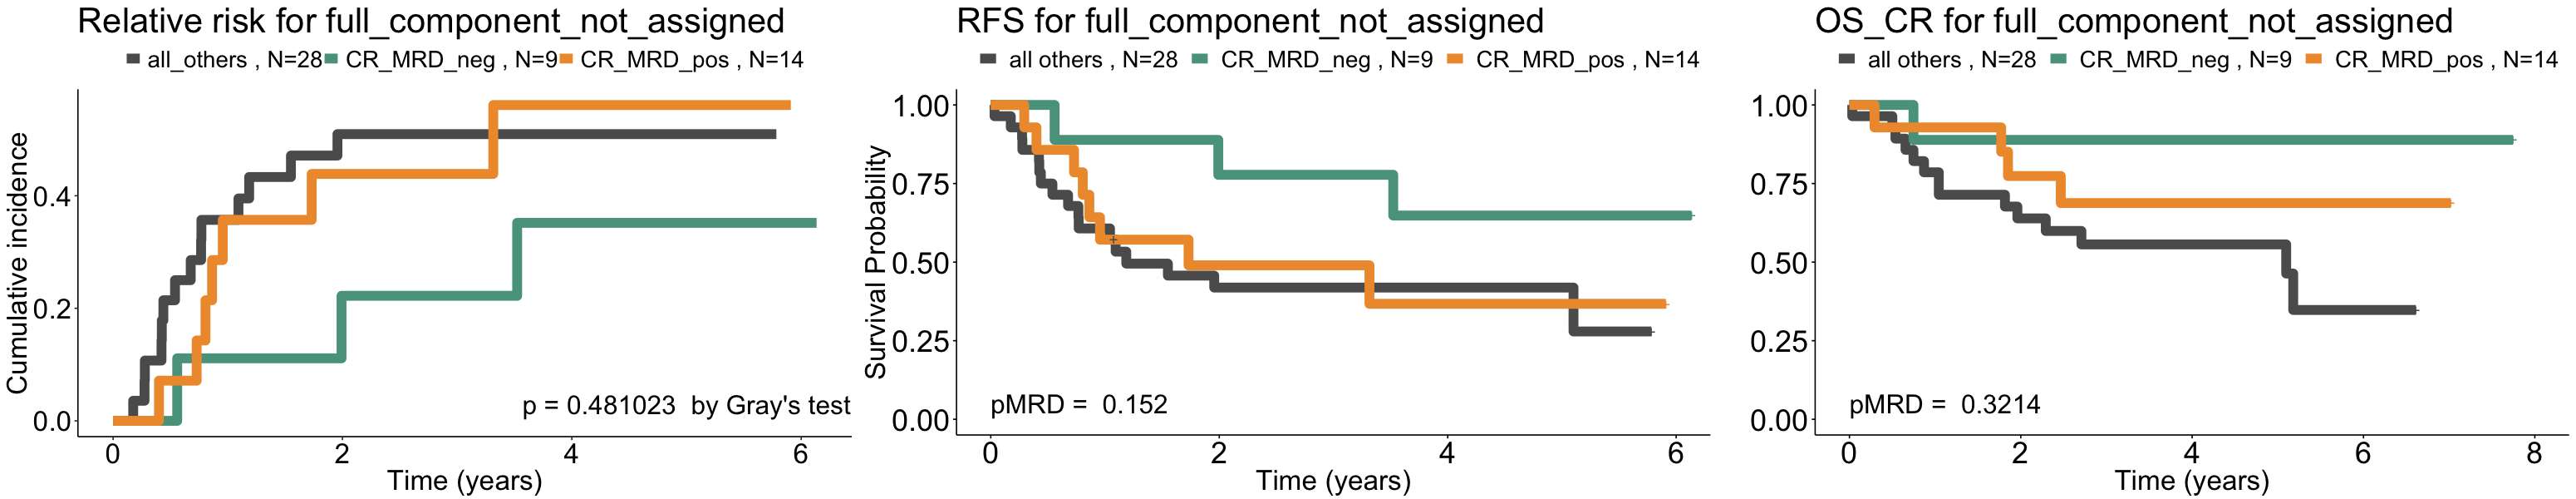

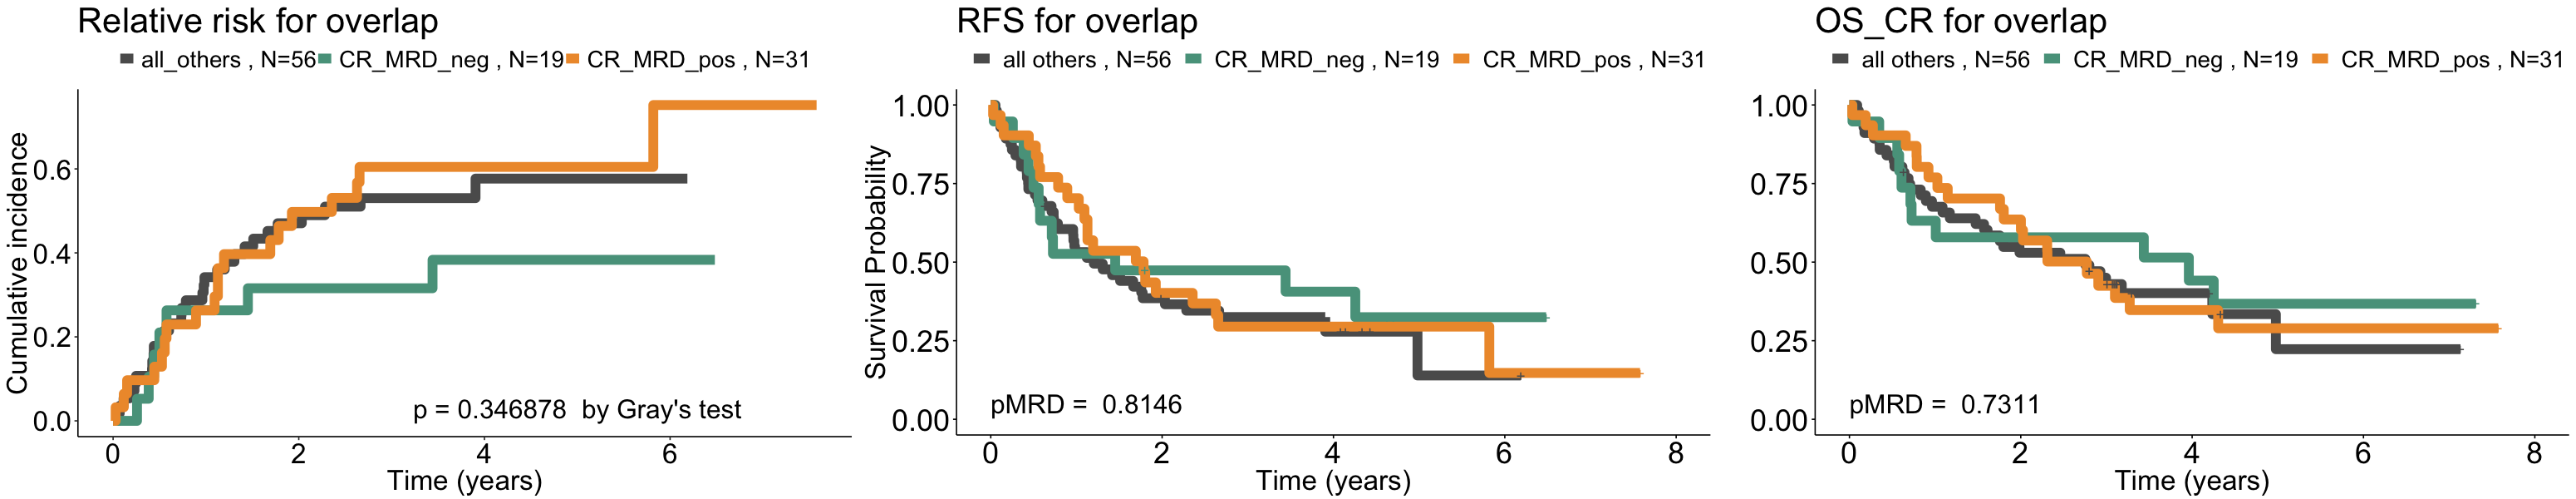

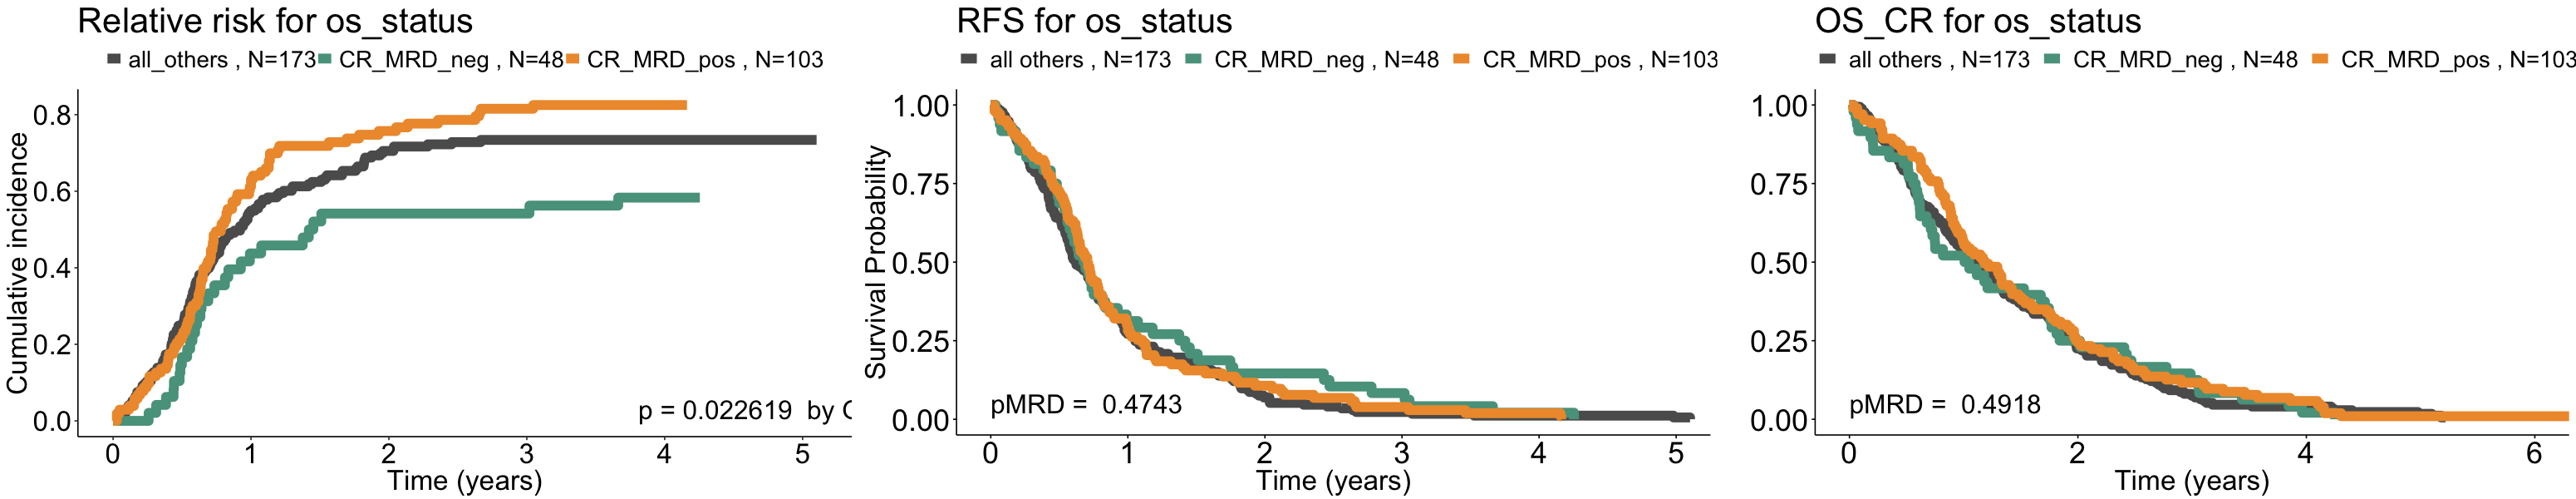

In [86]:
set_notebook_plot_size(31,6)
for (event in comp){
    tmp<- df_merge[df_merge[,event]==1,]
    if(nrow(tmp[tmp$CR_MRD_neg==1,])>=4 & nrow(tmp[tmp$CR_MRD_pos==1,])>=4){
        tmp$comparison <- ifelse(tmp$CR_MRD_neg==1,"CR_MRD_neg",
                            ifelse(tmp$CR_MRD_pos==1,"CR_MRD_pos","all others"))
        for (i in 1:2){
            if (i==1){
                res <- pairwise_survdiff(Surv(RFSyears,RFSStatus)~comparison,data = tmp[tmp$comparison %in% c("CR_MRD_neg","CR_MRD_pos"),])
                surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
            }  else  {
                res <- pairwise_survdiff(Surv(OS_CR,DEADStatus)~comparison,data = tmp[tmp$comparison %in% c("CR_MRD_neg","CR_MRD_pos"),])
                surv_object <- Surv(time = tmp$OS_CR, event = tmp$DEADStatus)

                }


            fit <- survfit(surv_object ~ comparison, data = tmp)
            p[[i]] <- plot_surv_curves(fit,y=ifelse(i==1,"Survival Probability",""),submain=paste(ifelse(i==1,"RFS for ","OS_CR for "),event,sep=""),font.legend=20,vals = c("#5C5C5C","#59A08B","#EE9937"),
                                      pval=ifelse(round(res$p.value[1],4)==0,"pMRD<0.0001",paste("pMRD = ",round(res$p.value[1],4))))
        }
        
    tmp_cr <- dd[dd[,event]==1,]
    tmp_cr$comparison <- ifelse(tmp_cr$CR_MRD_neg==1,"CR_MRD_neg",
                            ifelse(tmp_cr$CR_MRD_pos==1 ,"CR_MRD_pos","all_others"))

    cmfit = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
    tlg = table(tmp_cr$comparison[!is.na(tmp_cr$comp_sample_years)])
    myleg = paste0(" ", names(tlg)," , N=",tlg,"")

    cmfit.test = with(tmp_cr,cuminc(comp_sample_years,comp_status,comparison,cencode="censor"))
    pval = cmfit.test$Tests["relapse","pv"]

    cr <- gg_competingrisks.cuminc(cmfit,line.size=4,group.levels=names(tlg),title=paste("Relative risk for",event))+
    scale_color_manual(values=c("#5C5C5C","#59A08B","#EE9937"),labels=myleg)+
    theme(legend.key.width = unit(0.5,"cm"),axis.text.y=element_text(size=24),axis.text.x=element_text(size=24),axis.title.x = element_text(size=24),axis.title.y = element_text(size=24),
          plot.title = element_text(size=30),legend.title = element_text(size=20),legend.text = element_text(size=20))+
          theme(legend.title = element_blank())+annotate("text",label=paste("p","=",round(pval,6)," by Gray's test"),x=5,y=0.03,size=8)
        
    grid.arrange(cr,p[[1]]$plot,p[[2]]$plot,nrow=1)
    }
}



# STACKED FREQUENCY PROP GENE CYTO

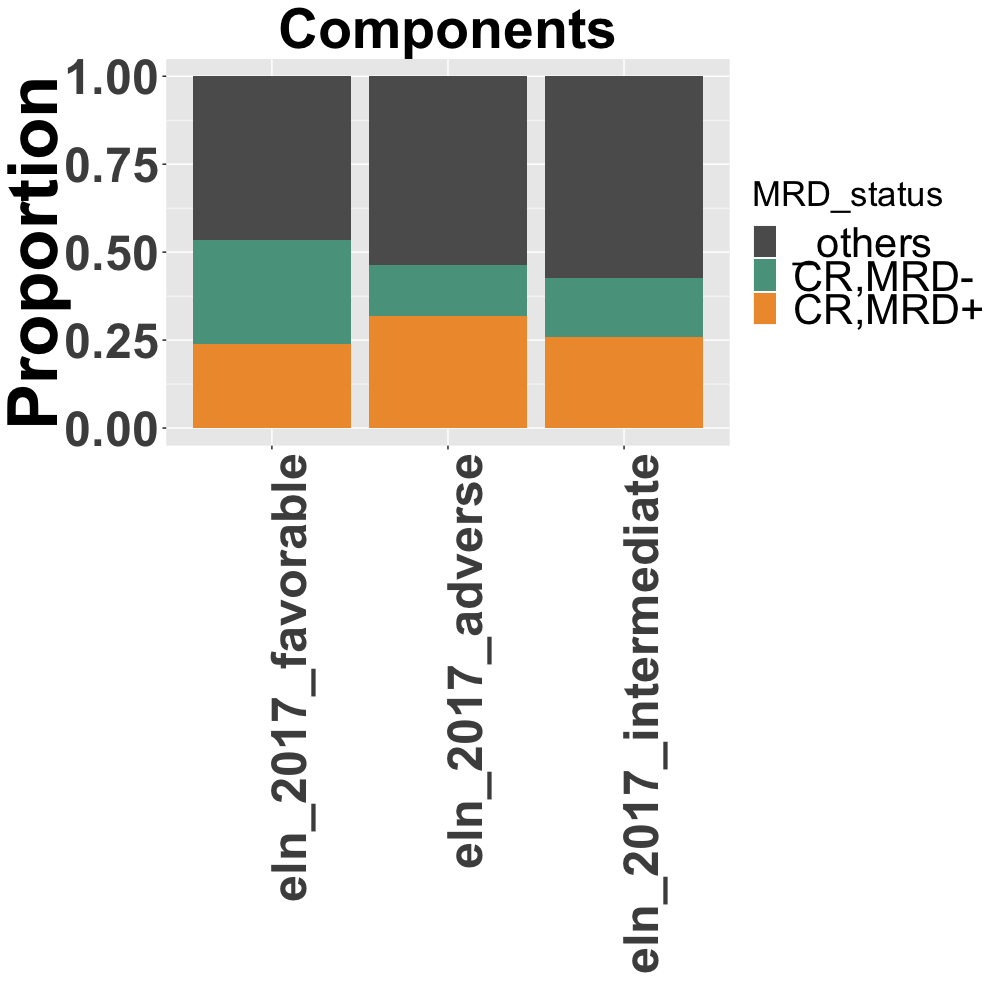

In [53]:
tmp <- NULL
for (co in c("eln_2017_adverse","eln_2017_intermediate","eln_2017_favorable")){
    if(nrow(df_merge[df_merge[,co]==1,])>0){
        tmp1 <- df_merge[df_merge[,co]==1,]
        tmp1$components <- co
        tmp <- rbind(tmp,tmp1)
    }
}
s <- ggplot(tmp,aes(x=reorder(components,components,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes( y=..count../tapply(..count.., ..x.. ,sum)[..x..],fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=35,face="bold",angle=90,hjust=1),axis.text.y = element_text(size=35,face="bold"),
      axis.title.y=element_text(size=50,face="bold"),legend.text=element_text(size=30),legend.title=element_text(size=25))+xlab("")+ylab("Proportion")+ggtitle("Components")
set_notebook_plot_size(10,10)
s

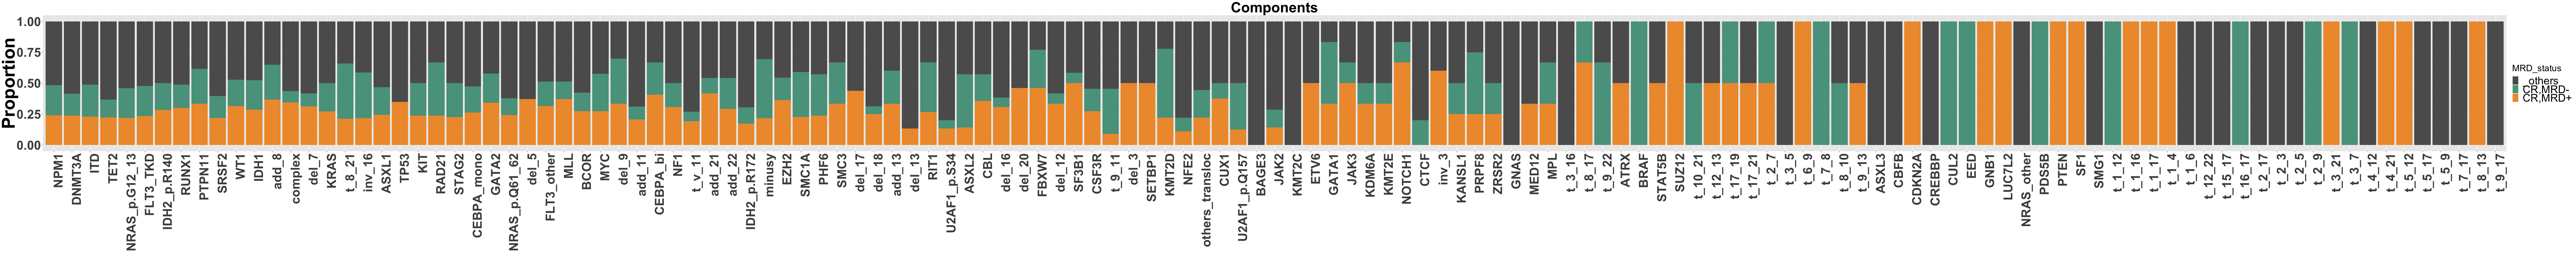

In [50]:
tmp <- NULL
for (co in c(genes,cytos)){
    if(nrow(df_merge[df_merge[,co]==1,])>0){
        tmp1 <- df_merge[df_merge[,co]==1,]
        tmp1$components <- co
        tmp <- rbind(tmp,tmp1)
    }
}
s <- ggplot(tmp,aes(x=reorder(components,components,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes( y=..count../tapply(..count.., ..x.. ,sum)[..x..],fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=35,face="bold",angle=90,hjust=1),axis.text.y = element_text(size=35,face="bold"),
      axis.title.y=element_text(size=50,face="bold"),legend.text=element_text(size=30),legend.title=element_text(size=25))+xlab("")+ylab("Proportion")+ggtitle("Components")
set_notebook_plot_size(100,10)
s

# STACKED FREQUENCY PROP COMP

In [145]:
tmp <- NULL    
library(dplyr)
library(tidyr)
for (co in comp){
    tmp1 <- df_merge[df_merge[,co]==1,]
    tmp1$components <- str_replace(co,"full_component_","")
    tmp <- rbind(tmp,tmp1)
}
s <- ggplot(tmp,aes(x=reorder(components,components,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes( y=..count../tapply(..count.., ..x.. ,sum)[..x..],fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=35,face="bold",angle=90,hjust=1),axis.text.y = element_text(size=35,face="bold"),
      axis.title.y=element_text(size=50,face="bold"),legend.text=element_text(size=30),legend.title=element_text(size=25))+xlab("")+ylab("Proportion")+ggtitle("Components")

png("MRD_stacked_prop.png",width=5000,height=5000,res=250) 
s
dev.off()

pdf 
  2

# CORRELATES FOR MRD

In [96]:

tmp <- df_merge
tmp$eln_2017 <- ifelse(df_merge$eln_2017==1,"adverse",
                           ifelse(df_merge$eln_2017==2,"intermediate","favorable"))
p <- ggplot(tmp,aes(x=reorder(eln_2017,eln_2017,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes(fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=20,face="bold"),axis.text.y = element_text(size=20,face="bold"),
      axis.title.y=element_text(size=30,face="bold"),legend.text=element_text(size=25),legend.title=element_text(size=25),legend.position="top")+xlab("")+ylab("Count")+ggtitle("ELN")

tmp <- df_merge
tmp$perf_status <- factor(tmp$perf_status)
tmp$eln_2017 <- ifelse(df_merge$eln_2017==1,"adverse",
                           ifelse(df_merge$eln_2017==2,"intermediate","favorable"))
q <- ggplot(tmp,aes(x=reorder(perf_status,perf_status,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes(fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=20,face="bold"),axis.text.y = element_text(size=20,face="bold"),
      axis.title.y=element_text(size=30,face="bold"),legend.text=element_text(size=25),legend.title=element_text(size=25),legend.position="none")+xlab("")+ylab("Count")+ggtitle("Perf status")

tmp <- df_merge
tmp$age_comparison <- ifelse(tmp$age<=50,"less than 50","more than 50")

r <- ggplot(tmp,aes(x=reorder(age_comparison,age_comparison,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes(fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=20,face="bold"),axis.text.y = element_text(size=20,face="bold"),
      axis.title.y=element_text(size=30,face="bold"),legend.text=element_text(size=25),legend.title=element_text(size=25),legend.position="none")+xlab("")+ylab("Count")+ggtitle("Age stratified at 50 (median)")

tmp <- NULL                         
for (co in comp){
    tmp1 <- df_merge[df_merge[,co]==1,]
    tmp1$components <- str_replace(co,"full_component_","")
    tmp <- rbind(tmp,tmp1)
}

s <- ggplot(tmp,aes(x=reorder(components,components,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes(fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=20,face="bold",angle=90,hjust=1),axis.text.y = element_text(size=20,face="bold"),
      axis.title.y=element_text(size=30,face="bold"),legend.text=element_text(size=25),legend.title=element_text(size=25),legend.position="none")+xlab("")+ylab("Count")+ggtitle("Components")
                              
png("stratification_MRD.png",width=5000,height=5000,res=250)
grid.arrange(s,nrow=1)
dev.off()

pdf 
  2

# STRAT BY COMP

In [97]:
options(warn=-1)
set_notebook_plot_size(30,10)
comp <- colnames(df_merge[,170:186])
# pdf("graphs/MRD/components_MRD.pdf",22,6)
for (ev in comp){
    png(paste(ev,"_MRD.png",sep=""),width=7000,height=2500,res=250)
    tmp<- df_merge[df_merge[,ev]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    try(suppressWarnings(plots_KM_MRD(tmp=tmp,fit=fit,strat=str_replace(ev,"full_component_",""),leg.labs=c(paste("_others",nrow(tmp[(tmp$MRD_status=="_others") & !is.na(tmp$OS_CR),]),sep=", n="),
                                                     paste("CR,MRD-",nrow(tmp[(tmp$MRD_status=="CR,MRD-") & !is.na(tmp$OS_CR),]),sep=", n="),paste("CR,MRD+",nrow(tmp[(tmp$MRD_status=="CR,MRD+") & !is.na(tmp$OS_CR),]),sep=", n=")))))
    dev.off()
    }

Error in ggsurvplot_df(d, fun = fun, color = color, palette = palette,  : 
  The length of legend.labs should be 1
Error in ggsurvplot_df(d, fun = fun, color = color, palette = palette,  : 
  The length of legend.labs should be 1
Error in ggsurvplot_df(d, fun = fun, color = color, palette = palette,  : 
  The length of legend.labs should be 2
Error in ggsurvplot_df(d, fun = fun, color = color, palette = palette,  : 
  The length of legend.labs should be 1


# STRAT BY GENE AND CYTO

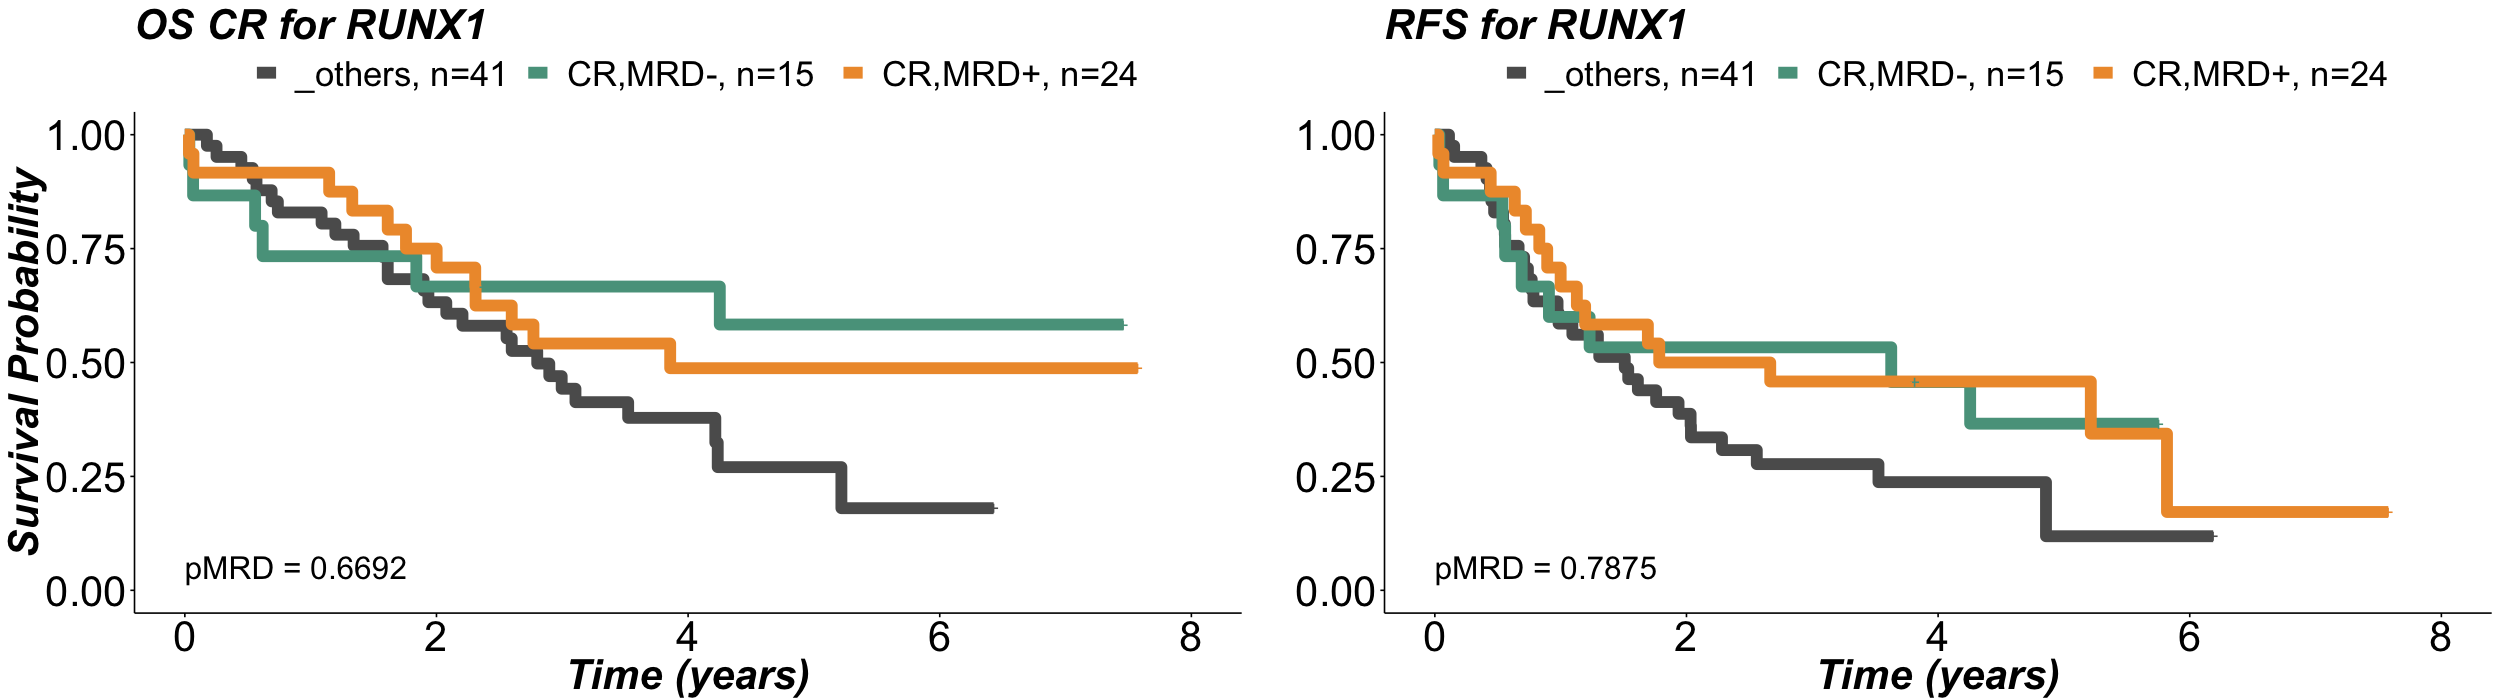

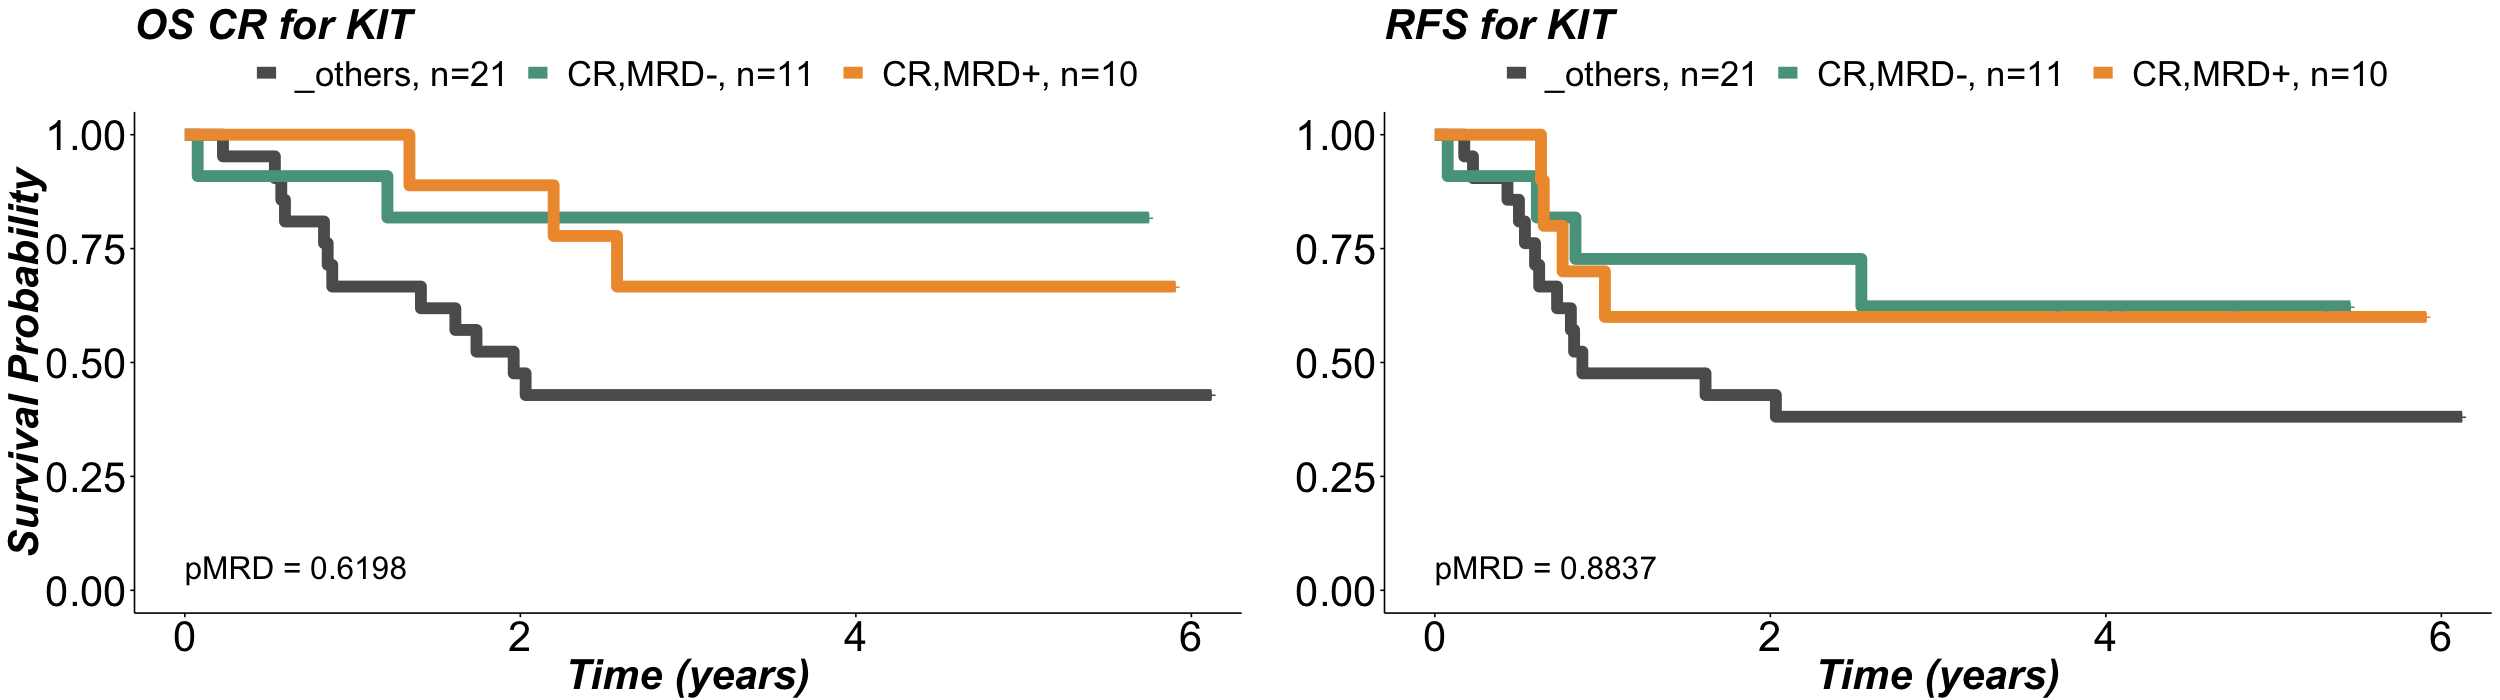

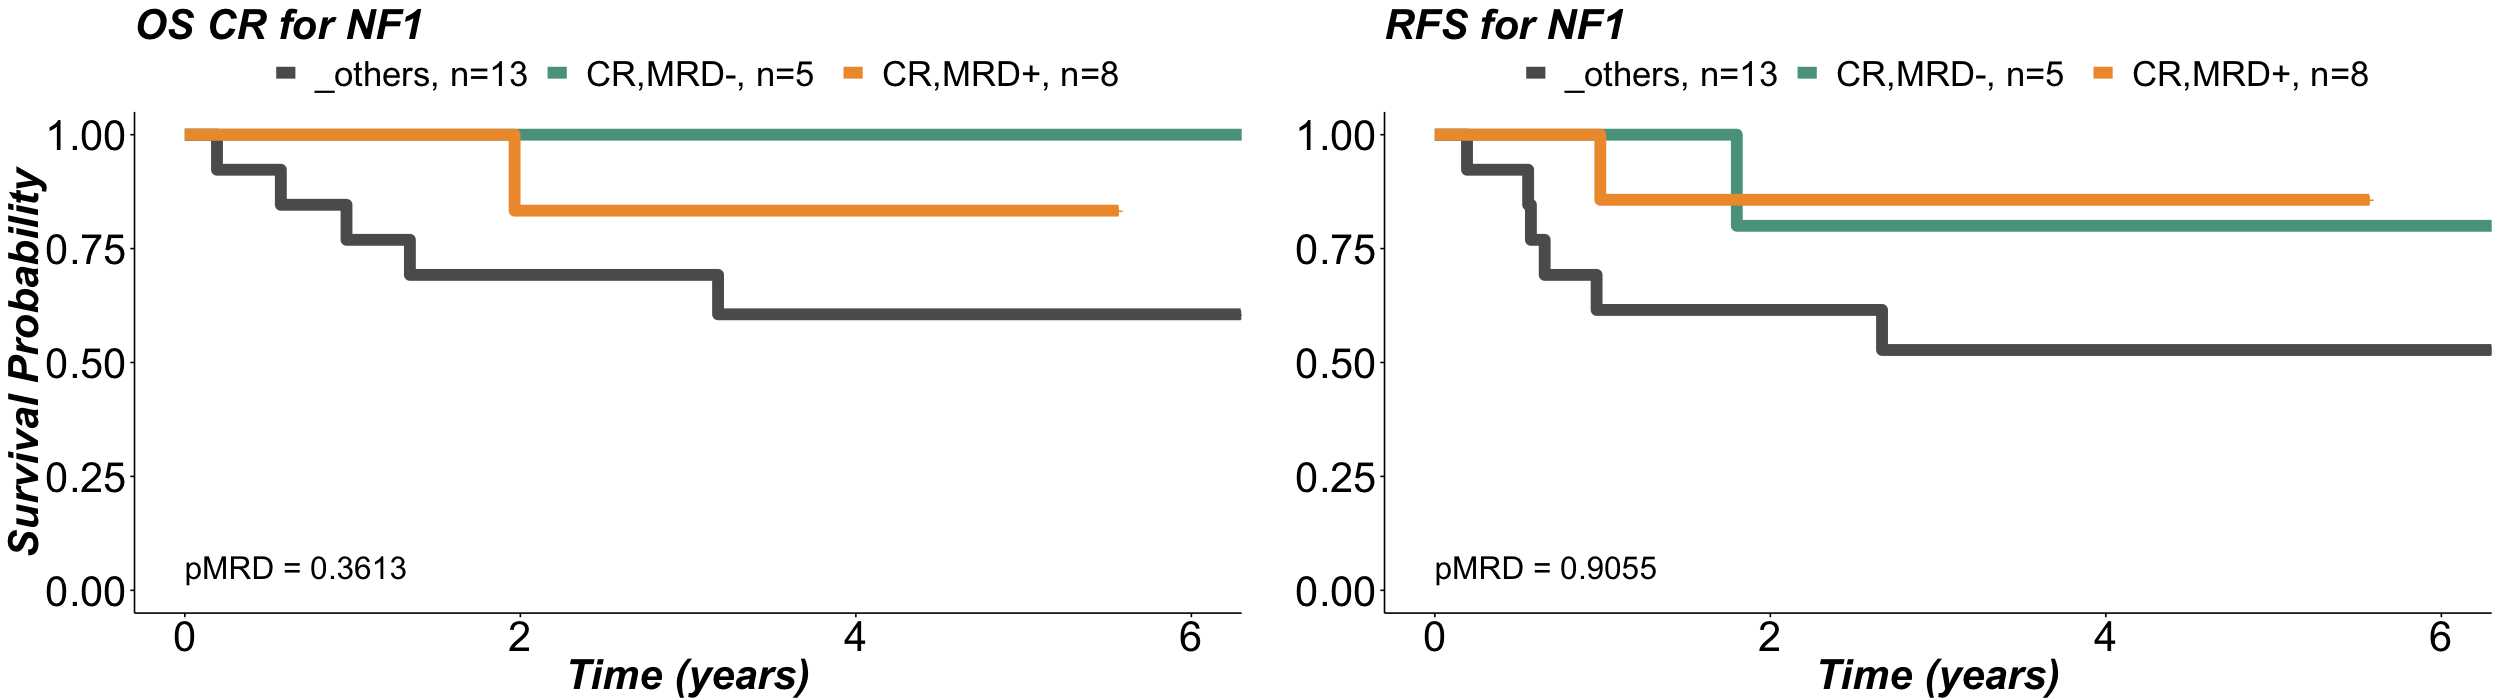

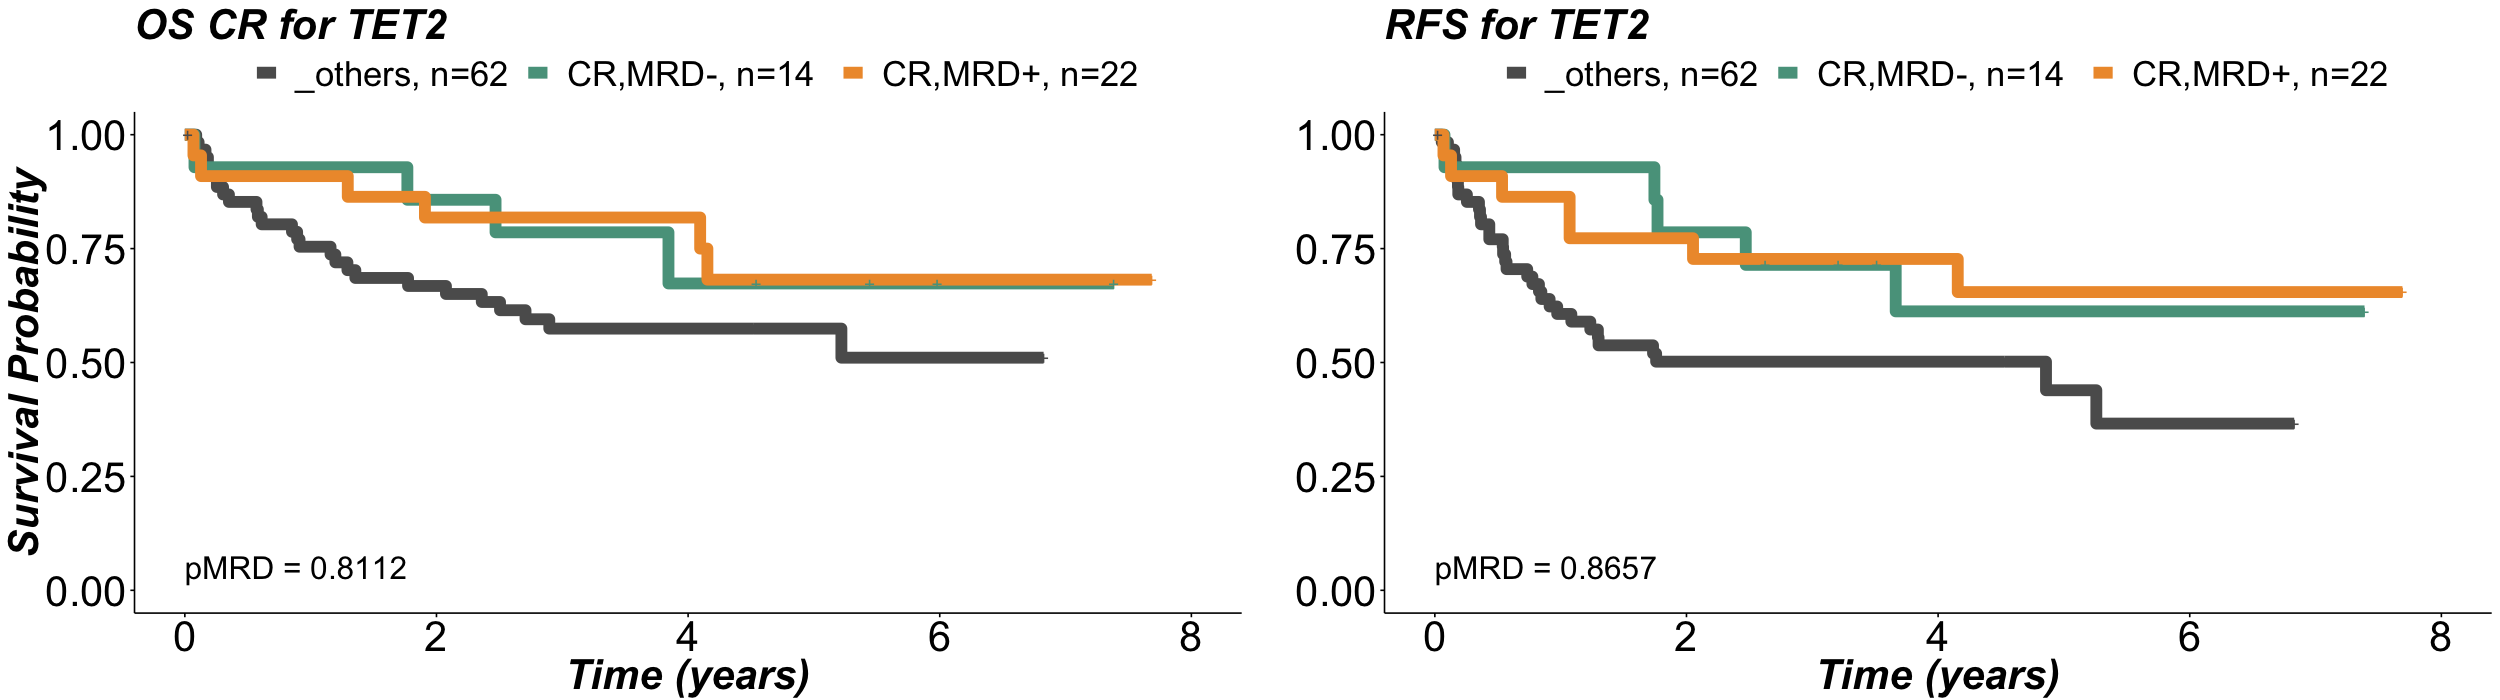

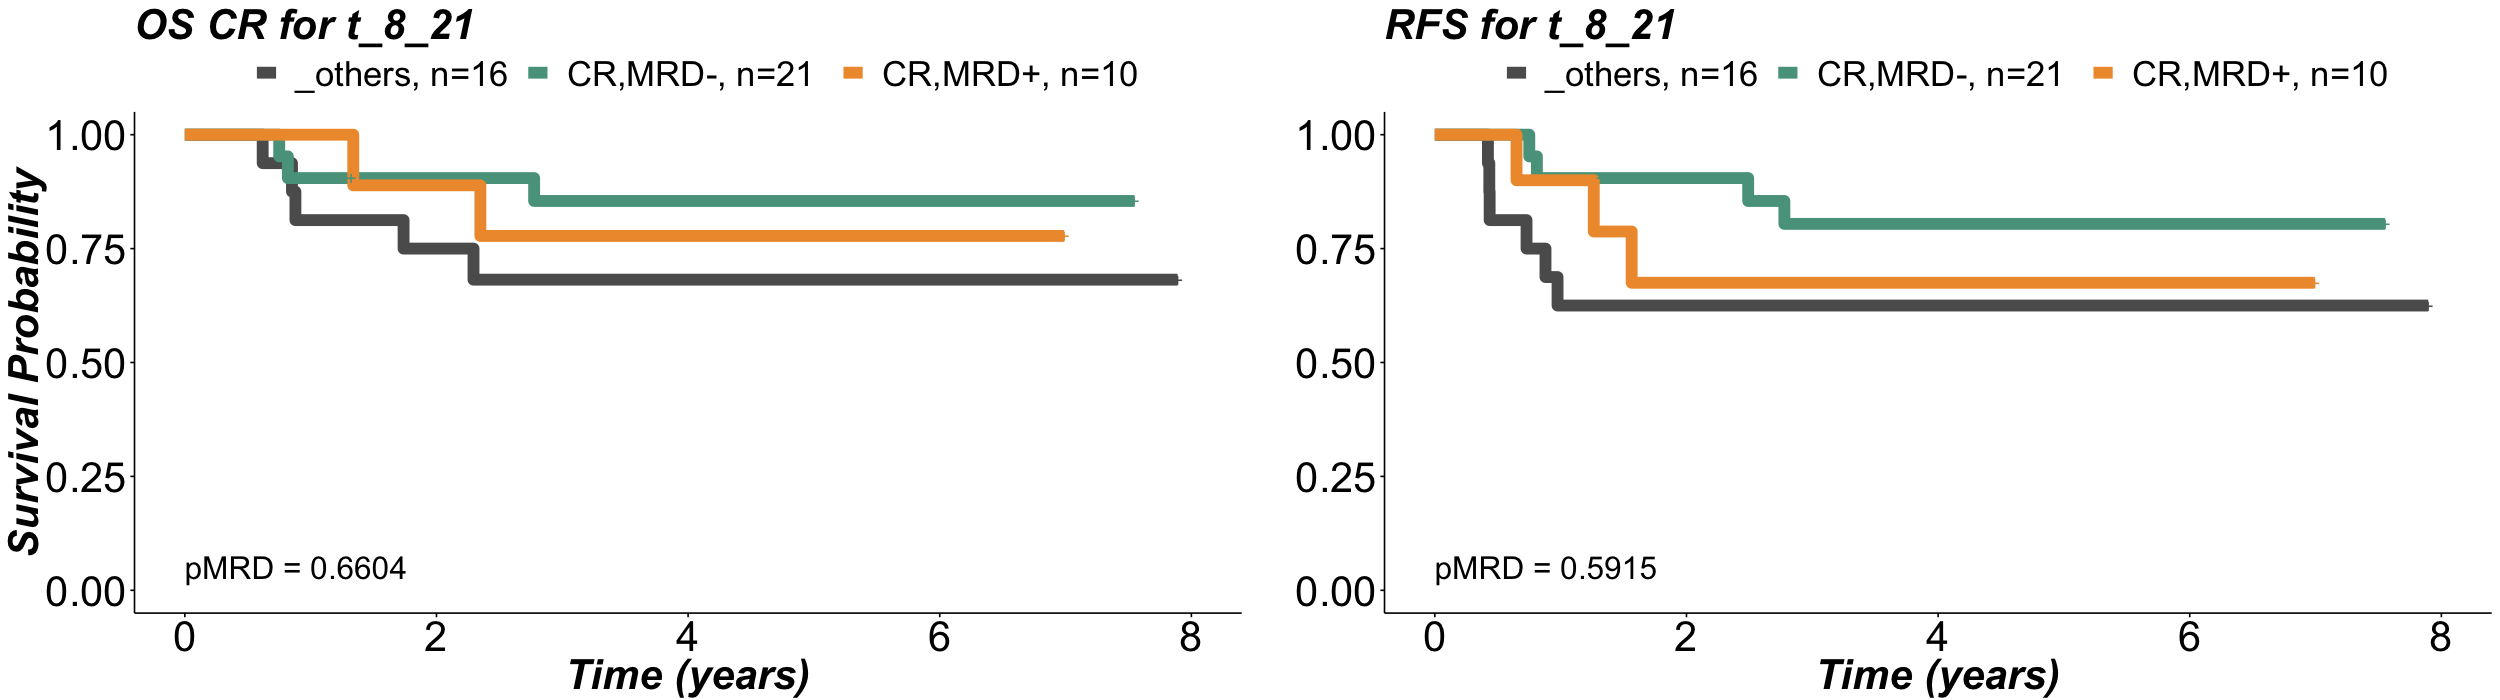

In [227]:
gene_cyto <- colnames(df_merge[,c(5:158)])
gene_cyto <-c("RUNX1","KIT","NF1","TET2","t_8_21")
# pdf("graphs/MRD/gene_cyto_MRD.pdf",22,6)

set_notebook_plot_size(25,7)
for (event in gene_cyto){
    tmp<- df_merge[df_merge[,event]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    p[[event]] <- try(suppressWarnings(plots_KM_MRD(tmp=tmp,fit=fit,strat=event,leg.labs=c(paste("_others",nrow(tmp[(tmp$MRD_status=="_others") & !is.na(tmp$OS_CR),]),sep=", n="),
                                                     paste("CR,MRD-",nrow(tmp[(tmp$MRD_status=="CR,MRD-") & !is.na(tmp$OS_CR),]),sep=", n="),paste("CR,MRD+",nrow(tmp[(tmp$MRD_status=="CR,MRD+") & !is.na(tmp$OS_CR),]),sep=", n=")))))
    }
# dev.off()

In [244]:
png("MRD_pos.png",width=5000,height=5000,res=200)
grid.arrange(p$RUNX1,p$KIT,p$NF1,p$TET2,p$t_8_21,nrow=5)
dev.off()

pdf 
  2

# END

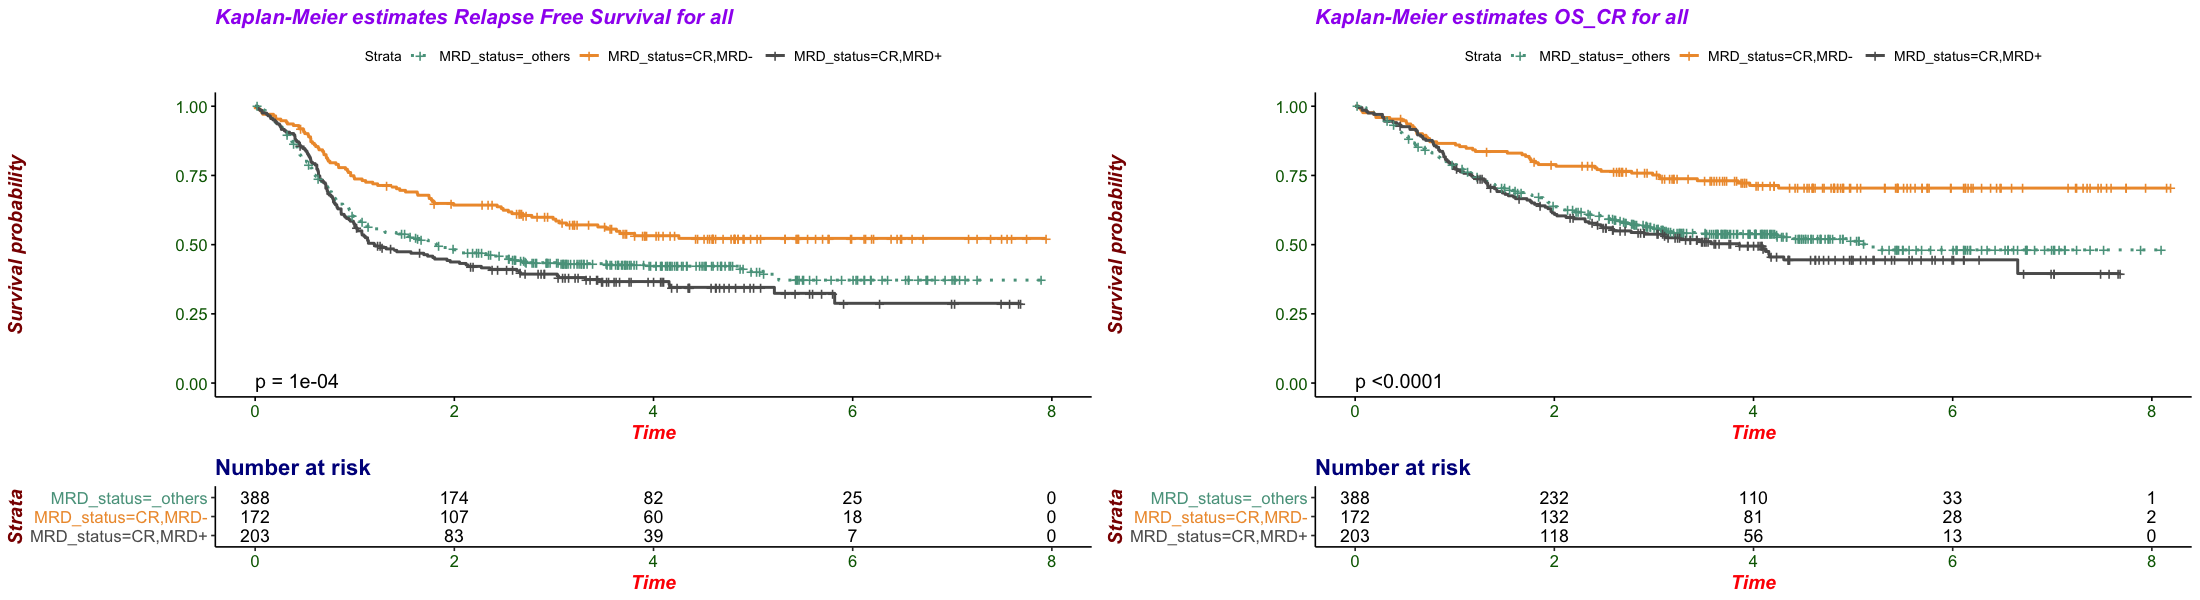

In [122]:
# pdf("graphs/MRD/overall_MRD.pdf",22,6)
tmp<- df_merge
surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
fit <- survfit(surv_object ~ MRD_status, data = tmp)
plots_KM_MRD(tmp,fit)
# dev.off()

# CR MRD Stratification by component

In [ ]:
comp <- colnames(df_merge[,170:192])
# pdf("graphs/MRD/components_MRD.pdf",22,6)
for (ev in comp){
    tmp<- df_merge[df_merge[,ev]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    plots_KM_MRD(tmp=tmp,fit=fit,strat=ev)
    }
# dev.off()

# CR MRD Special Selection Positive no matter MRD

In [ ]:
set_notebook_plot_size(22,6)
# pdf("graphs/MRD/interesting_good_MRD.pdf",22,6)
gene_cyto_pos <- c("CEBPA_bi","KIT","MYC","NF1","TET2","t_8_21")
for (ev in gene_cyto_pos){
    tmp<- df_merge[df_merge[,ev]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    plots_KM_MRD(tmp=tmp,fit=fit,strat=ev)
    }
# dev.off()

# CR MRD Special Selection Negative no matter MRD

In [ ]:
set_notebook_plot_size(22,6)
gene_cyto_neg <- c("SRSF2","STAG2","WT1","minusy")
# pdf("graphs/MRD/interesting_poor_MRD.pdf",22,6)
for (ev in gene_cyto_neg){
    tmp<- df_merge[df_merge[,ev]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    plots_KM_MRD(tmp=tmp,fit=fit,strat=ev)
    }
# dev.off()

# CR MRD Stratification by genes and cyto events

In [108]:
set_notebook_plot_size(22,6)
gene_cyto <- colnames(df_merge[,c(5:158)])
pdf("graphs/MRD/gene_cyto_MRD.pdf",22,6)
for (event in gene_cyto){
    tmp<- df_merge[df_merge[,event]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    plots_KM_MRD(tmp=tmp,fit=fit,strat=event)
    }
dev.off()

pdf 
  2

# I) INVESTIGATION OF MRD STATUS EFFECT FOR RFS AND OS

In [120]:
library(dummies)
tmp <- df_merge
tmp <-cbind(tmp, dummy(tmp$MRD_status, sep = "_"))
tmp <- tmp %>% rename(CR_MRD_neg = "NA_CR,MRD-", CR_MRD_pos = "NA_CR,MRD+")


In [141]:
## Volcano Plot Univariate
library(ggrepel)  
df <- data.frame(hazard = double(),pvalue = double(),Frequency = double() )
data <- tmp

for (col in c('CR_MRD_neg','CR_MRD_pos',clin,demo)){
    surv_object <- Surv(time = data$os, event = data$os_status)
    fit <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       col)), data = data)

    df[col,1:3] <- c(summary(fit)$coef[2],summary(fit)$sctest[["pvalue"]],100*sum(data[,col])/dim(data)[1])                 
     }
df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
df[,"log2(hazard)"] <- log(df$hazard,2)
df["names"] <- rownames(df)
df$Model <- ifelse(df$names %in% genes,"gen",
                  ifelse(df$names %in% cytos,"cyto",
                        ifelse(df$names %in% clin, "clin",
                              ifelse(df$names %in% demo, "demo",
                                    ifelse(df$names %in% eln, "eln","comp")))))
df$Frequency <- ifelse(df$names %in% clin, 5,
                              ifelse(df$names %in% demo, 5, df$Frequency))

colors_analysis <- c(gen="#BFBFBF",cyto="#2b8cbe")
df <- df[order(df$adjusted_pvalue),]
s <- ggplot(df, aes(log2(hazard), -log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
    geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["adjusted_pvalue"]<0.1) | (df["log2(hazard)"]< -18),], aes(label=names,fontface=2))+scale_size_continuous(range = c(3,12)) + 
     scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))  + theme(legend.position="none")


## Multivariate Plot

data <- tmp
df_multi <- NULL
i <- 1
for (i in c(1:100)){
    res1 <- cv.glmnet(data.matrix(data[,c('CR_MRD_neg','CR_MRD_pos',clin,demo)]), Surv(data$os,data$os_status), family="cox",alpha=1,nfolds=10)
    df_multi <- cbind(df_multi,as.matrix(coef(res1,s="lambda.min")))
    i <- i+1
    }

l <- data.frame(coef = rowSums(df_multi)/100)
l$names <- rownames(l)
l$Model <- ifelse(l$names %in% gen,"gen",
              ifelse(l$names %in% cyto,"cyto",
                    ifelse(l$names %in% clin, "clin",
                          ifelse(l$names %in% demo, "demo",
                                ifelse(l$names %in% eln,
                                       "eln","comp")))))
t <- ggplot(l[l$coef!=0,],aes(x=names,y=coef,fill=Model))+geom_bar(stat="identity")+coord_flip()+
theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))#+
# scale_fill_manual(values=colors_analysis,limits=names(colors_analysis))
    


Warning message:
“Removed 11 rows containing missing values (geom_point).”

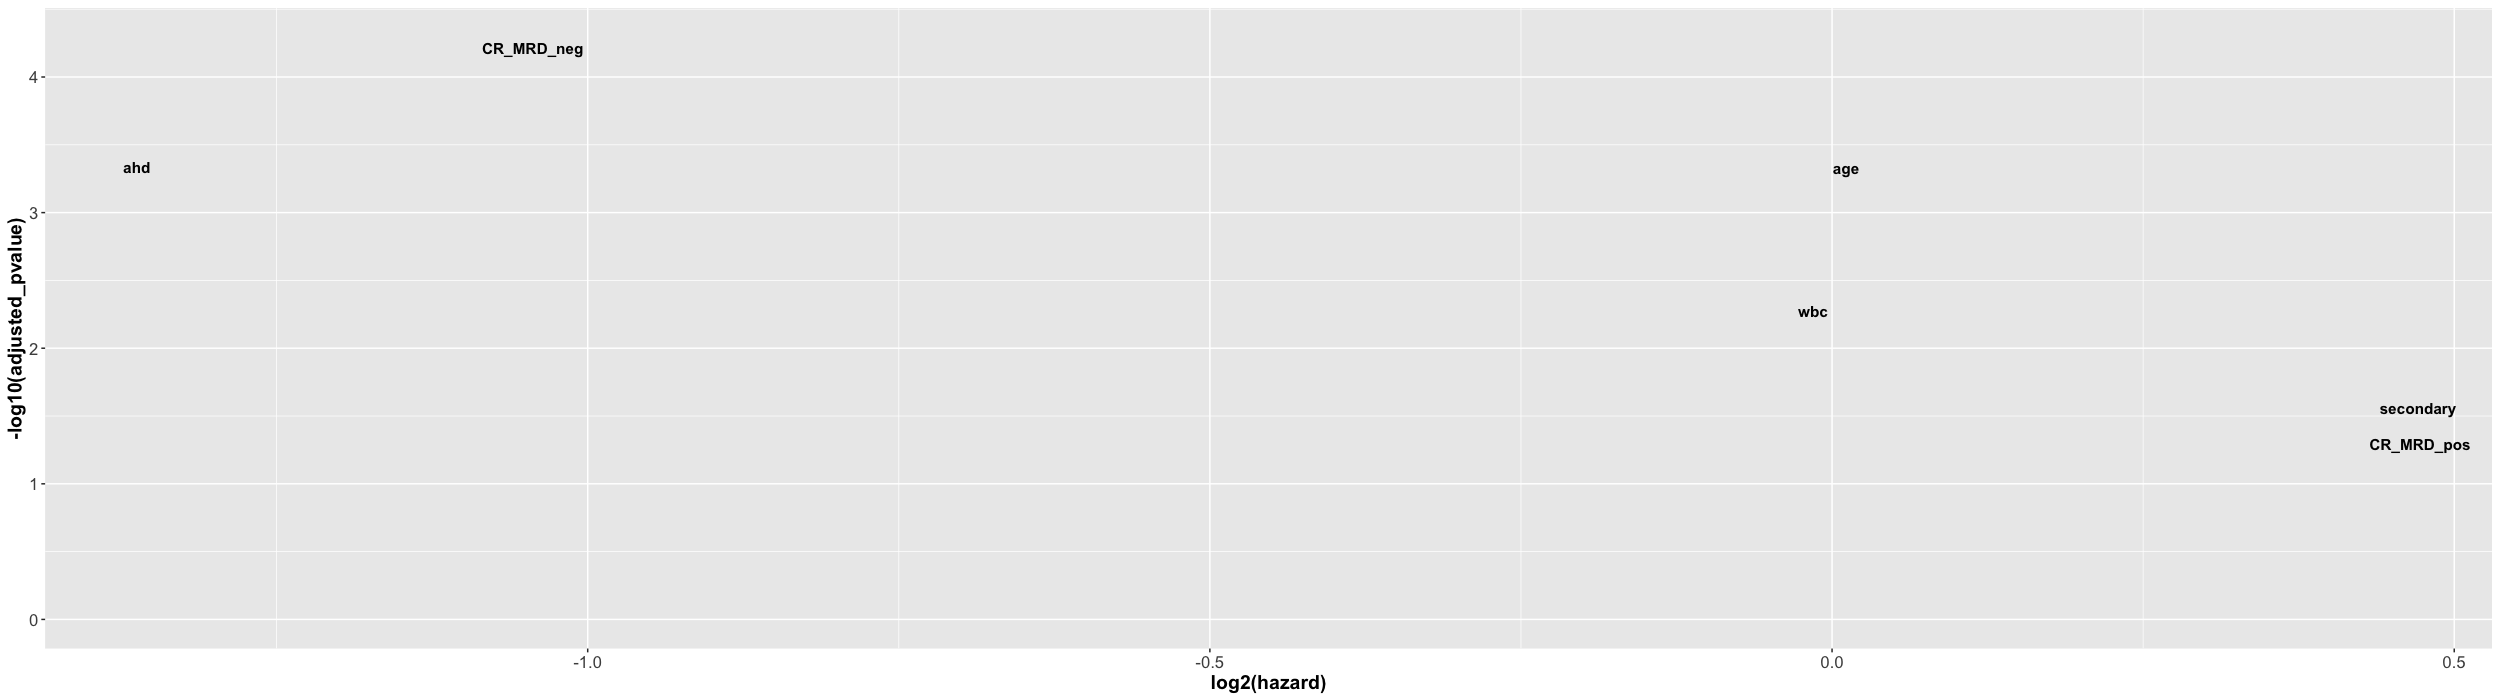

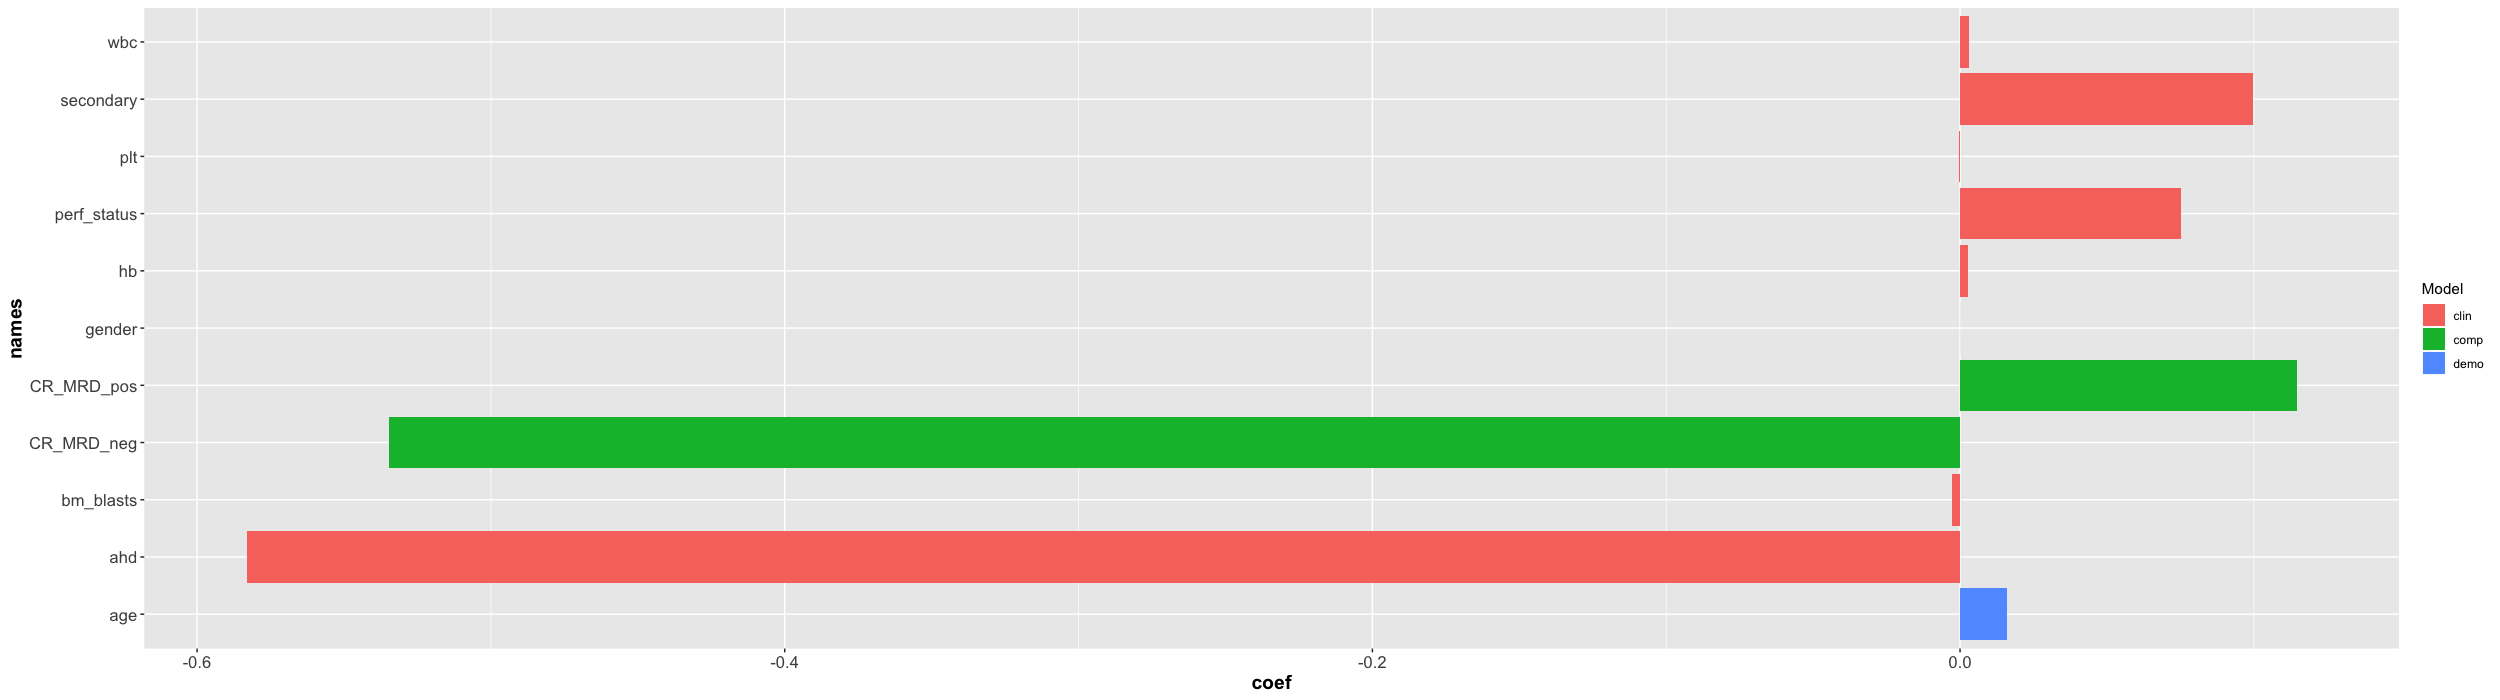

In [142]:
s
t